In [1]:
%load_ext autoreload
%autoreload 2

### Basic Imports

In [2]:
import nbimporter
from typing import Dict, Tuple, List
import numpy as np
from tqdm import tqdm

### Env Vars

In [3]:
QUBITS_NUM = 4 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
MAX_NUM_ITERATIONS = 50

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

### Simulator Backend

In [4]:
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals

seed = 50
algorithm_globals.random_seed = seed

simulator_backend = Aer.get_backend('qasm_simulator')

### BFGS Optimizer

In [5]:
from scipy.optimize import minimize

### Ansatz State

In [6]:
from linear_entangelment_and_full_entangelment_ansatz_circuits import *

In [7]:
def get_ansatz_state(thetas, ansatz_entangelment, input_state):
    if ansatz_entangelment=="full":
        return get_full_entangelment_ansatz(QUBITS_NUM, thetas, input_state)
    if ansatz_entangelment=="linear":
        return get_linear_entangelment_ansatz(QUBITS_NUM, thetas, input_state)

## Expectation Value

### convert hamiltonian to pauli strings

In [8]:
def transfrom_hamiltonian_into_pauli_strings(hamiltonian) -> List:
    pauli_operators = hamiltonian.to_pauli_op().settings['oplist']
    pauli_coeffs = list(map(lambda pauli_operator: pauli_operator.coeff, pauli_operators))
    pauli_strings = list(map(lambda pauli_operator: pauli_operator.primitive, pauli_operators))
    return pauli_coeffs, pauli_strings

### pauli string reduction to sigma_z's

In [9]:
from qiskit.circuit.library.standard_gates import HGate, SGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

In [10]:
reducing_to_pauli_z_mapping = {
    'I': 'I',
    'Z': 'Z',
    'X': 'Z',
    'Y': 'Z'
} 

In [11]:
def reduce_pauli_matrixes_into_sigma_z(pauli_string) -> str:
    reduced_pauli_string = ""
    for matrix_index in range(QUBITS_NUM):
        pauli_matrix = str(pauli_string[matrix_index])
        reduced_pauli_matrix = reducing_to_pauli_z_mapping[pauli_matrix]
        reduced_pauli_string = reduced_pauli_matrix + reduced_pauli_string
    
    return reduced_pauli_string

In [12]:
def add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string, quantum_circuit):
    quantum_registers = QuantumRegister(QUBITS_NUM, name="qubit")
    additional_circuit_layer = QuantumCircuit(quantum_registers)
    
    for quantum_register_index, pauli_matrix in enumerate(pauli_string):
        if pauli_matrix == "X":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
        if pauli_string == "Y":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
            additional_circuit_layer.append(SGate(), [quantum_registers[quantum_register_index]])
                
    extended_quantum_circuit = quantum_circuit.compose(additional_circuit_layer)
    return extended_quantum_circuit

### probabilities distribution

In [13]:
def get_probability_distribution(counts: Dict) -> Dict:
    proba_distribution = {state: (count / NUM_SHOTS) for state, count in counts.items()}
    return proba_distribution

def calculate_probabilities_of_measurments_in_computational_basis(quantum_state_circuit) -> Dict:
    quantum_state_circuit.measure_all()
    
    transpiled_quantum_state_circuit = transpile(quantum_state_circuit, simulator_backend) 
    Qobj = assemble(transpiled_quantum_state_circuit)
    result = simulator_backend.run(Qobj).result()
    counts = result.get_counts(quantum_state_circuit)
    
    return get_probability_distribution(counts)

### Expectation value from probabilities

In [14]:
def sort_probas_dict_by_qubits_string_keys(proba_distribution: Dict) -> Dict:
    return dict(sorted(proba_distribution.items()))

def reset_power_of_minus_1(power_of_minus_1):
    power_of_minus_1 = 0
    return power_of_minus_1

def convert_pauli_string_into_str(pauli_string) -> str:
    return str(pauli_string)

def calculate_expectation_value_of_pauli_string_by_measurments_probas(pauli_string, ansatz_circuit):
    pauli_string_expectation_value = 0
    power_of_minus_1 = 0
    
    pauli_string_str = convert_pauli_string_into_str(pauli_string)
    extended_ansatz_circuit = add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string_str, ansatz_circuit)
    probas_distribution = calculate_probabilities_of_measurments_in_computational_basis(extended_ansatz_circuit)
    
    reduced_pauli_string = reduce_pauli_matrixes_into_sigma_z(pauli_string)
    sorted_probas_distribuition = sort_probas_dict_by_qubits_string_keys(probas_distribution)
    for qubits_string, proba in sorted_probas_distribuition.items():
        for string_index in range(QUBITS_NUM):
            if(str(qubits_string[string_index])=="1" and str(pauli_string[string_index])=="Z"):
                power_of_minus_1 += 1
            
        pauli_string_expectation_value += pow(-1, power_of_minus_1)*proba
        power_of_minus_1 = reset_power_of_minus_1(power_of_minus_1)
        
    return pauli_string_expectation_value

In [15]:
def get_expectation_value(ansatz_circuit, pauli_coeffs, pauli_strings):
    total_expection_value = 0
    
    for pauli_coeff, pauli_string in zip(pauli_coeffs, pauli_strings):
        total_expection_value += pauli_coeff*calculate_expectation_value_of_pauli_string_by_measurments_probas(
                                                                                    pauli_string, ansatz_circuit)
    
    return total_expection_value

## Objective Function

In [16]:
from qiskit import assemble, transpile

def cost_function(thetas, hamiltonian, ansatz_entangelment):
    print("thetas:")
    print(thetas)
    initial_eigenvector = np.identity(N)[0]
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    ansatz_state = get_ansatz_state(thetas, ansatz_entangelment, initial_eigenvector)
        
    L = get_expectation_value(ansatz_state, pauli_coeffs, pauli_strings)
    print(L)
    insert_approximated_energy_to_list_of_all_approximated_energies(L)
        
    return L

## Optimization

In [17]:
def get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, ansatz_entangelment):
    initial_thetas = np.random.uniform(low=0, high=2*np.pi, size=PARAMS_NUM)
    print(initial_thetas)
    optimizer_result = minimize(cost_function,
                                x0=initial_thetas,
                                args=(hamiltonian, ansatz_entangelment),
                                method="BFGS",
                                options={"maxiter":MAX_NUM_ITERATIONS,
                                        "disp": True})
    print(optimizer_result)
    optimal_thetas = optimizer_result.x
    
    return optimal_thetas

In [18]:
def get_approximated_eigenvalue_of_hamiltonian(hamiltonian, ansatz_entangelment):
    optimal_thetas = get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, ansatz_entangelment)
    print(optimal_thetas)
    initial_eigenvector = np.identity(N)[0]
    optimal_ansatz_state = get_ansatz_state(optimal_thetas, ansatz_entangelment, initial_eigenvector)
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    approximated_eigenvalue = get_expectation_value(optimal_ansatz_state, pauli_coeffs, pauli_strings)

    return approximated_eigenvalue

## Comparsion

In [19]:
from numpy import linalg as LA

def get_approximation_error(exact_eigenvalue, approximated_eigenvalue):
    return abs(abs(exact_eigenvalue)-abs(approximated_eigenvalue))/abs(exact_eigenvalue)

In [20]:
def get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian):
    eigen_values = LA.eigvals(hamiltonian.to_matrix())
    print(sorted(eigen_values, reverse=True))
    
    return min(sorted(eigen_values,reverse=True))

In [21]:
def compare_exact_and_approximated_eigenvalue(hamiltonian, approximated_eigenvalue):
    exact_eigenvalue = get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian)
    print("Exact Eigenvalue:")
    print(exact_eigenvalue)
    print("\nApproximated Eigenvalue:")
    print(approximated_eigenvalue)

    print("\nApproximation Error")
    print(get_approximation_error(exact_eigenvalue, approximated_eigenvalue))
    
    plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue, margin=3)
    initialize_approximated_energy_to_list_of_all_approximated_energies()

## Visualization

In [22]:
approximated_energies = []

In [23]:
def insert_approximated_energy_to_list_of_all_approximated_energies(energy):
    approximated_energies.append(energy)

In [24]:
def initialize_approximated_energy_to_list_of_all_approximated_energies():
    approximated_energies = []

In [25]:
import matplotlib.pyplot as plt

def plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue, margin):
    plt.title("convergence of optimization process to the exact eigenvalue")
    plt.margins(0, margin)
    plt.plot(approximated_energies[:100])
    plt.axhline(y = exact_eigenvalue, color = 'r', linestyle = '-')
    plt.grid()
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")
    
def plot_fidelity():
    plt.plot(LiH_approximated_energies)
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")

## LiH Molecule 4 qubits

In [26]:
from qiskit.opflow import X, Z, I, H, Y

LiH_molecule_4_qubits = -7.49894690201071*(I^I^I^I) + \
                            -0.0029329964409502266*(X^X^Y^Y) + \
                            0.0029329964409502266*(X^Y^Y^X) + \
                            0.01291078027311749*(X^Z^X^I) + \
                            -0.0013743761078958677*(X^Z^X^Z) + \
                            0.011536413200774975*(X^I^X^I) + \
                            0.0029329964409502266*(Y^X^X^Y) + \
                            -0.0029329964409502266*(Y^Y^X^X) + \
                            0.01291078027311749*(Y^Z^Y^I) + \
                            -0.0013743761078958677*(Y^Z^Y^Z) + \
                            0.011536413200774975*(Y^I^Y^I) + \
                            0.16199475388004184*(Z^I^I^I) + \
                            0.011536413200774975*(Z^X^Z^X) + \
                            0.011536413200774975*(Z^Y^Z^Y) + \
                            0.12444770133137588*(Z^Z^I^I) + \
                            0.054130445793298836*(Z^I^Z^I) + \
                            0.05706344223424907*(Z^I^I^Z) + \
                            0.012910780273117487*(I^X^Z^X) + \
                            -0.0013743761078958677*(I^X^I^X) + \
                            0.012910780273117487*(I^Y^Z^Y) + \
                            -0.0013743761078958677*(I^Y^I^Y) + \
                            0.16199475388004186*(I^Z^I^I) + \
                            0.05706344223424907*(I^Z^Z^I) + \
                            0.054130445793298836*(I^Z^I^Z) + \
                            -0.013243698330265966*(I^I^Z^I) + \
                            0.08479609543670981*(I^I^Z^Z) + \
                            -0.013243698330265952*(I^I^I^Z)

In [27]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits, "linear")

[3.37800767 0.42658503 2.11651124 2.98182949 2.13725871 2.90480814
 5.35938746 5.51047285 3.13238074 1.18257006 0.26051222 2.33587793
 2.42610908 0.43084556 1.09820758 0.79867323 3.12528002 1.58477899
 2.06142656 3.27815998 0.59169153 3.88729344 1.59019387 4.2513346
 5.89823165 4.13666947 1.5404851  5.32160621 0.15349657 1.3710398
 1.53981777 5.94142569]
thetas:
[3.37800767 0.42658503 2.11651124 2.98182949 2.13725871 2.90480814
 5.35938746 5.51047285 3.13238074 1.18257006 0.26051222 2.33587793
 2.42610908 0.43084556 1.09820758 0.79867323 3.12528002 1.58477899
 2.06142656 3.27815998 0.59169153 3.88729344 1.59019387 4.2513346
 5.89823165 4.13666947 1.5404851  5.32160621 0.15349657 1.3710398
 1.53981777 5.94142569]
-7.637180751973602
thetas:
[3.37800768 0.42658503 2.11651124 2.98182949 2.13725871 2.90480814
 5.35938746 5.51047285 3.13238074 1.18257006 0.26051222 2.33587793
 2.42610908 0.43084556 1.09820758 0.79867323 3.12528002 1.58477899
 2.06142656 3.27815998 0.59169153 3.88729344 1.590

-7.628430227335277
thetas:
[3.37800767 0.42658503 2.11651124 2.98182949 2.13725871 2.90480814
 5.35938746 5.51047285 3.13238074 1.18257006 0.26051222 2.33587793
 2.42610908 0.43084556 1.09820758 0.79867323 3.12528002 1.58477899
 2.06142656 3.27815998 0.59169154 3.88729344 1.59019387 4.2513346
 5.89823165 4.13666947 1.5404851  5.32160621 0.15349657 1.3710398
 1.53981777 5.94142569]
-7.6298559998286555
thetas:
[3.37800767 0.42658503 2.11651124 2.98182949 2.13725871 2.90480814
 5.35938746 5.51047285 3.13238074 1.18257006 0.26051222 2.33587793
 2.42610908 0.43084556 1.09820758 0.79867323 3.12528002 1.58477899
 2.06142656 3.27815998 0.59169153 3.88729346 1.59019387 4.2513346
 5.89823165 4.13666947 1.5404851  5.32160621 0.15349657 1.3710398
 1.53981777 5.94142569]
-7.644226374472712
thetas:
[3.37800767 0.42658503 2.11651124 2.98182949 2.13725871 2.90480814
 5.35938746 5.51047285 3.13238074 1.18257006 0.26051222 2.33587793
 2.42610908 0.43084556 1.09820758 0.79867323 3.12528002 1.58477899
 2.

-7.575123495851869
thetas:
[ 3.10276334  0.52130024  2.157114    2.77951091  2.08875721  2.89065861
  5.22588318  5.55406241  3.01275594  1.29175584 -0.0585389   2.36712858
  2.48760897  0.36476608  1.4209215   1.02779256  3.07701393  1.59054657
  2.08502011  3.07585258  0.42234721  4.05018443  1.89378597  4.31618085
  5.67191239  4.44481223  1.5745695   5.27732409 -0.29796124  1.51337871
  1.58388394  5.86410642]
-7.586991934111805
thetas:
[ 3.10276334  0.52130024  2.157114    2.77951091  2.08875721  2.89065861
  5.22588318  5.55406241  3.01275593  1.29175586 -0.0585389   2.36712858
  2.48760897  0.36476608  1.4209215   1.02779256  3.07701393  1.59054657
  2.08502011  3.07585258  0.42234721  4.05018443  1.89378597  4.31618085
  5.67191239  4.44481223  1.5745695   5.27732409 -0.29796124  1.51337871
  1.58388394  5.86410642]
-7.586432421310184
thetas:
[ 3.10276334  0.52130024  2.157114    2.77951091  2.08875721  2.89065861
  5.22588318  5.55406241  3.01275593  1.29175584 -0.05853889  2.

-7.589217212244976
thetas:
[ 3.10276334  0.52130024  2.157114    2.77951091  2.08875721  2.89065861
  5.22588318  5.55406241  3.01275593  1.29175584 -0.0585389   2.36712858
  2.48760897  0.36476608  1.4209215   1.02779256  3.07701393  1.59054657
  2.08502011  3.07585258  0.42234721  4.05018443  1.89378597  4.31618085
  5.67191239  4.44481223  1.5745695   5.27732409 -0.29796122  1.51337871
  1.58388394  5.86410642]
-7.589415059064549
thetas:
[ 3.10276334  0.52130024  2.157114    2.77951091  2.08875721  2.89065861
  5.22588318  5.55406241  3.01275593  1.29175584 -0.0585389   2.36712858
  2.48760897  0.36476608  1.4209215   1.02779256  3.07701393  1.59054657
  2.08502011  3.07585258  0.42234721  4.05018443  1.89378597  4.31618085
  5.67191239  4.44481223  1.5745695   5.27732409 -0.29796124  1.51337872
  1.58388394  5.86410642]
-7.5772282718909265
thetas:
[ 3.10276334  0.52130024  2.157114    2.77951091  2.08875721  2.89065861
  5.22588318  5.55406241  3.01275593  1.29175584 -0.0585389   2

-7.628886718023679
thetas:
[3.29013402 0.45682351 2.12947395 2.91723789 2.12177427 2.9002908
 5.3167653  5.52438912 3.0941897  1.21742837 0.15865295 2.34585492
 2.44574334 0.40974923 1.20123622 0.87182115 3.10987075 1.58662033
 2.06895897 3.21357195 0.53762719 3.93929751 1.68711774 4.27203722
 5.82597767 4.23504617 1.55136678 5.30746884 0.00936555 1.41648248
 1.5538862  5.91674098]
-7.626190729756376
thetas:
[3.29013402 0.45682351 2.12947395 2.91723789 2.12177427 2.9002908
 5.3167653  5.52438912 3.0941897  1.21742837 0.15865295 2.34585492
 2.44574334 0.40974923 1.20123622 0.87182115 3.10987074 1.58662034
 2.06895897 3.21357195 0.53762719 3.93929751 1.68711774 4.27203722
 5.82597767 4.23504617 1.55136678 5.30746884 0.00936555 1.41648248
 1.5538862  5.91674098]
-7.630909066200175
thetas:
[3.29013402 0.45682351 2.12947395 2.91723789 2.12177427 2.9002908
 5.3167653  5.52438912 3.0941897  1.21742837 0.15865295 2.34585492
 2.44574334 0.40974923 1.20123622 0.87182115 3.10987074 1.58662033
 2.

-7.628729976974687
thetas:
[3.35259158 0.43533104 2.12026051 2.96314737 2.13278008 2.90350159
 5.34705966 5.51449791 3.12133458 1.19265228 0.23105101 2.33876362
 2.43178799 0.42474378 1.12800701 0.81983013 3.12082312 1.58531157
 2.06360519 3.2594789  0.57605426 3.90233481 1.61822759 4.25732251
 5.87733331 4.1651234  1.54363246 5.31751719 0.11180892 1.38418339
 1.54388684 5.93428602]
-7.62905191103372
thetas:
[3.35259158 0.43533104 2.12026051 2.96314737 2.13278008 2.90350157
 5.34705968 5.51449791 3.12133458 1.19265228 0.23105101 2.33876362
 2.43178799 0.42474378 1.12800701 0.81983013 3.12082312 1.58531157
 2.06360519 3.2594789  0.57605426 3.90233481 1.61822759 4.25732251
 5.87733331 4.1651234  1.54363246 5.31751719 0.11180892 1.38418339
 1.54388684 5.93428602]
-7.641659933162499
thetas:
[3.35259158 0.43533104 2.12026051 2.96314737 2.13278008 2.90350157
 5.34705966 5.51449793 3.12133458 1.19265228 0.23105101 2.33876362
 2.43178799 0.42474378 1.12800701 0.81983013 3.12082312 1.58531157
 

-7.624677068967084
thetas:
[3.35259158 0.43533104 2.12026051 2.96314737 2.13278008 2.90350157
 5.34705966 5.51449791 3.12133458 1.19265228 0.23105101 2.33876362
 2.43178799 0.42474378 1.12800701 0.81983013 3.12082312 1.58531157
 2.06360519 3.2594789  0.57605426 3.90233481 1.61822759 4.25732251
 5.87733331 4.1651234  1.54363246 5.31751721 0.11180892 1.38418339
 1.54388684 5.93428602]
-7.6342169887673155
thetas:
[3.35259158 0.43533104 2.12026051 2.96314737 2.13278008 2.90350157
 5.34705966 5.51449791 3.12133458 1.19265228 0.23105101 2.33876362
 2.43178799 0.42474378 1.12800701 0.81983013 3.12082312 1.58531157
 2.06360519 3.2594789  0.57605426 3.90233481 1.61822759 4.25732251
 5.87733331 4.1651234  1.54363246 5.31751719 0.11180893 1.38418339
 1.54388684 5.93428602]
-7.631056369349385
thetas:
[3.35259158 0.43533104 2.12026051 2.96314737 2.13278008 2.90350157
 5.34705966 5.51449791 3.12133458 1.19265228 0.23105101 2.33876362
 2.43178799 0.42474378 1.12800701 0.81983013 3.12082312 1.58531157

-7.635184629195273
thetas:
[3.37037114 0.42921286 2.11763775 2.97621625 2.13591306 2.90441557
 5.35568344 5.51168222 3.12906181 1.18559937 0.2516603  2.33674496
 2.42781537 0.42901222 1.10716112 0.80503004 3.12394091 1.58493901
 2.06208115 3.27254706 0.58699315 3.89181277 1.59861689 4.25313373
 5.89195253 4.14521875 1.54143076 5.32037762 0.14097108 1.37498893
 1.54104036 5.9392805 ]
-7.638395866735078
thetas:
[3.37037114 0.42921286 2.11763775 2.97621625 2.13591306 2.90441557
 5.35568344 5.51168222 3.12906181 1.18559937 0.2516603  2.33674496
 2.42781537 0.42901222 1.10716112 0.80503004 3.1239409  1.58493902
 2.06208115 3.27254706 0.58699315 3.89181277 1.59861689 4.25313373
 5.89195253 4.14521875 1.54143076 5.32037762 0.14097108 1.37498893
 1.54104036 5.9392805 ]
-7.6295074050513625
thetas:
[3.37037114 0.42921286 2.11763775 2.97621625 2.13591306 2.90441557
 5.35568344 5.51168222 3.12906181 1.18559937 0.2516603  2.33674496
 2.42781537 0.42901222 1.10716112 0.80503004 3.1239409  1.58493901

-7.640127009576306
thetas:
[3.37500018 0.42761994 2.1169549  2.97961883 2.13672876 2.90465355
 5.35792871 5.51094913 3.13107365 1.18376309 0.25702607 2.33621939
 2.42678107 0.43012354 1.10173375 0.80117673 3.12475263 1.58484201
 2.06168436 3.27594945 0.58984117 3.88907329 1.59351111 4.25204315
 5.89575874 4.14003643 1.54085753 5.32112235 0.14856366 1.37259509
 1.54029926 5.94058085]
-7.625062271863111
thetas:
[3.37500018 0.42761994 2.1169549  2.97961883 2.13672876 2.90465353
 5.35792872 5.51094913 3.13107365 1.18376309 0.25702607 2.33621939
 2.42678107 0.43012354 1.10173375 0.80117673 3.12475263 1.58484201
 2.06168436 3.27594945 0.58984117 3.88907329 1.59351111 4.25204315
 5.89575874 4.14003643 1.54085753 5.32112235 0.14856366 1.37259509
 1.54029926 5.94058085]
-7.631108693123488
thetas:
[3.37500018 0.42761994 2.1169549  2.97961883 2.13672876 2.90465353
 5.35792871 5.51094915 3.13107365 1.18376309 0.25702607 2.33621939
 2.42678107 0.43012354 1.10173375 0.80117673 3.12475263 1.58484201


-7.646253086710358
thetas:
[3.37500018 0.42761994 2.1169549  2.97961883 2.13672876 2.90465353
 5.35792871 5.51094913 3.13107365 1.18376309 0.25702607 2.33621939
 2.42678107 0.43012354 1.10173375 0.80117673 3.12475263 1.58484201
 2.06168436 3.27594945 0.58984117 3.88907329 1.59351111 4.25204315
 5.89575874 4.14003643 1.54085753 5.32112237 0.14856366 1.37259509
 1.54029926 5.94058085]
-7.642734313480668
thetas:
[3.37500018 0.42761994 2.1169549  2.97961883 2.13672876 2.90465353
 5.35792871 5.51094913 3.13107365 1.18376309 0.25702607 2.33621939
 2.42678107 0.43012354 1.10173375 0.80117673 3.12475263 1.58484201
 2.06168436 3.27594945 0.58984117 3.88907329 1.59351111 4.25204315
 5.89575874 4.14003643 1.54085753 5.32112235 0.14856368 1.37259509
 1.54029926 5.94058085]
-7.6312305064232655
thetas:
[3.37500018 0.42761994 2.1169549  2.97961883 2.13672876 2.90465353
 5.35792871 5.51094913 3.13107365 1.18376309 0.25702607 2.33621939
 2.42678107 0.43012354 1.10173375 0.80117673 3.12475263 1.58484201

-7.627266205245933
thetas:
[3.37702301 0.42692386 2.1166565  2.98110571 2.1370852  2.90475752
 5.35890986 5.51062878 3.1319528  1.18296066 0.25937085 2.33598973
 2.42632909 0.43060917 1.09936205 0.79949288 3.12510737 1.58479962
 2.06151096 3.27743625 0.59108571 3.88787617 1.59127995 4.25156658
 5.89742201 4.13777182 1.54060704 5.32144779 0.15188152 1.37154901
 1.53997541 5.94114909]
-7.632679816217454
thetas:
[3.37702301 0.42692386 2.1166565  2.98110571 2.1370852  2.90475752
 5.35890986 5.51062878 3.1319528  1.18296066 0.25937085 2.33598973
 2.42632909 0.43060917 1.09936205 0.79949288 3.12510735 1.58479963
 2.06151096 3.27743625 0.59108571 3.88787617 1.59127995 4.25156658
 5.89742201 4.13777182 1.54060704 5.32144779 0.15188152 1.37154901
 1.53997541 5.94114909]
-7.626220617490103
thetas:
[3.37702301 0.42692386 2.1166565  2.98110571 2.1370852  2.90475752
 5.35890986 5.51062878 3.1319528  1.18296066 0.25937085 2.33598973
 2.42632909 0.43060917 1.09936205 0.79949288 3.12510735 1.58479962


-7.623222654426255
thetas:
[3.37772353 0.4266828  2.11655316 2.98162064 2.13720865 2.90479355
 5.35924964 5.51051784 3.13225725 1.18268277 0.26018287 2.33591019
 2.42617257 0.43077735 1.09854071 0.79890975 3.12523019 1.58478494
 2.06145092 3.27795114 0.59151672 3.88746159 1.59050727 4.25140154
 5.89799802 4.13698756 1.54052029 5.32156049 0.15303053 1.37118674
 1.53986326 5.94134587]
-7.633429048546385
thetas:
[3.37772353 0.4266828  2.11655316 2.98162064 2.13720865 2.90479353
 5.35924966 5.51051784 3.13225725 1.18268277 0.26018287 2.33591019
 2.42617257 0.43077735 1.09854071 0.79890975 3.12523019 1.58478494
 2.06145092 3.27795114 0.59151672 3.88746159 1.59050727 4.25140154
 5.89799802 4.13698756 1.54052029 5.32156049 0.15303053 1.37118674
 1.53986326 5.94134587]
-7.635694071204905
thetas:
[3.37772353 0.4266828  2.11655316 2.98162064 2.13720865 2.90479353
 5.35924964 5.51051786 3.13225725 1.18268277 0.26018287 2.33591019
 2.42617257 0.43077735 1.09854071 0.79890975 3.12523019 1.58478494


-7.639103119636861
thetas:
[3.37772353 0.4266828  2.11655316 2.98162064 2.13720865 2.90479353
 5.35924964 5.51051784 3.13225725 1.18268277 0.26018287 2.33591019
 2.42617257 0.43077735 1.09854071 0.79890975 3.12523019 1.58478494
 2.06145092 3.27795114 0.59151672 3.88746159 1.59050727 4.25140154
 5.89799802 4.13698756 1.54052029 5.32156051 0.15303053 1.37118674
 1.53986326 5.94134587]
-7.627079987187494
thetas:
[3.37772353 0.4266828  2.11655316 2.98162064 2.13720865 2.90479353
 5.35924964 5.51051784 3.13225725 1.18268277 0.26018287 2.33591019
 2.42617257 0.43077735 1.09854071 0.79890975 3.12523019 1.58478494
 2.06145092 3.27795114 0.59151672 3.88746159 1.59050727 4.25140154
 5.89799802 4.13698756 1.54052029 5.32156049 0.15303055 1.37118674
 1.53986326 5.94134587]
-7.645995679379042
thetas:
[3.37772353 0.4266828  2.11655316 2.98162064 2.13720865 2.90479353
 5.35924964 5.51051784 3.13225725 1.18268277 0.26018287 2.33591019
 2.42617257 0.43077735 1.09854071 0.79890975 3.12523019 1.58478494


-7.65296972656042
thetas:
[3.37791087 0.42661834 2.11652552 2.98175834 2.13724166 2.90480316
 5.35934051 5.51048818 3.13233867 1.18260846 0.26040002 2.33588892
 2.42613071 0.43082232 1.09832107 0.79875381 3.12526306 1.58478102
 2.06143486 3.27808883 0.59163197 3.88735073 1.59030064 4.25135741
 5.89815206 4.13677784 1.54049709 5.32159063 0.1533378  1.37108986
 1.53983326 5.9413985 ]
-7.648972233332954
thetas:
[3.37791087 0.42661834 2.11652552 2.98175834 2.13724166 2.90480316
 5.35934051 5.51048818 3.13233867 1.18260846 0.26040002 2.33588892
 2.42613071 0.43082232 1.09832107 0.79875381 3.12526305 1.58478103
 2.06143486 3.27808883 0.59163197 3.88735073 1.59030064 4.25135741
 5.89815206 4.13677784 1.54049709 5.32159063 0.1533378  1.37108986
 1.53983326 5.9413985 ]
-7.630618851579433
thetas:
[3.37791087 0.42661834 2.11652552 2.98175834 2.13724166 2.90480316
 5.35934051 5.51048818 3.13233867 1.18260846 0.26040002 2.33588892
 2.42613071 0.43082232 1.09832107 0.79875381 3.12526305 1.58478102
 

-7.653908477203545
thetas:
[3.37797794 0.42659526 2.11651563 2.98180764 2.13725347 2.90480663
 5.35937304 5.51047755 3.13236782 1.18258185 0.26047776 2.3358813
 2.42611573 0.43083843 1.09824243 0.79869798 3.12527481 1.58477961
 2.06142911 3.27813813 0.59167324 3.88731104 1.59022667 4.25134161
 5.8982072  4.13670275 1.54048879 5.32160142 0.1534478  1.37105518
 1.53982253 5.94141734]
-7.644714366784108
thetas:
[3.37797794 0.42659526 2.11651563 2.98180764 2.13725347 2.90480661
 5.35937305 5.51047755 3.13236782 1.18258185 0.26047776 2.3358813
 2.42611573 0.43083843 1.09824243 0.79869798 3.12527481 1.58477961
 2.06142911 3.27813813 0.59167324 3.88731104 1.59022667 4.25134161
 5.8982072  4.13670275 1.54048879 5.32160142 0.1534478  1.37105518
 1.53982253 5.94141734]
-7.642329506951328
thetas:
[3.37797794 0.42659526 2.11651563 2.98180764 2.13725347 2.90480661
 5.35937304 5.51047757 3.13236782 1.18258185 0.26047776 2.3358813
 2.42611573 0.43083843 1.09824243 0.79869798 3.12527481 1.58477961
 2.

-7.633260488812355
thetas:
[3.37797794 0.42659526 2.11651563 2.98180764 2.13725347 2.90480661
 5.35937304 5.51047755 3.13236782 1.18258185 0.26047776 2.3358813
 2.42611573 0.43083843 1.09824243 0.79869798 3.12527481 1.58477961
 2.06142911 3.27813813 0.59167324 3.88731104 1.59022667 4.25134161
 5.8982072  4.13670275 1.54048879 5.32160144 0.1534478  1.37105518
 1.53982253 5.94141734]
-7.642531566899442
thetas:
[3.37797794 0.42659526 2.11651563 2.98180764 2.13725347 2.90480661
 5.35937304 5.51047755 3.13236782 1.18258185 0.26047776 2.3358813
 2.42611573 0.43083843 1.09824243 0.79869798 3.12527481 1.58477961
 2.06142911 3.27813813 0.59167324 3.88731104 1.59022667 4.25134161
 5.8982072  4.13670275 1.54048879 5.32160142 0.15344782 1.37105518
 1.53982253 5.94141734]
-7.641808926382296
thetas:
[3.37797794 0.42659526 2.11651563 2.98180764 2.13725347 2.90480661
 5.35937304 5.51047755 3.13236782 1.18258185 0.26047776 2.3358813
 2.42611573 0.43083843 1.09824243 0.79869798 3.12527481 1.58477961
 2.

-7.6260080650373885
thetas:
[3.37799666 0.42658881 2.11651287 2.9818214  2.13725677 2.90480757
 5.35938212 5.51047459 3.13237596 1.18257442 0.26049947 2.33587918
 2.42611154 0.43084292 1.09822048 0.79868239 3.1252781  1.58477922
 2.0614275  3.27815189 0.59168476 3.88729995 1.59020601 4.2513372
 5.8982226  4.13668179 1.54048647 5.32160444 0.15347852 1.37104549
 1.53981953 5.9414226 ]
-7.642302438689532
thetas:
[3.37799666 0.42658881 2.11651287 2.9818214  2.13725677 2.90480757
 5.35938212 5.51047459 3.13237596 1.18257442 0.26049947 2.33587918
 2.42611154 0.43084292 1.09822048 0.79868239 3.12527809 1.58477923
 2.0614275  3.27815189 0.59168476 3.88729995 1.59020601 4.2513372
 5.8982226  4.13668179 1.54048647 5.32160444 0.15347852 1.37104549
 1.53981953 5.9414226 ]
-7.635404932508965
thetas:
[3.37799666 0.42658881 2.11651287 2.9818214  2.13725677 2.90480757
 5.35938212 5.51047459 3.13237596 1.18257442 0.26049947 2.33587918
 2.42611154 0.43084292 1.09822048 0.79868239 3.12527809 1.58477922
 

-7.637054972633996
thetas:
[3.3780033  0.42658653 2.11651189 2.98182628 2.13725794 2.90480793
 5.35938534 5.51047354 3.13237884 1.18257179 0.26050716 2.33587842
 2.42611006 0.43084451 1.09821269 0.79867686 3.12527925 1.58477908
 2.06142693 3.27815677 0.59168884 3.88729602 1.59019869 4.25133563
 5.89822806 4.13667436 1.54048565 5.3216055  0.15348941 1.37104206
 1.53981847 5.94142446]
-7.633850969929272
thetas:
[3.3780033  0.42658653 2.11651189 2.98182628 2.13725794 2.90480791
 5.35938536 5.51047354 3.13237884 1.18257179 0.26050716 2.33587842
 2.42611006 0.43084451 1.09821269 0.79867686 3.12527925 1.58477908
 2.06142693 3.27815677 0.59168884 3.88729602 1.59019869 4.25133563
 5.89822806 4.13667436 1.54048565 5.3216055  0.15348941 1.37104206
 1.53981847 5.94142446]
-7.62997716979626
thetas:
[3.3780033  0.42658653 2.11651189 2.98182628 2.13725794 2.90480791
 5.35938534 5.51047355 3.13237884 1.18257179 0.26050716 2.33587842
 2.42611006 0.43084451 1.09821269 0.79867686 3.12527925 1.58477908
 

-7.637476626148853
thetas:
[3.3780033  0.42658653 2.11651189 2.98182628 2.13725794 2.90480791
 5.35938534 5.51047354 3.13237884 1.18257179 0.26050716 2.33587842
 2.42611006 0.43084451 1.09821269 0.79867686 3.12527925 1.58477908
 2.06142693 3.27815677 0.59168884 3.88729602 1.59019869 4.25133563
 5.89822806 4.13667436 1.54048565 5.32160552 0.15348941 1.37104206
 1.53981847 5.94142446]
-7.646488107903318
thetas:
[3.3780033  0.42658653 2.11651189 2.98182628 2.13725794 2.90480791
 5.35938534 5.51047354 3.13237884 1.18257179 0.26050716 2.33587842
 2.42611006 0.43084451 1.09821269 0.79867686 3.12527925 1.58477908
 2.06142693 3.27815677 0.59168884 3.88729602 1.59019869 4.25133563
 5.89822806 4.13667436 1.54048565 5.3216055  0.15348942 1.37104206
 1.53981847 5.94142446]
-7.639506943770853
thetas:
[3.3780033  0.42658653 2.11651189 2.98182628 2.13725794 2.90480791
 5.35938534 5.51047354 3.13237884 1.18257179 0.26050716 2.33587842
 2.42611006 0.43084451 1.09821269 0.79867686 3.12527925 1.58477908


-7.631732104180962
thetas:
[3.37800624 0.42658552 2.11651146 2.98182844 2.13725846 2.90480807
 5.35938677 5.51047307 3.13238012 1.18257063 0.26051057 2.33587809
 2.4261094  0.43084522 1.09820925 0.79867442 3.12527978 1.58477902
 2.06142668 3.27815893 0.59169065 3.88729428 1.59019545 4.25133494
 5.89823048 4.13667107 1.54048528 5.32160598 0.15349423 1.37104054
 1.539818   5.94142529]
-7.638193306889061
thetas:
[3.37800624 0.42658552 2.11651146 2.98182844 2.13725846 2.90480807
 5.35938677 5.51047307 3.13238012 1.18257063 0.26051057 2.33587809
 2.4261094  0.43084522 1.09820925 0.79867442 3.12527977 1.58477903
 2.06142668 3.27815893 0.59169065 3.88729428 1.59019545 4.25133494
 5.89823048 4.13667107 1.54048528 5.32160598 0.15349423 1.37104054
 1.539818   5.94142529]
-7.6161483021225305
thetas:
[3.37800624 0.42658552 2.11651146 2.98182844 2.13725846 2.90480807
 5.35938677 5.51047307 3.13238012 1.18257063 0.26051057 2.33587809
 2.4261094  0.43084522 1.09820925 0.79867442 3.12527977 1.58477902

-7.643987105437833
thetas:
[3.37800715 0.42658521 2.11651132 2.98182911 2.13725862 2.90480813
 5.35938721 5.51047293 3.13238052 1.18257027 0.26051162 2.33587799
 2.4261092  0.43084544 1.09820819 0.79867366 3.12527993 1.584779
 2.06142661 3.2781596  0.59169121 3.88729375 1.59019445 4.25133473
 5.89823122 4.13667005 1.54048517 5.32160612 0.15349571 1.37104007
 1.53981785 5.94142554]
-7.6472074292816865
thetas:
[3.37800715 0.42658521 2.11651132 2.98182911 2.13725862 2.90480811
 5.35938722 5.51047293 3.13238052 1.18257027 0.26051162 2.33587799
 2.4261092  0.43084544 1.09820819 0.79867366 3.12527993 1.584779
 2.06142661 3.2781596  0.59169121 3.88729375 1.59019445 4.25133473
 5.89823122 4.13667005 1.54048517 5.32160612 0.15349571 1.37104007
 1.53981785 5.94142554]
-7.635701376859478
thetas:
[3.37800715 0.42658521 2.11651132 2.98182911 2.13725862 2.90480811
 5.35938721 5.51047294 3.13238052 1.18257027 0.26051162 2.33587799
 2.4261092  0.43084544 1.09820819 0.79867366 3.12527993 1.584779
 2.06

-7.634044064880013
thetas:
[3.37800715 0.42658521 2.11651132 2.98182911 2.13725862 2.90480811
 5.35938721 5.51047293 3.13238052 1.18257027 0.26051162 2.33587799
 2.4261092  0.43084544 1.09820819 0.79867366 3.12527993 1.584779
 2.06142661 3.2781596  0.59169121 3.88729375 1.59019445 4.25133473
 5.89823122 4.13667005 1.54048517 5.32160614 0.15349571 1.37104007
 1.53981785 5.94142554]
-7.624803958451085
thetas:
[3.37800715 0.42658521 2.11651132 2.98182911 2.13725862 2.90480811
 5.35938721 5.51047293 3.13238052 1.18257027 0.26051162 2.33587799
 2.4261092  0.43084544 1.09820819 0.79867366 3.12527993 1.584779
 2.06142661 3.2781596  0.59169121 3.88729375 1.59019445 4.25133473
 5.89823122 4.13667005 1.54048517 5.32160612 0.15349573 1.37104007
 1.53981785 5.94142554]
-7.638312942245987
thetas:
[3.37800715 0.42658521 2.11651132 2.98182911 2.13725862 2.90480811
 5.35938721 5.51047293 3.13238052 1.18257027 0.26051162 2.33587799
 2.4261092  0.43084544 1.09820819 0.79867366 3.12527993 1.584779
 2.061

-7.6363840310546856
thetas:
[3.37800714 0.42658521 2.11651132 2.9818291  2.13725862 2.90480811
 5.3593872  5.51047293 3.13238052 1.18257027 0.26051162 2.33587799
 2.4261092  0.43084544 1.09820819 0.79867366 3.12527994 1.584779
 2.0614266  3.2781596  0.59169121 3.88729375 1.59019445 4.25133473
 5.89823122 4.13667006 1.54048517 5.32160612 0.15349571 1.37104007
 1.53981785 5.94142554]
-7.653667544088672
thetas:
[3.37800714 0.42658521 2.11651132 2.9818291  2.13725862 2.90480811
 5.3593872  5.51047293 3.13238052 1.18257027 0.26051162 2.33587799
 2.4261092  0.43084544 1.09820819 0.79867366 3.12527993 1.58477901
 2.0614266  3.2781596  0.59169121 3.88729375 1.59019445 4.25133473
 5.89823122 4.13667006 1.54048517 5.32160612 0.15349571 1.37104007
 1.53981785 5.94142554]
-7.637920037527795
thetas:
[3.37800714 0.42658521 2.11651132 2.9818291  2.13725862 2.90480811
 5.3593872  5.51047293 3.13238052 1.18257027 0.26051162 2.33587799
 2.4261092  0.43084544 1.09820819 0.79867366 3.12527993 1.584779
 2.

-7.635701822358268
thetas:
[3.37800715 0.42658521 2.11651132 2.98182911 2.13725862 2.90480813
 5.35938721 5.51047293 3.13238052 1.18257027 0.26051162 2.33587799
 2.4261092  0.43084544 1.09820819 0.79867366 3.12527993 1.584779
 2.06142661 3.2781596  0.59169121 3.88729375 1.59019445 4.25133473
 5.89823122 4.13667005 1.54048517 5.32160612 0.15349571 1.37104007
 1.53981785 5.94142554]
-7.6346146361329
thetas:
[3.37800715 0.42658521 2.11651132 2.98182911 2.13725862 2.90480811
 5.35938722 5.51047293 3.13238052 1.18257027 0.26051162 2.33587799
 2.4261092  0.43084544 1.09820819 0.79867366 3.12527993 1.584779
 2.06142661 3.2781596  0.59169121 3.88729375 1.59019445 4.25133473
 5.89823122 4.13667005 1.54048517 5.32160612 0.15349571 1.37104007
 1.53981785 5.94142554]
-7.64817435057797
thetas:
[3.37800715 0.42658521 2.11651132 2.98182911 2.13725862 2.90480811
 5.35938721 5.51047294 3.13238052 1.18257027 0.26051162 2.33587799
 2.4261092  0.43084544 1.09820819 0.79867366 3.12527993 1.584779
 2.061426

-7.637735595577859
thetas:
[3.37800715 0.42658521 2.11651132 2.98182911 2.13725862 2.90480811
 5.35938721 5.51047293 3.13238052 1.18257027 0.26051162 2.33587799
 2.4261092  0.43084544 1.09820819 0.79867366 3.12527993 1.584779
 2.06142661 3.2781596  0.59169121 3.88729375 1.59019445 4.25133473
 5.89823122 4.13667005 1.54048517 5.32160614 0.15349571 1.37104007
 1.53981785 5.94142554]
-7.635857334077943
thetas:
[3.37800715 0.42658521 2.11651132 2.98182911 2.13725862 2.90480811
 5.35938721 5.51047293 3.13238052 1.18257027 0.26051162 2.33587799
 2.4261092  0.43084544 1.09820819 0.79867366 3.12527993 1.584779
 2.06142661 3.2781596  0.59169121 3.88729375 1.59019445 4.25133473
 5.89823122 4.13667005 1.54048517 5.32160612 0.15349573 1.37104007
 1.53981785 5.94142554]
-7.650380694891084
thetas:
[3.37800715 0.42658521 2.11651132 2.98182911 2.13725862 2.90480811
 5.35938721 5.51047293 3.13238052 1.18257027 0.26051162 2.33587799
 2.4261092  0.43084544 1.09820819 0.79867366 3.12527993 1.584779
 2.061

-7.661156570678226
thetas:
[3.37800715 0.42658521 2.11651132 2.98182911 2.13725862 2.90480811
 5.35938721 5.51047293 3.13238052 1.18257027 0.26051162 2.33587799
 2.4261092  0.43084544 1.09820819 0.79867366 3.12527994 1.584779
 2.06142661 3.2781596  0.59169121 3.88729375 1.59019445 4.25133473
 5.89823122 4.13667005 1.54048517 5.32160612 0.15349571 1.37104007
 1.53981785 5.94142554]
-7.629373188467065
thetas:
[3.37800715 0.42658521 2.11651132 2.98182911 2.13725862 2.90480811
 5.35938721 5.51047293 3.13238052 1.18257027 0.26051162 2.33587799
 2.4261092  0.43084544 1.09820819 0.79867366 3.12527993 1.58477901
 2.06142661 3.2781596  0.59169121 3.88729375 1.59019445 4.25133473
 5.89823122 4.13667005 1.54048517 5.32160612 0.15349571 1.37104007
 1.53981785 5.94142554]
-7.644653733229087
thetas:
[3.37800715 0.42658521 2.11651132 2.98182911 2.13725862 2.90480811
 5.35938721 5.51047293 3.13238052 1.18257027 0.26051162 2.33587799
 2.4261092  0.43084544 1.09820819 0.79867366 3.12527993 1.584779
 2.0

-7.635965037267214
thetas:
[3.37800715 0.42658521 2.11651132 2.98182911 2.13725862 2.90480813
 5.35938721 5.51047293 3.13238052 1.18257027 0.26051162 2.33587799
 2.4261092  0.43084544 1.09820819 0.79867366 3.12527993 1.584779
 2.06142661 3.2781596  0.59169121 3.88729375 1.59019445 4.25133473
 5.89823122 4.13667005 1.54048517 5.32160612 0.15349571 1.37104007
 1.53981785 5.94142554]
-7.649844218483098
thetas:
[3.37800715 0.42658521 2.11651132 2.98182911 2.13725862 2.90480811
 5.35938722 5.51047293 3.13238052 1.18257027 0.26051162 2.33587799
 2.4261092  0.43084544 1.09820819 0.79867366 3.12527993 1.584779
 2.06142661 3.2781596  0.59169121 3.88729375 1.59019445 4.25133473
 5.89823122 4.13667005 1.54048517 5.32160612 0.15349571 1.37104007
 1.53981785 5.94142554]
-7.647398185700644
thetas:
[3.37800715 0.42658521 2.11651132 2.98182911 2.13725862 2.90480811
 5.35938721 5.51047294 3.13238052 1.18257027 0.26051162 2.33587799
 2.4261092  0.43084544 1.09820819 0.79867366 3.12527993 1.584779
 2.061

-7.635775463966715
thetas:
[3.37800715 0.42658521 2.11651132 2.98182911 2.13725862 2.90480811
 5.35938721 5.51047293 3.13238052 1.18257027 0.26051162 2.33587799
 2.4261092  0.43084544 1.09820819 0.79867366 3.12527993 1.584779
 2.06142661 3.2781596  0.59169121 3.88729375 1.59019445 4.25133473
 5.89823122 4.13667005 1.54048517 5.32160614 0.15349571 1.37104007
 1.53981785 5.94142554]
-7.645385498511292
thetas:
[3.37800715 0.42658521 2.11651132 2.98182911 2.13725862 2.90480811
 5.35938721 5.51047293 3.13238052 1.18257027 0.26051162 2.33587799
 2.4261092  0.43084544 1.09820819 0.79867366 3.12527993 1.584779
 2.06142661 3.2781596  0.59169121 3.88729375 1.59019445 4.25133473
 5.89823122 4.13667005 1.54048517 5.32160612 0.15349573 1.37104007
 1.53981785 5.94142554]
-7.617609331769928
thetas:
[3.37800715 0.42658521 2.11651132 2.98182911 2.13725862 2.90480811
 5.35938721 5.51047293 3.13238052 1.18257027 0.26051162 2.33587799
 2.4261092  0.43084544 1.09820819 0.79867366 3.12527993 1.584779
 2.061

-7.643227790702949
thetas:
[3.37800715 0.42658521 2.11651132 2.98182911 2.13725862 2.90480811
 5.35938721 5.51047293 3.13238052 1.18257027 0.26051162 2.33587799
 2.4261092  0.43084544 1.09820819 0.79867366 3.12527994 1.584779
 2.06142661 3.2781596  0.59169121 3.88729375 1.59019445 4.25133473
 5.89823122 4.13667005 1.54048517 5.32160612 0.15349571 1.37104007
 1.53981785 5.94142554]
-7.630851798900852
thetas:
[3.37800715 0.42658521 2.11651132 2.98182911 2.13725862 2.90480811
 5.35938721 5.51047293 3.13238052 1.18257027 0.26051162 2.33587799
 2.4261092  0.43084544 1.09820819 0.79867366 3.12527993 1.58477901
 2.06142661 3.2781596  0.59169121 3.88729375 1.59019445 4.25133473
 5.89823122 4.13667005 1.54048517 5.32160612 0.15349571 1.37104007
 1.53981785 5.94142554]
-7.646195917934797
thetas:
[3.37800715 0.42658521 2.11651132 2.98182911 2.13725862 2.90480811
 5.35938721 5.51047293 3.13238052 1.18257027 0.26051162 2.33587799
 2.4261092  0.43084544 1.09820819 0.79867366 3.12527993 1.584779
 2.0

-7.638977761702673
thetas:
[3.37800715 0.42658521 2.11651132 2.98182911 2.13725862 2.90480811
 5.35938721 5.51047293 3.13238052 1.18257027 0.26051162 2.33587799
 2.4261092  0.43084544 1.09820819 0.79867366 3.12527993 1.584779
 2.06142661 3.2781596  0.59169121 3.88729375 1.59019445 4.25133473
 5.89823122 4.13667005 1.54048517 5.32160612 0.15349571 1.37104007
 1.53981785 5.94142554]
-7.621347984883239
thetas:
[3.37800715 0.42658521 2.11651132 2.98182911 2.13725862 2.90480811
 5.35938721 5.51047293 3.13238052 1.18257027 0.26051162 2.33587799
 2.4261092  0.43084544 1.09820819 0.79867366 3.12527993 1.584779
 2.06142661 3.2781596  0.59169121 3.88729375 1.59019445 4.25133473
 5.89823122 4.13667005 1.54048517 5.32160612 0.15349571 1.37104007
 1.53981785 5.94142554]
-7.637290406780023
thetas:
[3.37800715 0.42658521 2.11651132 2.98182911 2.13725862 2.90480811
 5.35938721 5.51047293 3.13238052 1.18257027 0.26051162 2.33587799
 2.4261092  0.43084544 1.09820819 0.79867366 3.12527993 1.584779
 2.061

### Comparsion between approximate value after optimtimzation and exact eigenvalue

[(-6.769813218087976+0j), (-7.130406955301308+0j), (-7.130406955301309+0j), (-7.151525481896562+0j), (-7.364817440287081+0j), (-7.511999706834451+0j), (-7.511999706834453+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.700475837803976+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.7140566916607005+0j), (-7.783396208286518+0j), (-7.7833962082865185+0j), (-7.862773163027979+0j)]
Exact Eigenvalue:
(-7.862773163027979+0j)

Approximated Eigenvalue:
-7.644320163559727

Approximation Error
0.027783200015924825


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


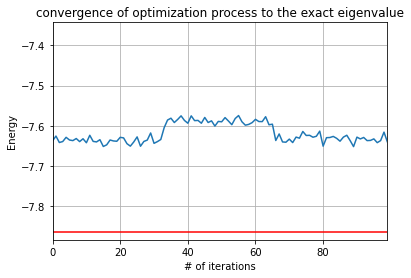

In [28]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

In [29]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits, "full")

[1.2419135  5.85948369 3.36941324 3.42843949 2.97707207 2.11603304
 1.95951252 3.7169452  5.19262202 3.04688007 2.61147777 6.21504317
 1.32995751 3.40677738 3.74760403 2.34584294 0.38163584 4.16896492
 5.85798397 3.47915876 0.36155563 5.13444212 4.82687927 5.69087962
 4.10918109 1.00458488 3.74236646 3.0759319  3.78536541 0.96693575
 5.61417426 1.65723768]
thetas:
[1.2419135  5.85948369 3.36941324 3.42843949 2.97707207 2.11603304
 1.95951252 3.7169452  5.19262202 3.04688007 2.61147777 6.21504317
 1.32995751 3.40677738 3.74760403 2.34584294 0.38163584 4.16896492
 5.85798397 3.47915876 0.36155563 5.13444212 4.82687927 5.69087962
 4.10918109 1.00458488 3.74236646 3.0759319  3.78536541 0.96693575
 5.61417426 1.65723768]
-7.4599455759878515
thetas:
[1.24191351 5.85948369 3.36941324 3.42843949 2.97707207 2.11603304
 1.95951252 3.7169452  5.19262202 3.04688007 2.61147777 6.21504317
 1.32995751 3.40677738 3.74760403 2.34584294 0.38163584 4.16896492
 5.85798397 3.47915876 0.36155563 5.13444212 

-7.477111424964012
thetas:
[1.2419135  5.85948369 3.36941324 3.42843949 2.97707207 2.11603304
 1.95951252 3.7169452  5.19262202 3.04688007 2.61147777 6.21504317
 1.32995751 3.40677738 3.74760403 2.34584294 0.38163584 4.16896492
 5.85798397 3.47915876 0.36155564 5.13444212 4.82687927 5.69087962
 4.10918109 1.00458488 3.74236646 3.0759319  3.78536541 0.96693575
 5.61417426 1.65723768]
-7.476852883386549
thetas:
[1.2419135  5.85948369 3.36941324 3.42843949 2.97707207 2.11603304
 1.95951252 3.7169452  5.19262202 3.04688007 2.61147777 6.21504317
 1.32995751 3.40677738 3.74760403 2.34584294 0.38163584 4.16896492
 5.85798397 3.47915876 0.36155563 5.13444214 4.82687927 5.69087962
 4.10918109 1.00458488 3.74236646 3.0759319  3.78536541 0.96693575
 5.61417426 1.65723768]
-7.451918005523177
thetas:
[1.2419135  5.85948369 3.36941324 3.42843949 2.97707207 2.11603304
 1.95951252 3.7169452  5.19262202 3.04688007 2.61147777 6.21504317
 1.32995751 3.40677738 3.74760403 2.34584294 0.38163584 4.16896492


-7.487155702266718
thetas:
[0.94175479 6.07327852 3.6609013  3.6391984  3.03460026 2.09335109
 2.13639749 3.91806045 5.52649853 3.10890963 3.00746849 6.21829368
 1.13751181 3.47474879 3.65718087 2.52749794 0.3936116  4.15460519
 5.80194644 3.7458797  0.62425938 5.00971068 4.94121997 5.62898383
 4.2948272  1.08969011 3.65087812 3.08561289 4.08553414 0.9262654
 5.53573392 1.67124286]
-7.4796876532791865
thetas:
[0.94175479 6.07327852 3.6609013  3.6391984  3.03460026 2.09335109
 2.13639749 3.91806045 5.52649853 3.10890961 3.00746851 6.21829368
 1.13751181 3.47474879 3.65718087 2.52749794 0.3936116  4.15460519
 5.80194644 3.7458797  0.62425938 5.00971068 4.94121997 5.62898383
 4.2948272  1.08969011 3.65087812 3.08561289 4.08553414 0.9262654
 5.53573392 1.67124286]
-7.479103182513711
thetas:
[0.94175479 6.07327852 3.6609013  3.6391984  3.03460026 2.09335109
 2.13639749 3.91806045 5.52649853 3.10890961 3.00746849 6.2182937
 1.13751181 3.47474879 3.65718087 2.52749794 0.3936116  4.15460519
 5

-7.481905898013585
thetas:
[0.94175479 6.07327852 3.6609013  3.6391984  3.03460026 2.09335109
 2.13639749 3.91806045 5.52649853 3.10890961 3.00746849 6.21829368
 1.13751181 3.47474879 3.65718087 2.52749794 0.3936116  4.15460519
 5.80194644 3.7458797  0.62425938 5.00971068 4.94121997 5.62898383
 4.2948272  1.08969011 3.65087812 3.08561289 4.08553414 0.9262654
 5.53573392 1.67124287]
-7.483079845021586
thetas:
[1.13847002 5.93316365 3.46986855 3.50107318 2.99689797 2.10821618
 2.02047226 3.7862554  5.30768564 3.06825726 2.74794777 6.21616339
 1.26363509 3.43020232 3.71644157 2.40844657 0.38576304 4.16401614
 5.8386718  3.5710786  0.45209103 5.09145602 4.86628442 5.66954852
 4.17316017 1.03391463 3.7108369  3.07926825 3.88881234 0.95291955
 5.58714142 1.66206428]
-7.459979539925941
thetas:
[1.13847004 5.93316365 3.46986855 3.50107318 2.99689797 2.10821618
 2.02047226 3.7862554  5.30768564 3.06825726 2.74794777 6.21616339
 1.26363509 3.43020232 3.71644157 2.40844657 0.38576304 4.16401614
 

-7.468150721451908
thetas:
[1.13847002 5.93316365 3.46986855 3.50107318 2.99689797 2.10821618
 2.02047226 3.7862554  5.30768564 3.06825726 2.74794777 6.21616339
 1.26363509 3.43020232 3.71644157 2.40844657 0.38576304 4.16401614
 5.8386718  3.5710786  0.45209104 5.09145602 4.86628442 5.66954852
 4.17316017 1.03391463 3.7108369  3.07926825 3.88881234 0.95291955
 5.58714142 1.66206428]
-7.46949403208364
thetas:
[1.13847002 5.93316365 3.46986855 3.50107318 2.99689797 2.10821618
 2.02047226 3.7862554  5.30768564 3.06825726 2.74794777 6.21616339
 1.26363509 3.43020232 3.71644157 2.40844657 0.38576304 4.16401614
 5.8386718  3.5710786  0.45209103 5.09145603 4.86628442 5.66954852
 4.17316017 1.03391463 3.7108369  3.07926825 3.88881234 0.95291955
 5.58714142 1.66206428]
-7.475912100372211
thetas:
[1.13847002 5.93316365 3.46986855 3.50107318 2.99689797 2.10821618
 2.02047226 3.7862554  5.30768564 3.06825726 2.74794777 6.21616339
 1.26363509 3.43020232 3.71644157 2.40844657 0.38576304 4.16401614
 

-7.465226855369655
thetas:
[1.21102681 5.88148343 3.3994077  3.45012683 2.98299179 2.11369904
 1.97771419 3.7376402  5.22697831 3.053263   2.65222569 6.21537765
 1.31015462 3.41377172 3.73829938 2.36453546 0.38286816 4.16748729
 5.85221764 3.50660466 0.38858815 5.12160711 4.83864506 5.68451047
 4.12828429 1.01334231 3.7329522  3.07692808 3.81625313 0.96275072
 5.60610266 1.65867883]
-7.457002722744958
thetas:
[1.21102681 5.88148343 3.3994077  3.45012683 2.98299179 2.11369904
 1.97771419 3.7376402  5.22697831 3.05326298 2.6522257  6.21537765
 1.31015462 3.41377172 3.73829938 2.36453546 0.38286816 4.16748729
 5.85221764 3.50660466 0.38858815 5.12160711 4.83864506 5.68451047
 4.12828429 1.01334231 3.7329522  3.07692808 3.81625313 0.96275072
 5.60610266 1.65867883]
-7.4423865853801185
thetas:
[1.21102681 5.88148343 3.3994077  3.45012683 2.98299179 2.11369904
 1.97771419 3.7376402  5.22697831 3.05326298 2.65222569 6.21537766
 1.31015462 3.41377172 3.73829938 2.36453546 0.38286816 4.16748729

-7.460700503439834
thetas:
[1.21102681 5.88148343 3.3994077  3.45012683 2.98299179 2.11369904
 1.97771419 3.7376402  5.22697831 3.05326298 2.65222569 6.21537765
 1.31015462 3.41377172 3.73829938 2.36453546 0.38286816 4.16748729
 5.85221764 3.50660466 0.38858815 5.12160711 4.83864506 5.68451047
 4.12828429 1.01334231 3.7329522  3.07692808 3.81625313 0.96275072
 5.60610266 1.65867885]
-7.474793321378792
thetas:
[1.23276977 5.86599652 3.37829283 3.43485983 2.97882455 2.11534208
 1.96490096 3.72307177 5.20279289 3.04876967 2.62354083 6.21514219
 1.32409504 3.40884799 3.74484948 2.35137669 0.38200066 4.16852748
 5.8562769  3.48728387 0.36955836 5.13064243 4.83036243 5.68899409
 4.11483642 1.00717744 3.73957945 3.07622681 3.79450944 0.96569681
 5.61178474 1.65766432]
-7.452155004821254
thetas:
[1.23276979 5.86599652 3.37829283 3.43485983 2.97882455 2.11534208
 1.96490096 3.72307177 5.20279289 3.04876967 2.62354083 6.21514219
 1.32409504 3.40884799 3.74484948 2.35137669 0.38200066 4.16852748


-7.4553854919642575
thetas:
[1.23276977 5.86599652 3.37829283 3.43485983 2.97882455 2.11534208
 1.96490096 3.72307177 5.20279289 3.04876967 2.62354083 6.21514219
 1.32409504 3.40884799 3.74484948 2.35137669 0.38200066 4.16852748
 5.8562769  3.48728387 0.36955838 5.13064243 4.83036243 5.68899409
 4.11483642 1.00717744 3.73957945 3.07622681 3.79450944 0.96569681
 5.61178474 1.65766432]
-7.448672486621488
thetas:
[1.23276977 5.86599652 3.37829283 3.43485983 2.97882455 2.11534208
 1.96490096 3.72307177 5.20279289 3.04876967 2.62354083 6.21514219
 1.32409504 3.40884799 3.74484948 2.35137669 0.38200066 4.16852748
 5.8562769  3.48728387 0.36955836 5.13064245 4.83036243 5.68899409
 4.11483642 1.00717744 3.73957945 3.07622681 3.79450944 0.96569681
 5.61178474 1.65766432]
-7.4655247582872075
thetas:
[1.23276977 5.86599652 3.37829283 3.43485983 2.97882455 2.11534208
 1.96490096 3.72307177 5.20279289 3.04876967 2.62354083 6.21514219
 1.32409504 3.40884799 3.74484948 2.35137669 0.38200066 4.1685274

-7.463510480437471
thetas:
[1.2392312  5.86139422 3.37201805 3.43032289 2.97758616 2.11583035
 1.96109321 3.71874242 5.19560563 3.04743439 2.61501645 6.21507221
 1.32823776 3.40738479 3.74679599 2.34746626 0.38174286 4.1688366
 5.8574832  3.48154225 0.36390322 5.13332749 4.82790105 5.69032651
 4.11084007 1.0053454  3.74154889 3.07601841 3.7880478  0.96657231
 5.6134733  1.65736284]
-7.457766974655754
thetas:
[1.2392312  5.86139422 3.37201805 3.43032289 2.97758616 2.11583035
 1.96109321 3.71874242 5.19560563 3.04743438 2.61501647 6.21507221
 1.32823776 3.40738479 3.74679599 2.34746626 0.38174286 4.1688366
 5.8574832  3.48154225 0.36390322 5.13332749 4.82790105 5.69032651
 4.11084007 1.0053454  3.74154889 3.07601841 3.7880478  0.96657231
 5.6134733  1.65736284]
-7.452191733983864
thetas:
[1.2392312  5.86139422 3.37201805 3.43032289 2.97758616 2.11583035
 1.96109321 3.71874242 5.19560563 3.04743438 2.61501645 6.21507223
 1.32823776 3.40738479 3.74679599 2.34746626 0.38174286 4.1688366
 5.

-7.471545958561029
thetas:
[1.2392312  5.86139422 3.37201805 3.43032289 2.97758616 2.11583035
 1.96109321 3.71874242 5.19560563 3.04743438 2.61501645 6.21507221
 1.32823776 3.40738479 3.74679599 2.34746626 0.38174286 4.1688366
 5.8574832  3.48154225 0.36390322 5.13332749 4.82790105 5.69032651
 4.11084007 1.0053454  3.74154889 3.07601841 3.7880478  0.96657231
 5.6134733  1.65736285]
-7.465730951150922
thetas:
[1.24122009 5.85997758 3.37008661 3.42892637 2.97720497 2.11598064
 1.95992114 3.7174098  5.19339332 3.04702336 2.61239256 6.21505068
 1.32951294 3.4069344  3.74739515 2.34626259 0.38166351 4.16893175
 5.85785452 3.47977492 0.3621625  5.13415398 4.82714341 5.69073664
 4.10960995 1.00478148 3.74215511 3.07595426 3.78605883 0.96684179
 5.61399306 1.65727004]
-7.46882313543251
thetas:
[1.24122011 5.85997758 3.37008661 3.42892637 2.97720497 2.11598064
 1.95992114 3.7174098  5.19339332 3.04702336 2.61239256 6.21505068
 1.32951294 3.4069344  3.74739515 2.34626259 0.38166351 4.16893175
 5

-7.471533775845345
thetas:
[1.24122009 5.85997758 3.37008661 3.42892637 2.97720497 2.11598064
 1.95992114 3.7174098  5.19339332 3.04702336 2.61239256 6.21505068
 1.32951294 3.4069344  3.74739515 2.34626259 0.38166351 4.16893175
 5.85785452 3.47977492 0.36216252 5.13415398 4.82714341 5.69073664
 4.10960995 1.00478148 3.74215511 3.07595426 3.78605883 0.96684179
 5.61399306 1.65727004]
-7.4702140454376345
thetas:
[1.24122009 5.85997758 3.37008661 3.42892637 2.97720497 2.11598064
 1.95992114 3.7174098  5.19339332 3.04702336 2.61239256 6.21505068
 1.32951294 3.4069344  3.74739515 2.34626259 0.38166351 4.16893175
 5.85785452 3.47977492 0.3621625  5.13415399 4.82714341 5.69073664
 4.10960995 1.00478148 3.74215511 3.07595426 3.78605883 0.96684179
 5.61399306 1.65727004]
-7.466333310718612
thetas:
[1.24122009 5.85997758 3.37008661 3.42892637 2.97720497 2.11598064
 1.95992114 3.7174098  5.19339332 3.04702336 2.61239256 6.21505068
 1.32951294 3.4069344  3.74739515 2.34626259 0.38166351 4.16893175

-7.461836353074254
thetas:
[1.24165624 5.85966693 3.36966306 3.42862013 2.97712138 2.1160136
 1.95966412 3.71711757 5.19290818 3.04693325 2.61181717 6.21504595
 1.32979257 3.40683563 3.74752654 2.34599863 0.38164611 4.16895262
 5.85793594 3.47938736 0.36178078 5.13433522 4.82697727 5.69082658
 4.1093402  1.00465782 3.74228805 3.0759402  3.78562267 0.96690089
 5.61410703 1.65724969]
-7.466726429557466
thetas:
[1.24165624 5.85966693 3.36966306 3.42862013 2.97712138 2.1160136
 1.95966412 3.71711757 5.19290818 3.04693323 2.61181718 6.21504595
 1.32979257 3.40683563 3.74752654 2.34599863 0.38164611 4.16895262
 5.85793594 3.47938736 0.36178078 5.13433522 4.82697727 5.69082658
 4.1093402  1.00465782 3.74228805 3.0759402  3.78562267 0.96690089
 5.61410703 1.65724969]
-7.464657140632753
thetas:
[1.24165624 5.85966693 3.36966306 3.42862013 2.97712138 2.1160136
 1.95966412 3.71711757 5.19290818 3.04693323 2.61181717 6.21504597
 1.32979257 3.40683563 3.74752654 2.34599863 0.38164611 4.16895262
 5.

-7.481910560510064
thetas:
[1.24165624 5.85966693 3.36966306 3.42862013 2.97712138 2.1160136
 1.95966412 3.71711757 5.19290818 3.04693323 2.61181717 6.21504595
 1.32979257 3.40683563 3.74752654 2.34599863 0.38164611 4.16895262
 5.85793594 3.47938736 0.36178078 5.13433522 4.82697727 5.69082658
 4.1093402  1.00465782 3.74228805 3.0759402  3.78562267 0.96690089
 5.61410703 1.6572497 ]
-7.447220123709002
thetas:
[1.24182139 5.8595493  3.36950269 3.42850417 2.97708973 2.11602608
 1.9595668  3.71700692 5.19272448 3.0468991  2.61159929 6.21504416
 1.32989845 3.40679824 3.74757629 2.34589869 0.38163952 4.16896052
 5.85796677 3.47924061 0.36163624 5.13440385 4.82691436 5.69086063
 4.10923806 1.004611   3.74233838 3.07593487 3.78545752 0.96692327
 5.61415019 1.65724198]
-7.439992790201679
thetas:
[1.2418214  5.8595493  3.36950269 3.42850417 2.97708973 2.11602608
 1.9595668  3.71700692 5.19272448 3.0468991  2.61159929 6.21504416
 1.32989845 3.40679824 3.74757629 2.34589869 0.38163952 4.16896052
 

-7.463260343534532
thetas:
[1.24182139 5.8595493  3.36950269 3.42850417 2.97708973 2.11602608
 1.9595668  3.71700692 5.19272448 3.0468991  2.61159929 6.21504416
 1.32989845 3.40679824 3.74757629 2.34589869 0.38163952 4.16896052
 5.85796677 3.47924061 0.36163626 5.13440385 4.82691436 5.69086063
 4.10923806 1.004611   3.74233838 3.07593487 3.78545752 0.96692327
 5.61415019 1.65724198]
-7.4649002195349885
thetas:
[1.24182139 5.8595493  3.36950269 3.42850417 2.97708973 2.11602608
 1.9595668  3.71700692 5.19272448 3.0468991  2.61159929 6.21504416
 1.32989845 3.40679824 3.74757629 2.34589869 0.38163952 4.16896052
 5.85796677 3.47924061 0.36163624 5.13440386 4.82691436 5.69086063
 4.10923806 1.004611   3.74233838 3.07593487 3.78545752 0.96692327
 5.61415019 1.65724198]
-7.4633527188217945
thetas:
[1.24182139 5.8595493  3.36950269 3.42850417 2.97708973 2.11602608
 1.9595668  3.71700692 5.19272448 3.0468991  2.61159929 6.21504416
 1.32989845 3.40679824 3.74757629 2.34589869 0.38163952 4.1689605

-7.450217913512122
thetas:
[1.24189172 5.8594992  3.36943439 3.42845478 2.97707625 2.11603139
 1.95952535 3.71695979 5.19264625 3.04688458 2.61150651 6.2150434
 1.32994355 3.40678231 3.74759747 2.34585612 0.38163671 4.16896388
 5.8579799  3.47917811 0.36157469 5.13443307 4.82688757 5.69087513
 4.10919456 1.00459105 3.74235982 3.0759326  3.78538719 0.9669328
 5.61416857 1.6572387 ]
-7.4552747679439
thetas:
[1.24189172 5.8594992  3.36943439 3.42845478 2.97707625 2.11603139
 1.95952535 3.71695979 5.19264625 3.04688457 2.61150652 6.2150434
 1.32994355 3.40678231 3.74759747 2.34585612 0.38163671 4.16896388
 5.8579799  3.47917811 0.36157469 5.13443307 4.82688757 5.69087513
 4.10919456 1.00459105 3.74235982 3.0759326  3.78538719 0.9669328
 5.61416857 1.6572387 ]
-7.462625297094248
thetas:
[1.24189172 5.8594992  3.36943439 3.42845478 2.97707625 2.11603139
 1.95952535 3.71695979 5.19264625 3.04688457 2.61150651 6.21504342
 1.32994355 3.40678231 3.74759747 2.34585612 0.38163671 4.16896388
 5.857

-7.467607312463043
thetas:
[1.24189172 5.8594992  3.36943439 3.42845478 2.97707625 2.11603139
 1.95952535 3.71695979 5.19264625 3.04688457 2.61150651 6.2150434
 1.32994355 3.40678231 3.74759747 2.34585612 0.38163671 4.16896388
 5.8579799  3.47917811 0.36157469 5.13443307 4.82688757 5.69087513
 4.10919456 1.00459105 3.74235982 3.0759326  3.78538719 0.9669328
 5.61416857 1.65723872]
-7.464355795300344
thetas:
[1.24190526 5.85948956 3.36942124 3.42844528 2.97707365 2.11603242
 1.95951737 3.71695072 5.19263119 3.04688177 2.61148865 6.21504326
 1.32995223 3.40677924 3.74760155 2.34584793 0.38163617 4.16896453
 5.85798243 3.47916608 0.36156284 5.1344387  4.82688241 5.69087793
 4.10918618 1.00458722 3.74236395 3.07593216 3.78537365 0.96693463
 5.61417211 1.65723807]
-7.458114739559481
thetas:
[1.24190527 5.85948956 3.36942124 3.42844528 2.97707365 2.11603242
 1.95951737 3.71695072 5.19263119 3.04688177 2.61148865 6.21504326
 1.32995223 3.40677924 3.74760155 2.34584793 0.38163617 4.16896453
 5

-7.450544039037965
thetas:
[1.24190526 5.85948956 3.36942124 3.42844528 2.97707365 2.11603242
 1.95951737 3.71695072 5.19263119 3.04688177 2.61148865 6.21504326
 1.32995223 3.40677924 3.74760155 2.34584793 0.38163617 4.16896453
 5.85798243 3.47916608 0.36156285 5.1344387  4.82688241 5.69087793
 4.10918618 1.00458722 3.74236395 3.07593216 3.78537365 0.96693463
 5.61417211 1.65723807]
-7.457017343451051
thetas:
[1.24190526 5.85948956 3.36942124 3.42844528 2.97707365 2.11603242
 1.95951737 3.71695072 5.19263119 3.04688177 2.61148865 6.21504326
 1.32995223 3.40677924 3.74760155 2.34584793 0.38163617 4.16896453
 5.85798243 3.47916608 0.36156284 5.13443871 4.82688241 5.69087793
 4.10918618 1.00458722 3.74236395 3.07593216 3.78537365 0.96693463
 5.61417211 1.65723807]
-7.465508997954418
thetas:
[1.24190526 5.85948956 3.36942124 3.42844528 2.97707365 2.11603242
 1.95951737 3.71695072 5.19263119 3.04688177 2.61148865 6.21504326
 1.32995223 3.40677924 3.74760155 2.34584793 0.38163617 4.16896453


-7.481868046948488
thetas:
[1.24191088 5.85948556 3.36941578 3.42844133 2.97707258 2.11603284
 1.95951406 3.71694696 5.19262494 3.04688062 2.61148123 6.2150432
 1.32995583 3.40677797 3.74760324 2.34584453 0.38163595 4.1689648
 5.85798348 3.47916109 0.36155792 5.13444103 4.82688027 5.69087908
 4.10918271 1.00458562 3.74236566 3.07593198 3.78536803 0.96693539
 5.61417358 1.65723781]
-7.446771296828719
thetas:
[1.24191088 5.85948556 3.36941578 3.42844133 2.97707258 2.11603284
 1.95951406 3.71694696 5.19262494 3.04688061 2.61148125 6.2150432
 1.32995583 3.40677797 3.74760324 2.34584453 0.38163595 4.1689648
 5.85798348 3.47916109 0.36155792 5.13444103 4.82688027 5.69087908
 4.10918271 1.00458562 3.74236566 3.07593198 3.78536803 0.96693539
 5.61417358 1.65723781]
-7.4482767780248675
thetas:
[1.24191088 5.85948556 3.36941578 3.42844133 2.97707258 2.11603284
 1.95951406 3.71694696 5.19262494 3.04688061 2.61148123 6.21504321
 1.32995583 3.40677797 3.74760324 2.34584453 0.38163595 4.1689648
 5.8

-7.462583237749172
thetas:
[1.24191088 5.85948556 3.36941578 3.42844133 2.97707258 2.11603284
 1.95951406 3.71694696 5.19262494 3.04688061 2.61148123 6.2150432
 1.32995583 3.40677797 3.74760324 2.34584453 0.38163595 4.1689648
 5.85798348 3.47916109 0.36155792 5.13444103 4.82688027 5.69087908
 4.10918271 1.00458562 3.74236566 3.07593198 3.78536803 0.96693539
 5.61417358 1.65723782]
-7.4626374956909105
thetas:
[1.24191288 5.85948413 3.36941383 3.42843992 2.97707219 2.11603299
 1.95951288 3.71694561 5.19262271 3.04688019 2.61147858 6.21504317
 1.32995712 3.40677752 3.74760385 2.34584331 0.38163587 4.1689649
 5.85798385 3.47915931 0.36155616 5.13444187 4.8268795  5.6908795
 4.10918147 1.00458505 3.74236627 3.07593192 3.78536602 0.96693567
 5.6141741  1.65723771]
-7.458081486321449
thetas:
[1.2419129  5.85948413 3.36941383 3.42843992 2.97707219 2.11603299
 1.95951288 3.71694561 5.19262271 3.04688019 2.61147858 6.21504317
 1.32995712 3.40677752 3.74760385 2.34584331 0.38163587 4.1689649
 5.8

-7.465658277421253
thetas:
[1.24191288 5.85948413 3.36941383 3.42843992 2.97707219 2.11603299
 1.95951288 3.71694561 5.19262271 3.04688019 2.61147858 6.21504317
 1.32995712 3.40677752 3.74760385 2.34584331 0.38163587 4.1689649
 5.85798385 3.47915931 0.36155618 5.13444187 4.8268795  5.6908795
 4.10918147 1.00458505 3.74236627 3.07593192 3.78536602 0.96693567
 5.6141741  1.65723771]
-7.473635167693398
thetas:
[1.24191288 5.85948413 3.36941383 3.42843992 2.97707219 2.11603299
 1.95951288 3.71694561 5.19262271 3.04688019 2.61147858 6.21504317
 1.32995712 3.40677752 3.74760385 2.34584331 0.38163587 4.1689649
 5.85798385 3.47915931 0.36155616 5.13444188 4.8268795  5.6908795
 4.10918147 1.00458505 3.74236627 3.07593192 3.78536602 0.96693567
 5.6141741  1.65723771]
-7.46433884396532
thetas:
[1.24191288 5.85948413 3.36941383 3.42843992 2.97707219 2.11603299
 1.95951288 3.71694561 5.19262271 3.04688019 2.61147858 6.21504317
 1.32995712 3.40677752 3.74760385 2.34584331 0.38163587 4.1689649
 5.857

-7.461984596537475
thetas:
[1.24191329 5.85948384 3.36941344 3.42843963 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688012 2.61147805 6.21504317
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896492
 5.85798393 3.47915894 0.36155581 5.13444204 4.82687935 5.69087958
 4.10918121 1.00458494 3.74236639 3.07593191 3.78536561 0.96693572
 5.61417421 1.65723769]
-7.466056756348469
thetas:
[1.24191329 5.85948384 3.36941344 3.42843963 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688011 2.61147806 6.21504317
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896492
 5.85798393 3.47915894 0.36155581 5.13444204 4.82687935 5.69087958
 4.10918121 1.00458494 3.74236639 3.07593191 3.78536561 0.96693572
 5.61417421 1.65723769]
-7.469120669999503
thetas:
[1.24191329 5.85948384 3.36941344 3.42843963 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688011 2.61147805 6.21504318
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896492


-7.440704453615307
thetas:
[1.24191329 5.85948384 3.36941344 3.42843963 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688011 2.61147805 6.21504317
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896492
 5.85798393 3.47915894 0.36155581 5.13444204 4.82687935 5.69087958
 4.10918121 1.00458494 3.74236639 3.07593191 3.78536561 0.96693572
 5.61417421 1.65723771]
-7.463422753371694
thetas:
[1.24191329 5.85948384 3.36941344 3.42843964 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688011 2.61147805 6.21504317
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896492
 5.85798393 3.47915894 0.36155581 5.13444204 4.82687935 5.69087958
 4.10918121 1.00458494 3.74236639 3.0759319  3.78536561 0.96693572
 5.61417421 1.65723769]
-7.461182738623863
thetas:
[1.24191331 5.85948384 3.36941344 3.42843964 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688011 2.61147805 6.21504317
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896492


-7.468161365561256
thetas:
[1.24191329 5.85948384 3.36941344 3.42843964 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688011 2.61147805 6.21504317
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896492
 5.85798393 3.47915894 0.36155582 5.13444204 4.82687935 5.69087958
 4.10918121 1.00458494 3.74236639 3.0759319  3.78536561 0.96693572
 5.61417421 1.65723769]
-7.45864527371967
thetas:
[1.24191329 5.85948384 3.36941344 3.42843964 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688011 2.61147805 6.21504317
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896492
 5.85798393 3.47915894 0.36155581 5.13444205 4.82687935 5.69087958
 4.10918121 1.00458494 3.74236639 3.0759319  3.78536561 0.96693572
 5.61417421 1.65723769]
-7.438379750231504
thetas:
[1.24191329 5.85948384 3.36941344 3.42843964 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688011 2.61147805 6.21504317
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896492
 

-7.464580435153764
thetas:
[1.24191329 5.85948384 3.36941344 3.42843963 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688012 2.61147805 6.21504317
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896492
 5.85798393 3.47915894 0.36155581 5.13444204 4.82687935 5.69087958
 4.10918121 1.00458494 3.74236639 3.07593191 3.78536561 0.96693572
 5.61417421 1.65723769]
-7.4614873657746985
thetas:
[1.24191329 5.85948384 3.36941344 3.42843963 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688011 2.61147806 6.21504317
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896492
 5.85798393 3.47915894 0.36155581 5.13444204 4.82687935 5.69087958
 4.10918121 1.00458494 3.74236639 3.07593191 3.78536561 0.96693572
 5.61417421 1.65723769]
-7.468034534506876
thetas:
[1.24191329 5.85948384 3.36941344 3.42843963 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688011 2.61147805 6.21504318
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896492

-7.45381202741242
thetas:
[1.24191329 5.85948384 3.36941344 3.42843963 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688011 2.61147805 6.21504317
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896492
 5.85798393 3.47915894 0.36155581 5.13444204 4.82687935 5.69087958
 4.10918121 1.00458494 3.74236639 3.07593191 3.78536561 0.96693572
 5.61417421 1.65723771]
-7.460727790833817
thetas:
[1.24191329 5.85948384 3.36941344 3.42843963 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688011 2.61147805 6.21504317
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896492
 5.85798393 3.47915894 0.36155581 5.13444204 4.82687935 5.69087958
 4.10918121 1.00458494 3.74236639 3.07593191 3.78536561 0.96693572
 5.61417421 1.65723769]
-7.475336204491981
thetas:
[1.24191331 5.85948384 3.36941344 3.42843963 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688011 2.61147805 6.21504317
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896492
 

-7.457500586143613
thetas:
[1.24191329 5.85948384 3.36941344 3.42843963 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688011 2.61147805 6.21504317
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896492
 5.85798393 3.47915894 0.36155582 5.13444204 4.82687935 5.69087958
 4.10918121 1.00458494 3.74236639 3.07593191 3.78536561 0.96693572
 5.61417421 1.65723769]
-7.452458426860112
thetas:
[1.24191329 5.85948384 3.36941344 3.42843963 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688011 2.61147805 6.21504317
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896492
 5.85798393 3.47915894 0.36155581 5.13444205 4.82687935 5.69087958
 4.10918121 1.00458494 3.74236639 3.07593191 3.78536561 0.96693572
 5.61417421 1.65723769]
-7.4835211472615315
thetas:
[1.24191329 5.85948384 3.36941344 3.42843963 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688011 2.61147805 6.21504317
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896492

-7.470682088802743
thetas:
[1.24191329 5.85948384 3.36941344 3.42843964 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688012 2.61147805 6.21504317
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896491
 5.85798393 3.47915894 0.36155581 5.13444204 4.82687935 5.69087958
 4.10918121 1.00458494 3.74236639 3.0759319  3.78536562 0.96693572
 5.61417421 1.65723769]
-7.450416120257937
thetas:
[1.24191329 5.85948384 3.36941344 3.42843964 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688011 2.61147806 6.21504317
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896491
 5.85798393 3.47915894 0.36155581 5.13444204 4.82687935 5.69087958
 4.10918121 1.00458494 3.74236639 3.0759319  3.78536562 0.96693572
 5.61417421 1.65723769]
-7.459836568794578
thetas:
[1.24191329 5.85948384 3.36941344 3.42843964 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688011 2.61147805 6.21504318
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896491


-7.453071898574659
thetas:
[1.24191329 5.85948384 3.36941344 3.42843964 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688011 2.61147805 6.21504317
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896491
 5.85798393 3.47915894 0.36155581 5.13444204 4.82687935 5.69087958
 4.10918121 1.00458494 3.74236639 3.0759319  3.78536562 0.96693572
 5.61417421 1.65723771]
-7.455942270038276
thetas:
[1.24191329 5.85948384 3.36941344 3.42843963 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688011 2.61147805 6.21504317
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896492
 5.85798393 3.47915894 0.36155581 5.13444204 4.82687935 5.69087958
 4.10918121 1.00458494 3.74236639 3.07593191 3.78536561 0.96693572
 5.61417421 1.65723769]
-7.461522109862427
thetas:
[1.24191331 5.85948384 3.36941344 3.42843963 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688011 2.61147805 6.21504317
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896492


-7.469993695895708
thetas:
[1.24191329 5.85948384 3.36941344 3.42843963 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688011 2.61147805 6.21504317
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896492
 5.85798393 3.47915894 0.36155582 5.13444204 4.82687935 5.69087958
 4.10918121 1.00458494 3.74236639 3.07593191 3.78536561 0.96693572
 5.61417421 1.65723769]
-7.463849859106408
thetas:
[1.24191329 5.85948384 3.36941344 3.42843963 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688011 2.61147805 6.21504317
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896492
 5.85798393 3.47915894 0.36155581 5.13444205 4.82687935 5.69087958
 4.10918121 1.00458494 3.74236639 3.07593191 3.78536561 0.96693572
 5.61417421 1.65723769]
-7.461156261937447
thetas:
[1.24191329 5.85948384 3.36941344 3.42843963 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688011 2.61147805 6.21504317
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896492


-7.460628189747086
thetas:
[1.24191329 5.85948384 3.36941344 3.42843963 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688012 2.61147805 6.21504317
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896492
 5.85798393 3.47915894 0.36155581 5.13444204 4.82687935 5.69087958
 4.10918121 1.00458494 3.74236639 3.07593191 3.78536561 0.96693572
 5.61417421 1.65723769]
-7.467370042807073
thetas:
[1.24191329 5.85948384 3.36941344 3.42843963 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688011 2.61147806 6.21504317
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896492
 5.85798393 3.47915894 0.36155581 5.13444204 4.82687935 5.69087958
 4.10918121 1.00458494 3.74236639 3.07593191 3.78536561 0.96693572
 5.61417421 1.65723769]
-7.46739689853321
thetas:
[1.24191329 5.85948384 3.36941344 3.42843963 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688011 2.61147805 6.21504318
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896492
 

-7.455948930929869
thetas:
[1.24191329 5.85948384 3.36941344 3.42843963 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688011 2.61147805 6.21504317
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896492
 5.85798393 3.47915894 0.36155581 5.13444204 4.82687935 5.69087958
 4.10918121 1.00458494 3.74236639 3.07593191 3.78536561 0.96693572
 5.61417421 1.65723771]
-7.451952054067987
thetas:
[1.24191329 5.85948384 3.36941344 3.42843963 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688011 2.61147805 6.21504317
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896492
 5.85798393 3.47915894 0.36155581 5.13444204 4.82687935 5.69087958
 4.10918121 1.00458494 3.74236639 3.07593191 3.78536561 0.96693572
 5.61417421 1.65723769]
-7.452477300123845
thetas:
[1.24191331 5.85948384 3.36941344 3.42843963 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688011 2.61147805 6.21504317
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896492


-7.4674018647550575
thetas:
[1.24191329 5.85948384 3.36941344 3.42843963 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688011 2.61147805 6.21504317
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896492
 5.85798393 3.47915894 0.36155582 5.13444204 4.82687935 5.69087958
 4.10918121 1.00458494 3.74236639 3.07593191 3.78536561 0.96693572
 5.61417421 1.65723769]
-7.460176328492899
thetas:
[1.24191329 5.85948384 3.36941344 3.42843963 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688011 2.61147805 6.21504317
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896492
 5.85798393 3.47915894 0.36155581 5.13444205 4.82687935 5.69087958
 4.10918121 1.00458494 3.74236639 3.07593191 3.78536561 0.96693572
 5.61417421 1.65723769]
-7.445301141215046
thetas:
[1.24191329 5.85948384 3.36941344 3.42843963 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688011 2.61147805 6.21504317
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896492

-7.455341163524309
thetas:
[1.24191329 5.85948384 3.36941344 3.42843963 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688012 2.61147805 6.21504317
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896492
 5.85798393 3.47915894 0.36155581 5.13444204 4.82687935 5.69087958
 4.10918121 1.00458494 3.74236639 3.07593191 3.78536561 0.96693572
 5.61417421 1.65723769]
-7.467070787575836
thetas:
[1.24191329 5.85948384 3.36941344 3.42843963 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688011 2.61147806 6.21504317
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896492
 5.85798393 3.47915894 0.36155581 5.13444204 4.82687935 5.69087958
 4.10918121 1.00458494 3.74236639 3.07593191 3.78536561 0.96693572
 5.61417421 1.65723769]
-7.456105532950802
thetas:
[1.24191329 5.85948384 3.36941344 3.42843963 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688011 2.61147805 6.21504318
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896492


-7.459929640356313
thetas:
[1.24191329 5.85948384 3.36941344 3.42843963 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688011 2.61147805 6.21504317
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896492
 5.85798393 3.47915894 0.36155581 5.13444204 4.82687935 5.69087958
 4.10918121 1.00458494 3.74236639 3.07593191 3.78536561 0.96693572
 5.61417421 1.65723771]
-7.4478110369690596
thetas:
[1.24191329 5.85948384 3.36941344 3.42843964 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688011 2.61147805 6.21504317
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896491
 5.85798393 3.47915894 0.36155581 5.13444204 4.82687935 5.69087958
 4.10918121 1.00458494 3.74236639 3.0759319  3.78536562 0.96693572
 5.61417421 1.65723769]
-7.46142738804555
thetas:
[1.24191329 5.85948384 3.36941344 3.42843964 2.97707211 2.11603302
 1.95951264 3.71694534 5.19262225 3.04688011 2.61147805 6.21504317
 1.32995738 3.40677742 3.74760397 2.34584307 0.38163585 4.16896491


[(-6.769813218087976+0j), (-7.130406955301308+0j), (-7.130406955301309+0j), (-7.151525481896562+0j), (-7.364817440287081+0j), (-7.511999706834451+0j), (-7.511999706834453+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.700475837803976+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.7140566916607005+0j), (-7.783396208286518+0j), (-7.7833962082865185+0j), (-7.862773163027979+0j)]
Exact Eigenvalue:
(-7.862773163027979+0j)

Approximated Eigenvalue:
-7.446110568947088

Approximation Error
0.052991811596461415


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


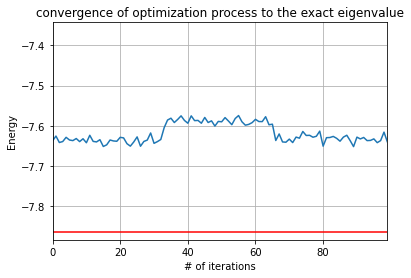

In [30]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

## H2 Molecule 4 qubits

In [31]:
H2_molecule_Hamiltonian_4_qubits =  -0.8105479805373279 * (I^I^I^I) \
                                    + 0.1721839326191554 * (I^I^I^Z) \
                                    - 0.22575349222402372 * (I^I^Z^I) \
                                    + 0.17218393261915543 * (I^Z^I^I) \
                                    - 0.2257534922240237 * (Z^I^I^I) \
                                    + 0.12091263261776627 * (I^I^Z^Z) \
                                    + 0.16892753870087907 * (I^Z^I^Z) \
                                    + 0.045232799946057826 * (Y^Y^Y^Y) \
                                    + 0.045232799946057826 * (X^X^Y^Y) \
                                    + 0.045232799946057826 * (Y^Y^X^X) \
                                    + 0.045232799946057826 * (X^X^X^X) \
                                    + 0.1661454325638241 * (Z^I^I^Z) \
                                    + 0.1661454325638241 * (I^Z^Z^I) \
                                    + 0.17464343068300453 * (Z^I^Z^I) \
                                    + 0.12091263261776627 * (Z^Z^I^I)

In [32]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits, "linear")

[0.19420816 5.07956838 3.43802631 5.53917668 5.31774875 5.32427632
 1.23429069 2.09246181 3.19697368 5.33931965 1.22705816 4.78096487
 1.38394264 0.25230533 1.60927395 0.79017356 3.70102104 5.538638
 1.12119935 5.64797185 3.72241792 2.36880373 0.51421607 2.08439117
 4.14707411 2.5481489  0.05162102 1.46771317 2.84785684 5.85706767
 5.70278482 0.93234611]
thetas:
[0.19420816 5.07956838 3.43802631 5.53917668 5.31774875 5.32427632
 1.23429069 2.09246181 3.19697368 5.33931965 1.22705816 4.78096487
 1.38394264 0.25230533 1.60927395 0.79017356 3.70102104 5.538638
 1.12119935 5.64797185 3.72241792 2.36880373 0.51421607 2.08439117
 4.14707411 2.5481489  0.05162102 1.46771317 2.84785684 5.85706767
 5.70278482 0.93234611]
-0.5279440678445616
thetas:
[0.19420817 5.07956838 3.43802631 5.53917668 5.31774875 5.32427632
 1.23429069 2.09246181 3.19697368 5.33931965 1.22705816 4.78096487
 1.38394264 0.25230533 1.60927395 0.79017356 3.70102104 5.538638
 1.12119935 5.64797185 3.72241792 2.36880373 0.5142

-0.5173981367899593
thetas:
[0.19420816 5.07956838 3.43802631 5.53917668 5.31774875 5.32427632
 1.23429069 2.09246181 3.19697368 5.33931965 1.22705816 4.78096487
 1.38394264 0.25230533 1.60927395 0.79017356 3.70102104 5.538638
 1.12119935 5.64797185 3.72241793 2.36880373 0.51421607 2.08439117
 4.14707411 2.5481489  0.05162102 1.46771317 2.84785684 5.85706767
 5.70278482 0.93234611]
-0.5430730569738561
thetas:
[0.19420816 5.07956838 3.43802631 5.53917668 5.31774875 5.32427632
 1.23429069 2.09246181 3.19697368 5.33931965 1.22705816 4.78096487
 1.38394264 0.25230533 1.60927395 0.79017356 3.70102104 5.538638
 1.12119935 5.64797185 3.72241792 2.36880375 0.51421607 2.08439117
 4.14707411 2.5481489  0.05162102 1.46771317 2.84785684 5.85706767
 5.70278482 0.93234611]
-0.5269938794538856
thetas:
[0.19420816 5.07956838 3.43802631 5.53917668 5.31774875 5.32427632
 1.23429069 2.09246181 3.19697368 5.33931965 1.22705816 4.78096487
 1.38394264 0.25230533 1.60927395 0.79017356 3.70102104 5.538638
 1.

-0.503016425702975
thetas:
[0.23868169 4.77067498 3.45243483 5.18653401 5.0934213  5.80220084
 1.09720645 2.04133041 3.1744853  5.1455263  1.15421214 4.90333962
 1.06431505 0.13359198 1.68044123 0.74629482 3.6599362  5.41056324
 0.99429855 5.51630956 3.9112981  2.35694096 0.52092025 2.15314453
 4.25160236 2.71297873 0.15427321 1.50014611 3.09264474 5.61303486
 5.84586066 1.11853511]
-0.4868355177431263
thetas:
[0.23868169 4.77067498 3.45243483 5.18653401 5.0934213  5.80220084
 1.09720645 2.04133041 3.1744853  5.14552629 1.15421216 4.90333962
 1.06431505 0.13359198 1.68044123 0.74629482 3.6599362  5.41056324
 0.99429855 5.51630956 3.9112981  2.35694096 0.52092025 2.15314453
 4.25160236 2.71297873 0.15427321 1.50014611 3.09264474 5.61303486
 5.84586066 1.11853511]
-0.49727302270664603
thetas:
[0.23868169 4.77067498 3.45243483 5.18653401 5.0934213  5.80220084
 1.09720645 2.04133041 3.1744853  5.14552629 1.15421214 4.90333963
 1.06431505 0.13359198 1.68044123 0.74629482 3.6599362  5.410563

-0.4811639579415492
thetas:
[0.23868169 4.77067498 3.45243483 5.18653401 5.0934213  5.80220084
 1.09720645 2.04133041 3.1744853  5.14552629 1.15421214 4.90333962
 1.06431505 0.13359198 1.68044123 0.74629482 3.6599362  5.41056324
 0.99429855 5.51630956 3.9112981  2.35694096 0.52092025 2.15314453
 4.25160236 2.71297873 0.15427321 1.50014611 3.09264474 5.61303486
 5.84586066 1.11853512]
-0.4886710697122669
thetas:
[0.20821354 4.98229319 3.44256377 5.42812419 5.24710466 5.47478195
 1.1911208  2.07635976 3.18989175 5.2782912  1.20411785 4.81950252
 1.2832871  0.21492071 1.6316856  0.77635549 3.68808281 5.49830533
 1.08123638 5.60650941 3.78189913 2.36506797 0.51632732 2.10604264
 4.17999163 2.6000563  0.08394774 1.47792679 2.92494424 5.78021806
 5.74784156 0.99097983]
-0.5398346133480385
thetas:
[0.20821356 4.98229319 3.44256377 5.42812419 5.24710466 5.47478195
 1.1911208  2.07635976 3.18989175 5.2782912  1.20411785 4.81950252
 1.2832871  0.21492071 1.6316856  0.77635549 3.68808281 5.498305

-0.5499408786886608
thetas:
[0.20821354 4.98229319 3.44256377 5.42812419 5.24710466 5.47478195
 1.1911208  2.07635976 3.18989175 5.2782912  1.20411785 4.81950252
 1.2832871  0.21492071 1.6316856  0.77635549 3.68808281 5.49830533
 1.08123638 5.60650941 3.78189915 2.36506797 0.51632732 2.10604264
 4.17999163 2.6000563  0.08394774 1.47792679 2.92494424 5.78021806
 5.74784156 0.99097983]
-0.5474914995170157
thetas:
[0.20821354 4.98229319 3.44256377 5.42812419 5.24710466 5.47478195
 1.1911208  2.07635976 3.18989175 5.2782912  1.20411785 4.81950252
 1.2832871  0.21492071 1.6316856  0.77635549 3.68808281 5.49830533
 1.08123638 5.60650941 3.78189913 2.36506798 0.51632732 2.10604264
 4.17999163 2.6000563  0.08394774 1.47792679 2.92494424 5.78021806
 5.74784156 0.99097983]
-0.5405516493271275
thetas:
[0.20821354 4.98229319 3.44256377 5.42812419 5.24710466 5.47478195
 1.1911208  2.07635976 3.18989175 5.2782912  1.20411785 4.81950252
 1.2832871  0.21492071 1.6316856  0.77635549 3.68808281 5.498305

-0.534982392274887
thetas:
[0.19780075 5.05461581 3.43919024 5.51069002 5.29962746 5.36288331
 1.22321696 2.08833139 3.19515705 5.32366494 1.22117363 4.79085037
 1.35812296 0.2427156  1.61502288 0.78662902 3.69770219 5.52829205
 1.11094824 5.6373361  3.73767575 2.36784545 0.51475764 2.0899451
 4.15551796 2.56146394 0.05991331 1.47033312 2.86763093 5.83735457
 5.71434256 0.94738655]
-0.5283294636411913
thetas:
[0.19780075 5.05461581 3.43919024 5.51069002 5.29962746 5.36288331
 1.22321696 2.08833139 3.19515705 5.32366493 1.22117364 4.79085037
 1.35812296 0.2427156  1.61502288 0.78662902 3.69770219 5.52829205
 1.11094824 5.6373361  3.73767575 2.36784545 0.51475764 2.0899451
 4.15551796 2.56146394 0.05991331 1.47033312 2.86763093 5.83735457
 5.71434256 0.94738655]
-0.5335278194816182
thetas:
[0.19780075 5.05461581 3.43919024 5.51069002 5.29962746 5.36288331
 1.22321696 2.08833139 3.19515705 5.32366493 1.22117363 4.79085038
 1.35812296 0.2427156  1.61502288 0.78662902 3.69770219 5.52829205


-0.5039053252705421
thetas:
[0.19780075 5.05461581 3.43919024 5.51069002 5.29962746 5.36288331
 1.22321696 2.08833139 3.19515705 5.32366493 1.22117363 4.79085037
 1.35812296 0.2427156  1.61502288 0.78662902 3.69770219 5.52829205
 1.11094824 5.6373361  3.73767575 2.36784545 0.51475764 2.0899451
 4.15551796 2.56146394 0.05991331 1.47033312 2.86763093 5.83735457
 5.71434256 0.94738657]
-0.5486768702523221
thetas:
[0.19518627 5.07277482 3.4383432  5.53142093 5.31281506 5.33478742
 1.23127577 2.09133727 3.19647909 5.33505751 1.22545605 4.78365629
 1.37691299 0.24969444 1.61083915 0.78920853 3.70011745 5.53582122
 1.11840839 5.64507617 3.726572   2.36854283 0.51436352 2.08590327
 4.14937303 2.55177404 0.05387867 1.46842647 2.85324052 5.8517006
 5.70593152 0.93644101]
-0.49348176015802153
thetas:
[0.19518629 5.07277482 3.4383432  5.53142093 5.31281506 5.33478742
 1.23127577 2.09133727 3.19647909 5.33505751 1.22545605 4.78365629
 1.37691299 0.24969444 1.61083915 0.78920853 3.70011745 5.5358212

-0.5328577400710404
thetas:
[0.19518627 5.07277482 3.4383432  5.53142093 5.31281506 5.33478742
 1.23127577 2.09133727 3.19647909 5.33505751 1.22545605 4.78365629
 1.37691299 0.24969444 1.61083915 0.78920853 3.70011745 5.53582122
 1.11840839 5.64507617 3.72657202 2.36854283 0.51436352 2.08590327
 4.14937303 2.55177404 0.05387867 1.46842647 2.85324052 5.8517006
 5.70593152 0.93644101]
-0.52029062722716
thetas:
[0.19518627 5.07277482 3.4383432  5.53142093 5.31281506 5.33478742
 1.23127577 2.09133727 3.19647909 5.33505751 1.22545605 4.78365629
 1.37691299 0.24969444 1.61083915 0.78920853 3.70011745 5.53582122
 1.11840839 5.64507617 3.726572   2.36854285 0.51436352 2.08590327
 4.14937303 2.55177404 0.05387867 1.46842647 2.85324052 5.8517006
 5.70593152 0.93644101]
-0.5074963050727413
thetas:
[0.19518627 5.07277482 3.4383432  5.53142093 5.31281506 5.33478742
 1.23127577 2.09133727 3.19647909 5.33505751 1.22545605 4.78365629
 1.37691299 0.24969444 1.61083915 0.78920853 3.70011745 5.53582122
 

-0.5145085777054831
thetas:
[0.19456116 5.07711659 3.43814067 5.53637764 5.31596819 5.32806976
 1.23320261 2.09205596 3.19679518 5.33778147 1.22647996 4.7819362
 1.38140565 0.25136306 1.60983883 0.78982528 3.70069494 5.53762142
 1.1201921  5.6469268  3.72391712 2.36870957 0.51426928 2.08493688
 4.14790379 2.54945721 0.0524358  1.4679706  2.8497998  5.8551307
 5.70392046 0.93382395]
-0.5176652171289864
thetas:
[0.19456116 5.07711659 3.43814067 5.53637764 5.31596819 5.32806976
 1.23320261 2.09205596 3.19679518 5.33778145 1.22647998 4.7819362
 1.38140565 0.25136306 1.60983883 0.78982528 3.70069494 5.53762142
 1.1201921  5.6469268  3.72391712 2.36870957 0.51426928 2.08493688
 4.14790379 2.54945721 0.0524358  1.4679706  2.8497998  5.8551307
 5.70392046 0.93382395]
-0.5429142067662454
thetas:
[0.19456116 5.07711659 3.43814067 5.53637764 5.31596819 5.32806976
 1.23320261 2.09205596 3.19679518 5.33778145 1.22647996 4.78193622
 1.38140565 0.25136306 1.60983883 0.78982528 3.70069494 5.53762142
 

-0.5177058476564327
thetas:
[0.19456116 5.07711659 3.43814067 5.53637764 5.31596819 5.32806976
 1.23320261 2.09205596 3.19679518 5.33778145 1.22647996 4.7819362
 1.38140565 0.25136306 1.60983883 0.78982528 3.70069494 5.53762142
 1.1201921  5.6469268  3.72391712 2.36870957 0.51426928 2.08493688
 4.14790379 2.54945721 0.0524358  1.4679706  2.8497998  5.8551307
 5.70392046 0.93382397]
-0.5433209309508713
thetas:
[0.19431543 5.07882332 3.43806106 5.5383261  5.31720767 5.32542908
 1.23396004 2.09233848 3.19691943 5.33885222 1.22688246 4.78126004
 1.38317169 0.25201899 1.6094456  0.79006773 3.70092194 5.53832908
 1.12089326 5.64765428 3.7228735  2.36877512 0.51423224 2.084557
 4.14732624 2.54854648 0.05186862 1.4677914  2.84844727 5.85647905
 5.70312992 0.9327952 ]
-0.524701228009835
thetas:
[0.19431544 5.07882332 3.43806106 5.5383261  5.31720767 5.32542908
 1.23396004 2.09233848 3.19691943 5.33885222 1.22688246 4.78126004
 1.38317169 0.25201899 1.6094456  0.79006773 3.70092194 5.53832908
 1

-0.5153465418925798
thetas:
[0.19431543 5.07882332 3.43806106 5.5383261  5.31720767 5.32542908
 1.23396004 2.09233848 3.19691943 5.33885222 1.22688246 4.78126004
 1.38317169 0.25201899 1.6094456  0.79006773 3.70092194 5.53832908
 1.12089326 5.64765428 3.72287351 2.36877512 0.51423224 2.084557
 4.14732624 2.54854648 0.05186862 1.4677914  2.84844727 5.85647905
 5.70312992 0.9327952 ]
-0.5147587877603326
thetas:
[0.19431543 5.07882332 3.43806106 5.5383261  5.31720767 5.32542908
 1.23396004 2.09233848 3.19691943 5.33885222 1.22688246 4.78126004
 1.38317169 0.25201899 1.6094456  0.79006773 3.70092194 5.53832908
 1.12089326 5.64765428 3.7228735  2.36877513 0.51423224 2.084557
 4.14732624 2.54854648 0.05186862 1.4677914  2.84844727 5.85647905
 5.70312992 0.9327952 ]
-0.5113103379619993
thetas:
[0.19431543 5.07882332 3.43806106 5.5383261  5.31720767 5.32542908
 1.23396004 2.09233848 3.19691943 5.33885222 1.22688246 4.78126004
 1.38317169 0.25201899 1.6094456  0.79006773 3.70092194 5.53832908
 

-0.5233108510660033
thetas:
[0.19423931 5.07935201 3.4380364  5.53892966 5.31759162 5.32461109
 1.23419467 2.092426   3.19695792 5.33918392 1.22700714 4.78105059
 1.38371875 0.25222217 1.6093238  0.79014283 3.70099226 5.53854828
 1.12111046 5.64787963 3.72255022 2.36879542 0.51422077 2.08443932
 4.14714733 2.54826436 0.05169292 1.46773589 2.84802831 5.85689673
 5.70288504 0.93247653]
-0.5094783894092105
thetas:
[0.19423931 5.07935201 3.4380364  5.53892966 5.31759162 5.32461109
 1.23419467 2.092426   3.19695792 5.33918391 1.22700715 4.78105059
 1.38371875 0.25222217 1.6093238  0.79014283 3.70099226 5.53854828
 1.12111046 5.64787963 3.72255022 2.36879542 0.51422077 2.08443932
 4.14714733 2.54826436 0.05169292 1.46773589 2.84802831 5.85689673
 5.70288504 0.93247653]
-0.5099247723514754
thetas:
[0.19423931 5.07935201 3.4380364  5.53892966 5.31759162 5.32461109
 1.23419467 2.092426   3.19695792 5.33918391 1.22700714 4.78105061
 1.38371875 0.25222217 1.6093238  0.79014283 3.70099226 5.538548

-0.5436196704942277
thetas:
[0.19423931 5.07935201 3.4380364  5.53892966 5.31759162 5.32461109
 1.23419467 2.092426   3.19695792 5.33918391 1.22700714 4.78105059
 1.38371875 0.25222217 1.6093238  0.79014283 3.70099226 5.53854828
 1.12111046 5.64787963 3.72255022 2.36879542 0.51422077 2.08443932
 4.14714733 2.54826436 0.05169292 1.46773589 2.84802831 5.85689673
 5.70288504 0.93247654]
-0.5025775780075361
thetas:
[0.19422033 5.07948387 3.43803025 5.5390802  5.31768738 5.32440707
 1.23425319 2.09244782 3.19696752 5.33926663 1.22703824 4.78099835
 1.38385519 0.25227285 1.60929342 0.79016156 3.7010098  5.53860296
 1.12116463 5.64793583 3.72246959 2.36880049 0.5142179  2.08440997
 4.14710271 2.548194   0.0516491  1.46772204 2.84792381 5.8570009
 5.70282396 0.93239705]
-0.5143081756447507
thetas:
[0.19422034 5.07948387 3.43803025 5.5390802  5.31768738 5.32440707
 1.23425319 2.09244782 3.19696752 5.33926663 1.22703824 4.78099835
 1.38385519 0.25227285 1.60929342 0.79016156 3.7010098  5.5386029

-0.5101390942664067
thetas:
[0.19422033 5.07948387 3.43803025 5.5390802  5.31768738 5.32440707
 1.23425319 2.09244782 3.19696752 5.33926663 1.22703824 4.78099835
 1.38385519 0.25227285 1.60929342 0.79016156 3.7010098  5.53860296
 1.12116463 5.64793583 3.7224696  2.36880049 0.5142179  2.08440997
 4.14710271 2.548194   0.0516491  1.46772204 2.84792381 5.8570009
 5.70282396 0.93239705]
-0.5327087003728597
thetas:
[0.19422033 5.07948387 3.43803025 5.5390802  5.31768738 5.32440707
 1.23425319 2.09244782 3.19696752 5.33926663 1.22703824 4.78099835
 1.38385519 0.25227285 1.60929342 0.79016156 3.7010098  5.53860296
 1.12116463 5.64793583 3.72246959 2.3688005  0.5142179  2.08440997
 4.14710271 2.548194   0.0516491  1.46772204 2.84792381 5.8570009
 5.70282396 0.93239705]
-0.5458937946086606
thetas:
[0.19422033 5.07948387 3.43803025 5.5390802  5.31768738 5.32440707
 1.23425319 2.09244782 3.19696752 5.33926663 1.22703824 4.78099835
 1.38385519 0.25227285 1.60929342 0.79016156 3.7010098  5.53860296

-0.5253040902545725
thetas:
[0.19421164 5.07954423 3.43802743 5.53914911 5.31773121 5.32431368
 1.23427997 2.09245781 3.19697192 5.33930452 1.22705247 4.78097444
 1.38391765 0.25229605 1.60927951 0.79017013 3.70101783 5.53862798
 1.12118943 5.64796156 3.72243268 2.3688028  0.51421659 2.08439654
 4.14708229 2.54816179 0.05162904 1.4677157  2.84787598 5.85704859
 5.70279601 0.93236067]
-0.5461893234821773
thetas:
[0.19421164 5.07954423 3.43802743 5.53914911 5.31773121 5.32431368
 1.23427997 2.09245781 3.19697192 5.3393045  1.22705248 4.78097444
 1.38391765 0.25229605 1.60927951 0.79017013 3.70101783 5.53862798
 1.12118943 5.64796156 3.72243268 2.3688028  0.51421659 2.08439654
 4.14708229 2.54816179 0.05162904 1.4677157  2.84787598 5.85704859
 5.70279601 0.93236067]
-0.5204822546075278
thetas:
[0.19421164 5.07954423 3.43802743 5.53914911 5.31773121 5.32431368
 1.23427997 2.09245781 3.19697192 5.3393045  1.22705247 4.78097445
 1.38391765 0.25229605 1.60927951 0.79017013 3.70101783 5.538627

-0.5325634297332039
thetas:
[0.19421164 5.07954423 3.43802743 5.53914911 5.31773121 5.32431368
 1.23427997 2.09245781 3.19697192 5.3393045  1.22705247 4.78097444
 1.38391765 0.25229605 1.60927951 0.79017013 3.70101783 5.53862798
 1.12118943 5.64796156 3.72243268 2.3688028  0.51421659 2.08439654
 4.14708229 2.54816179 0.05162904 1.4677157  2.84787598 5.85704859
 5.70279601 0.93236068]
-0.5265524895663107
thetas:
[0.19420922 5.07956098 3.43802665 5.53916824 5.31774338 5.32428776
 1.23428741 2.09246059 3.19697314 5.33931501 1.22705642 4.7809678
 1.38393498 0.25230249 1.60927565 0.79017251 3.70102006 5.53863493
 1.12119631 5.6479687  3.72242244 2.36880345 0.51421623 2.08439281
 4.14707662 2.54815285 0.05162347 1.46771394 2.8478627  5.85706182
 5.70278825 0.93235057]
-0.5169164840198432
thetas:
[0.19420924 5.07956098 3.43802665 5.53916824 5.31774338 5.32428776
 1.23428741 2.09246059 3.19697314 5.33931501 1.22705642 4.7809678
 1.38393498 0.25230249 1.60927565 0.79017251 3.70102006 5.53863493

-0.5660423208385197
thetas:
[0.19420922 5.07956098 3.43802665 5.53916824 5.31774338 5.32428776
 1.23428741 2.09246059 3.19697314 5.33931501 1.22705642 4.7809678
 1.38393498 0.25230249 1.60927565 0.79017251 3.70102006 5.53863493
 1.12119631 5.6479687  3.72242245 2.36880345 0.51421623 2.08439281
 4.14707662 2.54815285 0.05162347 1.46771394 2.8478627  5.85706182
 5.70278825 0.93235057]
-0.5101068693869973
thetas:
[0.19420922 5.07956098 3.43802665 5.53916824 5.31774338 5.32428776
 1.23428741 2.09246059 3.19697314 5.33931501 1.22705642 4.7809678
 1.38393498 0.25230249 1.60927565 0.79017251 3.70102006 5.53863493
 1.12119631 5.6479687  3.72242244 2.36880346 0.51421623 2.08439281
 4.14707662 2.54815285 0.05162347 1.46771394 2.8478627  5.85706182
 5.70278825 0.93235057]
-0.5353345010659171
thetas:
[0.19420922 5.07956098 3.43802665 5.53916824 5.31774338 5.32428776
 1.23428741 2.09246059 3.19697314 5.33931501 1.22705642 4.7809678
 1.38393498 0.25230249 1.60927565 0.79017251 3.70102006 5.53863493


-0.5334269027085244
thetas:
[0.19420858 5.07956544 3.43802645 5.53917332 5.31774661 5.32428087
 1.23428939 2.09246132 3.19697346 5.33931782 1.22705747 4.78096604
 1.38393959 0.2523042  1.60927462 0.79017314 3.70102065 5.53863678
 1.12119814 5.6479706  3.72241971 2.36880362 0.51421613 2.08439182
 4.14707511 2.54815047 0.05162199 1.46771348 2.84785917 5.85706534
 5.70278618 0.93234788]
-0.5190877124893333
thetas:
[0.19420858 5.07956544 3.43802645 5.53917332 5.31774661 5.32428087
 1.23428939 2.09246132 3.19697346 5.33931781 1.22705749 4.78096604
 1.38393959 0.2523042  1.60927462 0.79017314 3.70102065 5.53863678
 1.12119814 5.6479706  3.72241971 2.36880362 0.51421613 2.08439182
 4.14707511 2.54815047 0.05162199 1.46771348 2.84785917 5.85706534
 5.70278618 0.93234788]
-0.49926651448834025
thetas:
[0.19420858 5.07956544 3.43802645 5.53917332 5.31774661 5.32428087
 1.23428939 2.09246132 3.19697346 5.33931781 1.22705747 4.78096605
 1.38393959 0.2523042  1.60927462 0.79017314 3.70102065 5.53863

-0.5169700575381868
thetas:
[0.19420858 5.07956544 3.43802645 5.53917332 5.31774661 5.32428087
 1.23428939 2.09246132 3.19697346 5.33931781 1.22705747 4.78096604
 1.38393959 0.2523042  1.60927462 0.79017314 3.70102065 5.53863678
 1.12119814 5.6479706  3.72241971 2.36880362 0.51421613 2.08439182
 4.14707511 2.54815047 0.05162199 1.46771348 2.84785917 5.85706534
 5.70278618 0.9323479 ]
-0.5125658178352073
thetas:
[0.19420831 5.07956734 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394156 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5322008791839631
thetas:
[0.19420832 5.07956734 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394156 0.25230493 1.60927419 0.79017341 3.7010209  5.5386375

-0.5535212090039662
thetas:
[0.19420831 5.07956734 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394156 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241857 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.51172778663463
thetas:
[0.19420831 5.07956734 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394156 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880371 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5417833080828759
thetas:
[0.19420831 5.07956734 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394156 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 

-0.5212745822433924
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.33931901 1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5403038692706136
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705793 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5391015071921781
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.7809653
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756


-0.5039186923210304
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234676]
-0.5118126895564888
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427794
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017342 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5278918230325329
thetas:
[0.19420832 5.07956733 3.43802636 5.53917549 5.31774799 5.32427794
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017342 3.7010209  5.53863756

-0.5287148266684257
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427794
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017342 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241857 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5060324593448494
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427794
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017342 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880371 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5254799583466121
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427794
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017342 3.7010209  5.53863756

-0.539123433458143
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.33931901 1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5156847372412842
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705793 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5172114399986452
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.7809653
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 

-0.49807813795358075
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234676]
-0.5447469843691166
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5377780299118999
thetas:
[0.19420832 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.5386375

-0.5346380972122406
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241857 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5154732383166796
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880371 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5391360834571255
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756

-0.525256815251574
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427794
 1.23429023 2.09246164 3.1969736  5.33931901 1.22705792 4.78096528
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5199627993720208
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427794
 1.23429023 2.09246164 3.1969736  5.339319   1.22705793 4.78096528
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5246316615170812
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427794
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.7809653
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 

-0.5225543797844675
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427794
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096528
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234676]
-0.5245770420005931
thetas:
[0.19420831 5.07956733 3.43802635 5.53917548 5.31774799 5.32427794
 1.23429022 2.09246164 3.1969736  5.33931899 1.22705792 4.78096528
 1.38394155 0.25230493 1.60927418 0.79017342 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707446 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.533507047644388
thetas:
[0.19420832 5.07956733 3.43802635 5.53917548 5.31774799 5.32427794
 1.23429022 2.09246164 3.1969736  5.33931899 1.22705792 4.78096528
 1.38394155 0.25230493 1.60927418 0.79017342 3.7010209  5.53863756


-0.5069690999960716
thetas:
[0.19420831 5.07956733 3.43802635 5.53917548 5.31774799 5.32427794
 1.23429022 2.09246164 3.1969736  5.33931899 1.22705792 4.78096528
 1.38394155 0.25230493 1.60927418 0.79017342 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241857 2.36880369 0.51421609 2.0843914
 4.14707446 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.526080310284668
thetas:
[0.19420831 5.07956733 3.43802635 5.53917548 5.31774799 5.32427794
 1.23429022 2.09246164 3.1969736  5.33931899 1.22705792 4.78096528
 1.38394155 0.25230493 1.60927418 0.79017342 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880371 0.51421609 2.0843914
 4.14707446 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5134168026225266
thetas:
[0.19420831 5.07956733 3.43802635 5.53917548 5.31774799 5.32427794
 1.23429022 2.09246164 3.1969736  5.33931899 1.22705792 4.78096528
 1.38394155 0.25230493 1.60927418 0.79017342 3.7010209  5.53863756


-0.5220870873615262
thetas:
[0.19420831 5.07956733 3.43802636 5.53917548 5.31774799 5.32427794
 1.23429023 2.09246164 3.1969736  5.33931901 1.22705792 4.78096528
 1.38394155 0.25230493 1.60927419 0.79017342 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5018210844092009
thetas:
[0.19420831 5.07956733 3.43802636 5.53917548 5.31774799 5.32427794
 1.23429023 2.09246164 3.1969736  5.339319   1.22705793 4.78096528
 1.38394155 0.25230493 1.60927419 0.79017342 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5344186388728195
thetas:
[0.19420831 5.07956733 3.43802636 5.53917548 5.31774799 5.32427794
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.7809653
 1.38394155 0.25230493 1.60927419 0.79017342 3.7010209  5.53863756


-0.545367062715358
thetas:
[0.19420831 5.07956733 3.43802636 5.53917548 5.31774799 5.32427794
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096528
 1.38394155 0.25230493 1.60927419 0.79017342 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234676]
-0.5698546418175928
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427794
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096528
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5210497128001178
thetas:
[0.19420832 5.07956733 3.43802636 5.53917549 5.31774799 5.32427794
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096528
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756


-0.5009217529938212
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427794
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096528
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241857 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5333386866776895
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427794
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096528
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880371 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.535376155406134
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427794
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096528
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756


-0.5232353358401697
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427794
 1.23429023 2.09246164 3.1969736  5.33931901 1.22705792 4.78096528
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5588765859512846
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427794
 1.23429023 2.09246164 3.1969736  5.339319   1.22705793 4.78096528
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5222487016704691
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427794
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.7809653
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756


-0.4880960819085351
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427794
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096528
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234676]
-0.5079048217681525
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427794
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096528
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5264498642588109
thetas:
[0.19420832 5.07956733 3.43802636 5.53917549 5.31774799 5.32427794
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096528
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756

-0.525140509084493
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427794
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096528
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241857 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5424891102232525
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427794
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096528
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880371 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5330742611686871
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427794
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096528
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756


-0.4947786547167385
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.19697362 5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5436511294815926
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.33931901 1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5731576772846457
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705793 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756

-0.5159600230950301
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.70278532 0.93234674]
-0.5339279482129465
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234676]
-0.543861121516042
thetas:
[0.19420831 5.07956733 3.43802636 5.53917548 5.31774799 5.32427794
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096528
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756


-0.5082707472442408
thetas:
[0.19420831 5.07956733 3.43802636 5.53917548 5.31774799 5.32427794
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096528
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797142 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5244430237110117
thetas:
[0.19420831 5.07956733 3.43802636 5.53917548 5.31774799 5.32427794
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096528
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241857 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5590491480337964
thetas:
[0.19420831 5.07956733 3.43802636 5.53917548 5.31774799 5.32427794
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096528
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756

-0.4968267446469418
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.19697362 5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5131558151624632
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.33931901 1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5233396567792419
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705793 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756

-0.5026126055703082
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.70278532 0.93234674]
-0.5300447312048194
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234676]
-0.5244685323771613
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756

-0.5259285506076733
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797142 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5094181821790373
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241857 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5273908356225606
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756

-0.5202810639249525
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.19697362 5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5086037219026087
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.33931901 1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5266513193509539
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705793 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756

-0.5422005438143731
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.70278532 0.93234674]
-0.5340038433144633
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234676]
-0.5304603809436096
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756

-0.5208898474037645
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797142 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5217156043668909
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241857 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5369996061444072
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756

-0.5092572237298522
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.19697362 5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5374880625098434
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.33931901 1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5343135872183391
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705793 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756

-0.5159683427822376
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.70278532 0.93234674]
-0.5564506989429476
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234676]
-0.5265066424077185
thetas:
[0.19420831 5.07956733 3.43802636 5.53917548 5.31774799 5.32427794
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096528
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756

-0.552948366668363
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119894 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5402085569129467
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797142 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5031665334498109
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756


-0.5034946578116034
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.535469478605024
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5572545986792135
thetas:
[0.19420832 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756


-0.5114278498138738
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241857 2.36880369 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.5168056426897807
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756
 1.12119892 5.64797141 3.72241855 2.36880371 0.51421609 2.0843914
 4.14707447 2.54814946 0.05162136 1.46771328 2.84785767 5.85706684
 5.7027853  0.93234674]
-0.519231417578863
thetas:
[0.19420831 5.07956733 3.43802636 5.53917549 5.31774799 5.32427793
 1.23429023 2.09246164 3.1969736  5.339319   1.22705792 4.78096529
 1.38394155 0.25230493 1.60927419 0.79017341 3.7010209  5.53863756


[(0.2142782384194731+0j), (-1.942890293094024e-16+0j), (-0.2249112528308709+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.47189600728114245+0j), (-0.47189600728114256+0j), (-0.8827221502448648+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-1.244584549813327+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.2563390730032498+0j), (-1.25633907300325+0j), (-1.8572750302023793+0j)]
Exact Eigenvalue:
(-1.8572750302023793+0j)

Approximated Eigenvalue:
-0.5522417171997366

Approximation Error
0.7026602370573188


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


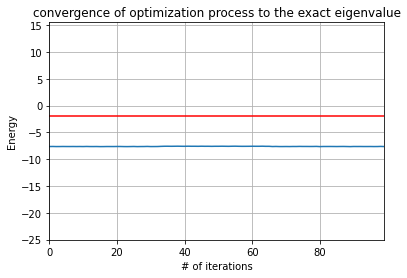

In [33]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

In [34]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits, "full")

[0.93276795 4.12531077 2.45657237 5.59275992 6.20382503 3.74758947
 0.08975315 0.17949423 5.01167576 4.53113573 1.10016774 0.71365869
 1.84035312 1.05116839 3.56027223 3.84754127 0.49508298 2.72860015
 0.86479004 1.04880741 3.60942152 3.20227641 4.340192   1.13012898
 5.18323819 1.64038366 3.2549044  4.51374389 0.43043085 4.75004633
 1.12931302 4.85152446]
thetas:
[0.93276795 4.12531077 2.45657237 5.59275992 6.20382503 3.74758947
 0.08975315 0.17949423 5.01167576 4.53113573 1.10016774 0.71365869
 1.84035312 1.05116839 3.56027223 3.84754127 0.49508298 2.72860015
 0.86479004 1.04880741 3.60942152 3.20227641 4.340192   1.13012898
 5.18323819 1.64038366 3.2549044  4.51374389 0.43043085 4.75004633
 1.12931302 4.85152446]
-0.6037047323668041
thetas:
[0.93276797 4.12531077 2.45657237 5.59275992 6.20382503 3.74758947
 0.08975315 0.17949423 5.01167576 4.53113573 1.10016774 0.71365869
 1.84035312 1.05116839 3.56027223 3.84754127 0.49508298 2.72860015
 0.86479004 1.04880741 3.60942152 3.20227641 

-0.5968107373194548
thetas:
[0.93276795 4.12531077 2.45657237 5.59275992 6.20382503 3.74758947
 0.08975315 0.17949423 5.01167576 4.53113573 1.10016774 0.71365869
 1.84035312 1.05116839 3.56027223 3.84754127 0.49508298 2.72860015
 0.86479004 1.04880741 3.60942153 3.20227641 4.340192   1.13012898
 5.18323819 1.64038366 3.2549044  4.51374389 0.43043085 4.75004633
 1.12931302 4.85152446]
-0.60888682527348
thetas:
[0.93276795 4.12531077 2.45657237 5.59275992 6.20382503 3.74758947
 0.08975315 0.17949423 5.01167576 4.53113573 1.10016774 0.71365869
 1.84035312 1.05116839 3.56027223 3.84754127 0.49508298 2.72860015
 0.86479004 1.04880741 3.60942152 3.20227642 4.340192   1.13012898
 5.18323819 1.64038366 3.2549044  4.51374389 0.43043085 4.75004633
 1.12931302 4.85152446]
-0.6056204923428063
thetas:
[0.93276795 4.12531077 2.45657237 5.59275992 6.20382503 3.74758947
 0.08975315 0.17949423 5.01167576 4.53113573 1.10016774 0.71365869
 1.84035312 1.05116839 3.56027223 3.84754127 0.49508298 2.72860015

-0.513650257364699
thetas:
[0.67051525 4.25339322 2.18888976 5.3438409  6.24652434 3.67435723
 0.02446013 0.04643062 5.11292971 4.66157283 0.99386371 0.46901207
 1.92633966 0.96717798 3.271781   3.6800352  0.25442136 2.62161301
 0.67441998 0.99418982 3.65047658 3.21745399 3.86390714 0.92688442
 5.19490481 1.5175781  3.04930318 4.511621   0.23031604 4.54039883
 1.03509165 4.98924602]
-0.525559055338463
thetas:
[0.67051525 4.25339322 2.18888976 5.3438409  6.24652434 3.67435723
 0.02446013 0.04643062 5.11292971 4.66157282 0.99386372 0.46901207
 1.92633966 0.96717798 3.271781   3.6800352  0.25442136 2.62161301
 0.67441998 0.99418982 3.65047658 3.21745399 3.86390714 0.92688442
 5.19490481 1.5175781  3.04930318 4.511621   0.23031604 4.54039883
 1.03509165 4.98924602]
-0.5053746965522609
thetas:
[0.67051525 4.25339322 2.18888976 5.3438409  6.24652434 3.67435723
 0.02446013 0.04643062 5.11292971 4.66157282 0.99386371 0.46901209
 1.92633966 0.96717798 3.271781   3.6800352  0.25442136 2.62161301

-0.5091062029235299
thetas:
[0.67051525 4.25339322 2.18888976 5.3438409  6.24652434 3.67435723
 0.02446013 0.04643062 5.11292971 4.66157282 0.99386371 0.46901207
 1.92633966 0.96717798 3.271781   3.6800352  0.25442136 2.62161301
 0.67441998 0.99418982 3.65047658 3.21745399 3.86390714 0.92688442
 5.19490481 1.5175781  3.04930318 4.511621   0.23031604 4.54039883
 1.03509165 4.98924603]
-0.5253603940950858
thetas:
[0.799217   4.19053615 2.32025627 5.46599908 6.22556945 3.7102963
 0.05650299 0.11173222 5.06323885 4.5975602  1.04603291 0.58907355
 1.88414136 1.00839667 3.41335943 3.76223959 0.37252718 2.67411745
 0.76784498 1.02099366 3.63032862 3.21000552 4.09764618 1.02662765
 5.18917936 1.57784551 3.15020295 4.51266282 0.32852333 4.64328433
 1.08133123 4.92165851]
-0.5741164584555549
thetas:
[0.79921701 4.19053615 2.32025627 5.46599908 6.22556945 3.7102963
 0.05650299 0.11173222 5.06323885 4.5975602  1.04603291 0.58907355
 1.88414136 1.00839667 3.41335943 3.76223959 0.37252718 2.67411745

-0.5815947464888904
thetas:
[0.799217   4.19053615 2.32025627 5.46599908 6.22556945 3.7102963
 0.05650299 0.11173222 5.06323885 4.5975602  1.04603291 0.58907355
 1.88414136 1.00839667 3.41335943 3.76223959 0.37252718 2.67411745
 0.76784498 1.02099366 3.63032863 3.21000552 4.09764618 1.02662765
 5.18917936 1.57784551 3.15020295 4.51266282 0.32852333 4.64328433
 1.08133123 4.92165851]
-0.5719440606945506
thetas:
[0.799217   4.19053615 2.32025627 5.46599908 6.22556945 3.7102963
 0.05650299 0.11173222 5.06323885 4.5975602  1.04603291 0.58907355
 1.88414136 1.00839667 3.41335943 3.76223959 0.37252718 2.67411745
 0.76784498 1.02099366 3.63032862 3.21000554 4.09764618 1.02662765
 5.18917936 1.57784551 3.15020295 4.51266282 0.32852333 4.64328433
 1.08133123 4.92165851]
-0.5841587893597886
thetas:
[0.799217   4.19053615 2.32025627 5.46599908 6.22556945 3.7102963
 0.05650299 0.11173222 5.06323885 4.5975602  1.04603291 0.58907355
 1.88414136 1.00839667 3.41335943 3.76223959 0.37252718 2.67411745


-0.5944656347873584
thetas:
[0.8863611  4.14797556 2.40920468 5.54871253 6.21138087 3.73463068
 0.07819924 0.155948   5.02959312 4.5542172  1.08135674 0.67036732
 1.85556884 1.03630589 3.50922235 3.81790028 0.45249677 2.70966827
 0.83110316 1.03914257 3.61668641 3.20496215 4.25591115 1.0941639
 5.18530266 1.61865264 3.2185223  4.51336824 0.39501959 4.71294822
 1.11264011 4.87589493]
-0.6141803118944291
thetas:
[0.8863611  4.14797556 2.40920468 5.54871253 6.21138087 3.73463068
 0.07819924 0.155948   5.02959312 4.55421719 1.08135676 0.67036732
 1.85556884 1.03630589 3.50922235 3.81790028 0.45249677 2.70966827
 0.83110316 1.03914257 3.61668641 3.20496215 4.25591115 1.0941639
 5.18530266 1.61865264 3.2185223  4.51336824 0.39501959 4.71294822
 1.11264011 4.87589493]
-0.6141681207422202
thetas:
[0.8863611  4.14797556 2.40920468 5.54871253 6.21138087 3.73463068
 0.07819924 0.155948   5.02959312 4.55421719 1.08135674 0.67036733
 1.85556884 1.03630589 3.50922235 3.81790028 0.45249677 2.70966827

-0.5934936448249352
thetas:
[0.8863611  4.14797556 2.40920468 5.54871253 6.21138087 3.73463068
 0.07819924 0.155948   5.02959312 4.55421719 1.08135674 0.67036732
 1.85556884 1.03630589 3.50922235 3.81790028 0.45249677 2.70966827
 0.83110316 1.03914257 3.61668641 3.20496215 4.25591115 1.0941639
 5.18530266 1.61865264 3.2185223  4.51336824 0.39501959 4.71294822
 1.11264011 4.87589495]
-0.6248369968659235
thetas:
[0.91598248 4.13350868 2.43943937 5.57682787 6.20655799 3.74290225
 0.08557407 0.1709775  5.01815651 4.53948435 1.09336376 0.6980001
 1.84585668 1.04579258 3.54180736 3.83682005 0.47967945 2.72175245
 0.85260541 1.04531161 3.61204925 3.20324785 4.30970741 1.11712032
 5.18398492 1.6325235  3.24174491 4.51360802 0.41762252 4.73662786
 1.12328239 4.86033932]
-0.5812896538093938
thetas:
[0.9159825  4.13350868 2.43943937 5.57682787 6.20655799 3.74290225
 0.08557407 0.1709775  5.01815651 4.53948435 1.09336376 0.6980001
 1.84585668 1.04579258 3.54180736 3.83682005 0.47967945 2.72175245


-0.6188476213295118
thetas:
[0.91598248 4.13350868 2.43943937 5.57682787 6.20655799 3.74290225
 0.08557407 0.1709775  5.01815651 4.53948435 1.09336376 0.6980001
 1.84585668 1.04579258 3.54180736 3.83682005 0.47967945 2.72175245
 0.85260541 1.04531161 3.61204926 3.20324785 4.30970741 1.11712032
 5.18398492 1.6325235  3.24174491 4.51360802 0.41762252 4.73662786
 1.12328239 4.86033932]
-0.5922542205411618
thetas:
[0.91598248 4.13350868 2.43943937 5.57682787 6.20655799 3.74290225
 0.08557407 0.1709775  5.01815651 4.53948435 1.09336376 0.6980001
 1.84585668 1.04579258 3.54180736 3.83682005 0.47967945 2.72175245
 0.85260541 1.04531161 3.61204925 3.20324786 4.30970741 1.11712032
 5.18398492 1.6325235  3.24174491 4.51360802 0.41762252 4.73662786
 1.12328239 4.86033932]
-0.6064878983043687
thetas:
[0.91598248 4.13350868 2.43943937 5.57682787 6.20655799 3.74290225
 0.08557407 0.1709775  5.01815651 4.53948435 1.09336376 0.6980001
 1.84585668 1.04579258 3.54180736 3.83682005 0.47967945 2.72175245


-0.5813355448926522
thetas:
[0.92583556 4.1286965  2.44949645 5.58617999 6.20495374 3.74565365
 0.08802719 0.17597683 5.01435231 4.53458372 1.0973577  0.70719169
 1.84262609 1.04894818 3.55264624 3.84311341 0.48872132 2.72577205
 0.85975779 1.04736364 3.61050677 3.20267761 4.32760187 1.12475641
 5.18354659 1.63713741 3.24946953 4.51368778 0.42514101 4.74450451
 1.12682237 4.85516499]
-0.5949322334453226
thetas:
[0.92583556 4.1286965  2.44949645 5.58617999 6.20495374 3.74565365
 0.08802719 0.17597683 5.01435231 4.53458371 1.09735771 0.70719169
 1.84262609 1.04894818 3.55264624 3.84311341 0.48872132 2.72577205
 0.85975779 1.04736364 3.61050677 3.20267761 4.32760187 1.12475641
 5.18354659 1.63713741 3.24946953 4.51368778 0.42514101 4.74450451
 1.12682237 4.85516499]
-0.5996785082874849
thetas:
[0.92583556 4.1286965  2.44949645 5.58617999 6.20495374 3.74565365
 0.08802719 0.17597683 5.01435231 4.53458371 1.0973577  0.70719171
 1.84262609 1.04894818 3.55264624 3.84311341 0.48872132 2.725772

-0.582021073799216
thetas:
[0.92583556 4.1286965  2.44949645 5.58617999 6.20495374 3.74565365
 0.08802719 0.17597683 5.01435231 4.53458371 1.0973577  0.70719169
 1.84262609 1.04894818 3.55264624 3.84311341 0.48872132 2.72577205
 0.85975779 1.04736364 3.61050677 3.20267761 4.32760187 1.12475641
 5.18354659 1.63713741 3.24946953 4.51368778 0.42514101 4.74450451
 1.12682237 4.85516501]
-0.5953948066835663
thetas:
[0.93144276 4.12595799 2.45521974 5.5915021  6.20404079 3.74721942
 0.08942322 0.17882185 5.01218741 4.53179484 1.09963057 0.71242246
 1.84078762 1.05074397 3.55881445 3.84669484 0.49386689 2.72805953
 0.86382808 1.04853142 3.60962898 3.2023531  4.33778527 1.12910196
 5.18329715 1.63976311 3.25386547 4.51373317 0.42941965 4.74898696
 1.12883691 4.85222038]
-0.6097273614036538
thetas:
[0.93144277 4.12595799 2.45521974 5.5915021  6.20404079 3.74721942
 0.08942322 0.17882185 5.01218741 4.53179484 1.09963057 0.71242246
 1.84078762 1.05074397 3.55881445 3.84669484 0.49386689 2.7280595

-0.5862270198251375
thetas:
[0.93144276 4.12595799 2.45521974 5.5915021  6.20404079 3.74721942
 0.08942322 0.17882185 5.01218741 4.53179484 1.09963057 0.71242246
 1.84078762 1.05074397 3.55881445 3.84669484 0.49386689 2.72805953
 0.86382808 1.04853142 3.60962899 3.2023531  4.33778527 1.12910196
 5.18329715 1.63976311 3.25386547 4.51373317 0.42941965 4.74898696
 1.12883691 4.85222038]
-0.5982485213099659
thetas:
[0.93144276 4.12595799 2.45521974 5.5915021  6.20404079 3.74721942
 0.08942322 0.17882185 5.01218741 4.53179484 1.09963057 0.71242246
 1.84078762 1.05074397 3.55881445 3.84669484 0.49386689 2.72805953
 0.86382808 1.04853142 3.60962898 3.20235312 4.33778527 1.12910196
 5.18329715 1.63976311 3.25386547 4.51373317 0.42941965 4.74898696
 1.12883691 4.85222038]
-0.5906335816657771
thetas:
[0.93144276 4.12595799 2.45521974 5.5915021  6.20404079 3.74721942
 0.08942322 0.17882185 5.01218741 4.53179484 1.09963057 0.71242246
 1.84078762 1.05074397 3.55881445 3.84669484 0.49386689 2.728059

-0.5712525213119111
thetas:
[0.93240037 4.12549029 2.45619719 5.59241103 6.20388488 3.74748683
 0.08966163 0.17930773 5.01181768 4.53131857 1.10001874 0.71331579
 1.84047364 1.05105066 3.55986787 3.84730649 0.49474566 2.7284502
 0.86452321 1.04873085 3.60947906 3.20229768 4.33952443 1.12984411
 5.18325455 1.64021153 3.25461622 4.51374092 0.43015037 4.74975249
 1.12918096 4.85171749]
-0.6044476666304104
thetas:
[0.93240037 4.12549029 2.45619719 5.59241103 6.20388488 3.74748683
 0.08966163 0.17930773 5.01181768 4.53131855 1.10001876 0.71331579
 1.84047364 1.05105066 3.55986787 3.84730649 0.49474566 2.7284502
 0.86452321 1.04873085 3.60947906 3.20229768 4.33952443 1.12984411
 5.18325455 1.64021153 3.25461622 4.51374092 0.43015037 4.74975249
 1.12918096 4.85171749]
-0.5765590656784365
thetas:
[0.93240037 4.12549029 2.45619719 5.59241103 6.20388488 3.74748683
 0.08966163 0.17930773 5.01181768 4.53131855 1.10001874 0.7133158
 1.84047364 1.05105066 3.55986787 3.84730649 0.49474566 2.7284502
 

-0.5653732894924489
thetas:
[0.93240037 4.12549029 2.45619719 5.59241103 6.20388488 3.74748683
 0.08966163 0.17930773 5.01181768 4.53131855 1.10001874 0.71331579
 1.84047364 1.05105066 3.55986787 3.84730649 0.49474566 2.7284502
 0.86452321 1.04873085 3.60947906 3.20229768 4.33952443 1.12984411
 5.18325455 1.64021153 3.25461622 4.51374092 0.43015037 4.74975249
 1.12918096 4.8517175 ]
-0.5881704198132632
thetas:
[0.93260639 4.12538968 2.45640747 5.59260657 6.20385133 3.74754436
 0.08971292 0.17941226 5.01173814 4.53121609 1.10010225 0.71350797
 1.84040609 1.05111664 3.5600945  3.84743808 0.49493472 2.72853424
 0.86467276 1.04877376 3.60944681 3.20228576 4.33989858 1.13000377
 5.18324538 1.640308   3.25477774 4.51374259 0.43030757 4.74991718
 1.12925497 4.8516093 ]
-0.5839944307181614
thetas:
[0.9326064  4.12538968 2.45640747 5.59260657 6.20385133 3.74754436
 0.08971292 0.17941226 5.01173814 4.53121609 1.10010225 0.71350797
 1.84040609 1.05111664 3.5600945  3.84743808 0.49493472 2.7285342

-0.5781841244959794
thetas:
[0.93260639 4.12538968 2.45640747 5.59260657 6.20385133 3.74754436
 0.08971292 0.17941226 5.01173814 4.53121609 1.10010225 0.71350797
 1.84040609 1.05111664 3.5600945  3.84743808 0.49493472 2.72853424
 0.86467276 1.04877376 3.60944683 3.20228576 4.33989858 1.13000377
 5.18324538 1.640308   3.25477774 4.51374259 0.43030757 4.74991718
 1.12925497 4.8516093 ]
-0.5984000844139408
thetas:
[0.93260639 4.12538968 2.45640747 5.59260657 6.20385133 3.74754436
 0.08971292 0.17941226 5.01173814 4.53121609 1.10010225 0.71350797
 1.84040609 1.05111664 3.5600945  3.84743808 0.49493472 2.72853424
 0.86467276 1.04877376 3.60944681 3.20228577 4.33989858 1.13000377
 5.18324538 1.640308   3.25477774 4.51374259 0.43030757 4.74991718
 1.12925497 4.8516093 ]
-0.6048771607249002
thetas:
[0.93260639 4.12538968 2.45640747 5.59260657 6.20385133 3.74754436
 0.08971292 0.17941226 5.01173814 4.53121609 1.10010225 0.71350797
 1.84040609 1.05111664 3.5600945  3.84743808 0.49493472 2.728534

-0.5885265178777737
thetas:
[0.93270038 4.12534377 2.4565034  5.59269578 6.20383603 3.7475706
 0.08973632 0.17945995 5.01170185 4.53116935 1.10014035 0.71359565
 1.84037528 1.05114674 3.56019789 3.84749811 0.49502097 2.72857259
 0.86474099 1.04879333 3.6094321  3.20228032 4.34006927 1.13007661
 5.1832412  1.64035202 3.25485142 4.51374335 0.43037929 4.74999231
 1.12928874 4.85155994]
-0.5993067718566686
thetas:
[0.93270038 4.12534377 2.4565034  5.59269578 6.20383603 3.7475706
 0.08973632 0.17945995 5.01170185 4.53116934 1.10014036 0.71359565
 1.84037528 1.05114674 3.56019789 3.84749811 0.49502097 2.72857259
 0.86474099 1.04879333 3.6094321  3.20228032 4.34006927 1.13007661
 5.1832412  1.64035202 3.25485142 4.51374335 0.43037929 4.74999231
 1.12928874 4.85155994]
-0.5942921275873095
thetas:
[0.93270038 4.12534377 2.4565034  5.59269578 6.20383603 3.7475706
 0.08973632 0.17945995 5.01170185 4.53116934 1.10014035 0.71359567
 1.84037528 1.05114674 3.56019789 3.84749811 0.49502097 2.72857259


-0.6039468258667509
thetas:
[0.93270038 4.12534377 2.4565034  5.59269578 6.20383603 3.7475706
 0.08973632 0.17945995 5.01170185 4.53116934 1.10014035 0.71359565
 1.84037528 1.05114674 3.56019789 3.84749811 0.49502097 2.72857259
 0.86474099 1.04879333 3.6094321  3.20228032 4.34006927 1.13007661
 5.1832412  1.64035202 3.25485142 4.51374335 0.43037929 4.74999231
 1.12928874 4.85155996]
-0.5976535898604871
thetas:
[0.93275192 4.1253186  2.45655601 5.5927447  6.20382764 3.747585
 0.08974916 0.1794861  5.01168195 4.53114371 1.10016124 0.71364373
 1.84035838 1.05116325 3.56025459 3.84753103 0.49506826 2.72859361
 0.8647784  1.04880407 3.60942403 3.20227734 4.34016288 1.13011655
 5.18323891 1.64037615 3.25489183 4.51374376 0.43041862 4.75003352
 1.12930726 4.85153288]
-0.6028830482726738
thetas:
[0.93275193 4.1253186  2.45655601 5.5927447  6.20382764 3.747585
 0.08974916 0.1794861  5.01168195 4.53114371 1.10016124 0.71364373
 1.84035838 1.05116325 3.56025459 3.84753103 0.49506826 2.72859361
 0

-0.5819682634092394
thetas:
[0.93275192 4.1253186  2.45655601 5.5927447  6.20382764 3.747585
 0.08974916 0.1794861  5.01168195 4.53114371 1.10016124 0.71364373
 1.84035838 1.05116325 3.56025459 3.84753103 0.49506826 2.72859361
 0.8647784  1.04880407 3.60942404 3.20227734 4.34016288 1.13011655
 5.18323891 1.64037615 3.25489183 4.51374376 0.43041862 4.75003352
 1.12930726 4.85153288]
-0.5894705800044385
thetas:
[0.93275192 4.1253186  2.45655601 5.5927447  6.20382764 3.747585
 0.08974916 0.1794861  5.01168195 4.53114371 1.10016124 0.71364373
 1.84035838 1.05116325 3.56025459 3.84753103 0.49506826 2.72859361
 0.8647784  1.04880407 3.60942403 3.20227735 4.34016288 1.13011655
 5.18323891 1.64037615 3.25489183 4.51374376 0.43041862 4.75003352
 1.12930726 4.85153288]
-0.5759284743185373
thetas:
[0.93275192 4.1253186  2.45655601 5.5927447  6.20382764 3.747585
 0.08974916 0.1794861  5.01168195 4.53114371 1.10016124 0.71364373
 1.84035838 1.05116325 3.56025459 3.84753103 0.49506826 2.72859361
 0.

-0.5890320003195855
thetas:
[0.93276271 4.12531333 2.45656702 5.59275494 6.20382588 3.74758801
 0.08975184 0.17949157 5.01167778 4.53113835 1.10016561 0.7136538
 1.84035484 1.05116671 3.56026646 3.84753792 0.49507816 2.72859801
 0.86478623 1.04880631 3.60942234 3.20227671 4.34018247 1.13012491
 5.18323843 1.6403812  3.25490029 4.51374385 0.43042685 4.75004214
 1.12931114 4.85152721]
-0.5823004243000978
thetas:
[0.93276271 4.12531333 2.45656702 5.59275494 6.20382588 3.74758801
 0.08975184 0.17949157 5.01167778 4.53113834 1.10016563 0.7136538
 1.84035484 1.05116671 3.56026646 3.84753792 0.49507816 2.72859801
 0.86478623 1.04880631 3.60942234 3.20227671 4.34018247 1.13012491
 5.18323843 1.6403812  3.25490029 4.51374385 0.43042685 4.75004214
 1.12931114 4.85152721]
-0.5882900753264553
thetas:
[0.93276271 4.12531333 2.45656702 5.59275494 6.20382588 3.74758801
 0.08975184 0.17949157 5.01167778 4.53113834 1.10016561 0.71365381
 1.84035484 1.05116671 3.56026646 3.84753792 0.49507816 2.72859801

-0.5794452954868323
thetas:
[0.93276271 4.12531333 2.45656702 5.59275494 6.20382588 3.74758801
 0.08975184 0.17949157 5.01167778 4.53113834 1.10016561 0.7136538
 1.84035484 1.05116671 3.56026646 3.84753792 0.49507816 2.72859801
 0.86478623 1.04880631 3.60942234 3.20227671 4.34018247 1.13012491
 5.18323843 1.6403812  3.25490029 4.51374385 0.43042685 4.75004214
 1.12931114 4.85152723]
-0.5929755034126116
thetas:
[0.93276639 4.12531153 2.45657078 5.59275844 6.20382528 3.74758904
 0.08975276 0.17949344 5.01167636 4.53113651 1.10016711 0.71365723
 1.84035363 1.05116789 3.56027051 3.84754027 0.49508155 2.72859952
 0.8647889  1.04880708 3.60942176 3.2022765  4.34018916 1.13012777
 5.18323826 1.64038293 3.25490318 4.51374388 0.43042966 4.75004509
 1.12931246 4.85152528]
-0.5878205261033391
thetas:
[0.93276641 4.12531153 2.45657078 5.59275844 6.20382528 3.74758904
 0.08975276 0.17949344 5.01167636 4.53113651 1.10016711 0.71365723
 1.84035363 1.05116789 3.56027051 3.84754027 0.49508155 2.7285995

-0.5875753271596433
thetas:
[0.93276639 4.12531153 2.45657078 5.59275844 6.20382528 3.74758904
 0.08975276 0.17949344 5.01167636 4.53113651 1.10016711 0.71365723
 1.84035363 1.05116789 3.56027051 3.84754027 0.49508155 2.72859952
 0.8647889  1.04880708 3.60942178 3.2022765  4.34018916 1.13012777
 5.18323826 1.64038293 3.25490318 4.51374388 0.43042966 4.75004509
 1.12931246 4.85152528]
-0.6050544048200366
thetas:
[0.93276639 4.12531153 2.45657078 5.59275844 6.20382528 3.74758904
 0.08975276 0.17949344 5.01167636 4.53113651 1.10016711 0.71365723
 1.84035363 1.05116789 3.56027051 3.84754027 0.49508155 2.72859952
 0.8647889  1.04880708 3.60942176 3.20227651 4.34018916 1.13012777
 5.18323826 1.64038293 3.25490318 4.51374388 0.43042966 4.75004509
 1.12931246 4.85152528]
-0.5875444044912232
thetas:
[0.93276639 4.12531153 2.45657078 5.59275844 6.20382528 3.74758904
 0.08975276 0.17949344 5.01167636 4.53113651 1.10016711 0.71365723
 1.84035363 1.05116789 3.56027051 3.84754027 0.49508155 2.728599

-0.5870408230146105
thetas:
[0.9327674  4.12531104 2.45657181 5.5927594  6.20382512 3.74758932
 0.08975301 0.17949395 5.01167597 4.53113602 1.10016752 0.71365818
 1.8403533  1.05116821 3.56027162 3.84754092 0.49508247 2.72859993
 0.86478964 1.04880729 3.60942161 3.20227644 4.340191   1.13012855
 5.18323822 1.6403834  3.25490397 4.51374389 0.43043043 4.75004589
 1.12931282 4.85152475]
-0.5768647612582802
thetas:
[0.9327674  4.12531104 2.45657181 5.5927594  6.20382512 3.74758932
 0.08975301 0.17949395 5.01167597 4.531136   1.10016753 0.71365818
 1.8403533  1.05116821 3.56027162 3.84754092 0.49508247 2.72859993
 0.86478964 1.04880729 3.60942161 3.20227644 4.340191   1.13012855
 5.18323822 1.6403834  3.25490397 4.51374389 0.43043043 4.75004589
 1.12931282 4.85152475]
-0.5800449620858974
thetas:
[0.9327674  4.12531104 2.45657181 5.5927594  6.20382512 3.74758932
 0.08975301 0.17949395 5.01167597 4.531136   1.10016752 0.71365819
 1.8403533  1.05116821 3.56027162 3.84754092 0.49508247 2.728599

-0.576925946063111
thetas:
[0.9327674  4.12531104 2.45657181 5.5927594  6.20382512 3.74758932
 0.08975301 0.17949395 5.01167597 4.531136   1.10016752 0.71365818
 1.8403533  1.05116821 3.56027162 3.84754092 0.49508247 2.72859993
 0.86478964 1.04880729 3.60942161 3.20227644 4.340191   1.13012855
 5.18323822 1.6403834  3.25490397 4.51374389 0.43043043 4.75004589
 1.12931282 4.85152476]
-0.6083174609857995
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.4950828  2.72860007
 0.86478989 1.04880737 3.60942155 3.20227642 4.34019164 1.13012883
 5.1832382  1.64038357 3.25490424 4.51374389 0.4304307  4.75004617
 1.12931295 4.85152456]
-0.6141587262659334
thetas:
[0.93276777 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.4950828  2.72860007


-0.5959257829940456
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.4950828  2.72860007
 0.86478989 1.04880737 3.60942157 3.20227642 4.34019164 1.13012883
 5.1832382  1.64038357 3.25490424 4.51374389 0.4304307  4.75004617
 1.12931295 4.85152456]
-0.5738598732250795
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.4950828  2.72860007
 0.86478989 1.04880737 3.60942155 3.20227644 4.34019164 1.13012883
 5.1832382  1.64038357 3.25490424 4.51374389 0.4304307  4.75004617
 1.12931295 4.85152456]
-0.6073764521399025
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.4950828  2.72860007


-0.6015990691781009
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113584 1.10016766 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.4950828  2.72860007
 0.86478989 1.04880737 3.60942155 3.20227642 4.34019163 1.13012883
 5.1832382  1.64038357 3.25490424 4.51374389 0.4304307  4.75004617
 1.12931295 4.85152456]
-0.6192950830021235
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016767 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.4950828  2.72860007
 0.86478989 1.04880737 3.60942155 3.20227642 4.34019163 1.13012883
 5.1832382  1.64038357 3.25490424 4.51374389 0.4304307  4.75004617
 1.12931295 4.85152456]
-0.617653604259301
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.71365852
 1.84035318 1.05116832 3.56027201 3.84754114 0.4950828  2.72860007


-0.5711166930662345
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.4950828  2.72860007
 0.86478989 1.04880737 3.60942155 3.20227642 4.34019163 1.13012883
 5.1832382  1.64038357 3.25490424 4.51374389 0.4304307  4.75004617
 1.12931295 4.85152458]
-0.592469223907828
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758941
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.49508279 2.72860007
 0.86478989 1.04880736 3.60942155 3.20227642 4.34019163 1.13012882
 5.1832382  1.64038356 3.25490424 4.51374389 0.4304307  4.75004617
 1.12931295 4.85152456]
-0.5764064139472537
thetas:
[0.93276776 4.12531087 2.45657217 5.59275973 6.20382506 3.74758941
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.49508279 2.72860007
 

-0.5710784346708585
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758941
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.49508279 2.72860007
 0.86478989 1.04880736 3.60942156 3.20227642 4.34019163 1.13012882
 5.1832382  1.64038356 3.25490424 4.51374389 0.4304307  4.75004617
 1.12931295 4.85152456]
-0.5862472330939893
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758941
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.49508279 2.72860007
 0.86478989 1.04880736 3.60942155 3.20227644 4.34019163 1.13012882
 5.1832382  1.64038356 3.25490424 4.51374389 0.4304307  4.75004617
 1.12931295 4.85152456]
-0.5912261382034661
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758941
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.49508279 2.72860007


-0.5781327443412929
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113584 1.10016766 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.49508279 2.72860007
 0.86478989 1.04880737 3.60942155 3.20227642 4.34019163 1.13012882
 5.1832382  1.64038357 3.25490424 4.51374389 0.4304307  4.75004617
 1.12931295 4.85152456]
-0.5934766503243347
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016767 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.49508279 2.72860007
 0.86478989 1.04880737 3.60942155 3.20227642 4.34019163 1.13012882
 5.1832382  1.64038357 3.25490424 4.51374389 0.4304307  4.75004617
 1.12931295 4.85152456]
-0.6032340567387047
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.71365852
 1.84035318 1.05116832 3.56027201 3.84754114 0.49508279 2.72860007

-0.5616199844351786
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.49508279 2.72860007
 0.86478989 1.04880737 3.60942155 3.20227642 4.34019163 1.13012882
 5.1832382  1.64038357 3.25490424 4.51374389 0.4304307  4.75004617
 1.12931295 4.85152458]
-0.5697677092678083
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.4950828  2.72860007
 0.86478989 1.04880737 3.60942155 3.20227642 4.34019163 1.13012883
 5.1832382  1.64038357 3.25490424 4.51374389 0.4304307  4.75004617
 1.12931295 4.85152456]
-0.6182085100756709
thetas:
[0.93276777 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.4950828  2.72860007


-0.5845258486448992
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.4950828  2.72860007
 0.86478989 1.04880737 3.60942157 3.20227642 4.34019163 1.13012883
 5.1832382  1.64038357 3.25490424 4.51374389 0.4304307  4.75004617
 1.12931295 4.85152456]
-0.5909912026960275
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.4950828  2.72860007
 0.86478989 1.04880737 3.60942155 3.20227644 4.34019163 1.13012883
 5.1832382  1.64038357 3.25490424 4.51374389 0.4304307  4.75004617
 1.12931295 4.85152456]
-0.6020858048262738
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.4950828  2.72860007


-0.5788624440142606
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113584 1.10016766 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.4950828  2.72860007
 0.86478989 1.04880737 3.60942155 3.20227642 4.34019163 1.13012883
 5.1832382  1.64038357 3.25490424 4.51374389 0.4304307  4.75004617
 1.12931295 4.85152456]
-0.5763452220069374
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016767 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.4950828  2.72860007
 0.86478989 1.04880737 3.60942155 3.20227642 4.34019163 1.13012883
 5.1832382  1.64038357 3.25490424 4.51374389 0.4304307  4.75004617
 1.12931295 4.85152456]
-0.6029440891992128
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.71365852
 1.84035318 1.05116832 3.56027201 3.84754114 0.4950828  2.72860007

-0.5928687783689289
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.4950828  2.72860007
 0.86478989 1.04880737 3.60942155 3.20227642 4.34019163 1.13012883
 5.1832382  1.64038357 3.25490424 4.51374389 0.4304307  4.75004617
 1.12931295 4.85152458]
-0.6290737416998303
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.4950828  2.72860007
 0.86478989 1.04880737 3.60942155 3.20227642 4.34019163 1.13012883
 5.1832382  1.64038357 3.25490424 4.51374389 0.4304307  4.75004617
 1.12931295 4.85152456]
-0.5943887612186876
thetas:
[0.93276777 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.4950828  2.72860007


-0.5994714314815853
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.4950828  2.72860007
 0.86478989 1.04880737 3.60942157 3.20227642 4.34019163 1.13012883
 5.1832382  1.64038357 3.25490424 4.51374389 0.4304307  4.75004617
 1.12931295 4.85152456]
-0.5784826467082731
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.4950828  2.72860007
 0.86478989 1.04880737 3.60942155 3.20227644 4.34019163 1.13012883
 5.1832382  1.64038357 3.25490424 4.51374389 0.4304307  4.75004617
 1.12931295 4.85152456]
-0.5771038484324492
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.4950828  2.72860007


-0.6119672364876995
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113584 1.10016766 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.4950828  2.72860007
 0.86478989 1.04880737 3.60942155 3.20227642 4.34019163 1.13012883
 5.1832382  1.64038357 3.25490424 4.51374389 0.4304307  4.75004617
 1.12931295 4.85152456]
-0.5863741435489074
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016767 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.4950828  2.72860007
 0.86478989 1.04880737 3.60942155 3.20227642 4.34019163 1.13012883
 5.1832382  1.64038357 3.25490424 4.51374389 0.4304307  4.75004617
 1.12931295 4.85152456]
-0.6011494520802704
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.71365852
 1.84035318 1.05116832 3.56027201 3.84754114 0.4950828  2.72860007

-0.5921846287500793
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.4950828  2.72860007
 0.86478989 1.04880737 3.60942155 3.20227642 4.34019163 1.13012883
 5.1832382  1.64038357 3.25490424 4.51374389 0.4304307  4.75004617
 1.12931295 4.85152458]
-0.6032930973854597
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.4950828  2.72860007
 0.86478989 1.04880737 3.60942155 3.20227642 4.34019164 1.13012883
 5.1832382  1.64038357 3.25490424 4.51374389 0.4304307  4.75004617
 1.12931295 4.85152456]
-0.623102035724664
thetas:
[0.93276777 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.4950828  2.72860007
 

-0.5796142897365215
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.4950828  2.72860007
 0.86478989 1.04880737 3.60942157 3.20227642 4.34019164 1.13012883
 5.1832382  1.64038357 3.25490424 4.51374389 0.4304307  4.75004617
 1.12931295 4.85152456]
-0.577422898215179
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.4950828  2.72860007
 0.86478989 1.04880737 3.60942155 3.20227644 4.34019164 1.13012883
 5.1832382  1.64038357 3.25490424 4.51374389 0.4304307  4.75004617
 1.12931295 4.85152456]
-0.6133811054684449
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.4950828  2.72860007
 

-0.608182902226453
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113584 1.10016766 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.4950828  2.72860007
 0.86478989 1.04880737 3.60942155 3.20227642 4.34019164 1.13012883
 5.1832382  1.64038357 3.25490424 4.51374389 0.4304307  4.75004617
 1.12931295 4.85152456]
-0.5736651002383079
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016767 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.4950828  2.72860007
 0.86478989 1.04880737 3.60942155 3.20227642 4.34019164 1.13012883
 5.1832382  1.64038357 3.25490424 4.51374389 0.4304307  4.75004617
 1.12931295 4.85152456]
-0.5976931438200502
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.71365852
 1.84035318 1.05116832 3.56027201 3.84754114 0.4950828  2.72860007


-0.587684182552625
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.4950828  2.72860007
 0.86478989 1.04880737 3.60942155 3.20227642 4.34019164 1.13012883
 5.1832382  1.64038357 3.25490424 4.51374389 0.4304307  4.75004617
 1.12931295 4.85152458]
-0.5991164625766193
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.4950828  2.72860007
 0.86478989 1.04880737 3.60942155 3.20227642 4.34019164 1.13012883
 5.1832382  1.64038357 3.25490424 4.51374389 0.4304307  4.75004617
 1.12931295 4.85152456]
-0.5738685817655378
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.7136585
 1.84035318 1.05116832 3.56027201 3.84754114 0.4950828  2.72860007
 

-0.5707633100457966
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.7136585
 1.8403532  1.05116832 3.56027201 3.84754114 0.4950828  2.72860007
 0.86478989 1.04880737 3.60942155 3.20227642 4.34019164 1.13012883
 5.1832382  1.64038357 3.25490424 4.51374389 0.4304307  4.75004617
 1.12931295 4.85152456]
-0.5884090071818667
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.7136585
 1.84035318 1.05116834 3.56027201 3.84754114 0.4950828  2.72860007
 0.86478989 1.04880737 3.60942155 3.20227642 4.34019164 1.13012883
 5.1832382  1.64038357 3.25490424 4.51374389 0.4304307  4.75004617
 1.12931295 4.85152456]
-0.6255530823671147
thetas:
[0.93276775 4.12531087 2.45657217 5.59275973 6.20382506 3.74758942
 0.0897531  0.17949413 5.01167583 4.53113583 1.10016766 0.7136585
 1.84035318 1.05116832 3.56027202 3.84754114 0.4950828  2.72860007


CPU times: total: 11min 53s
Wall time: 12min 9s


[(0.2142782384194731+0j), (-1.942890293094024e-16+0j), (-0.2249112528308709+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.47189600728114245+0j), (-0.47189600728114256+0j), (-0.8827221502448648+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-1.244584549813327+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.2563390730032498+0j), (-1.25633907300325+0j), (-1.8572750302023793+0j)]
Exact Eigenvalue:
(-1.8572750302023793+0j)

Approximated Eigenvalue:
-0.6290930991885755

Approximation Error
0.6612816685959397


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


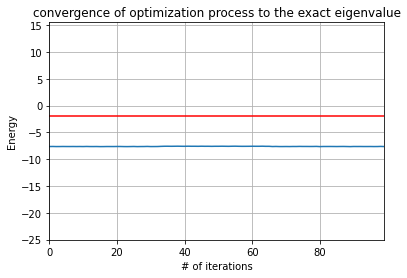

In [35]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

##  Transverse Ising Model 4 qubits

In [36]:
transverse_ising_4_qubits = 0.0 * (I^I^I^I) \
    + 0.8398088405253477 * (X^I^I^I) \
    + 0.7989496312070936 * (I^X^I^I) \
    + 0.38189710487113193 * (Z^Z^I^I) \
    + 0.057753122422666725 * (I^I^X^I) \
    + 0.5633292636970458 * (Z^I^Z^I) \
    + 0.3152740621483513 * (I^Z^Z^I) \
    + 0.07209487981989715 * (I^I^I^X) \
    + 0.17892334004292654 * (Z^I^I^Z) \
    + 0.2273896497668042 * (I^Z^I^Z) \
    + 0.09762902934216211 * (I^I^Z^Z)

In [37]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits, "linear")

[3.82396564 1.58827184 3.60002652 3.46243128 5.04224428 0.89742952
 3.51947813 3.27294728 1.0112956  1.46501498 1.36570678 4.64615779
 2.08373339 1.53887922 5.59403316 4.57773517 1.37257276 3.82534054
 2.33243045 2.48741953 4.56191552 0.92058545 3.5072731  3.21911592
 5.88335567 2.98532862 3.99375314 2.89787166 4.19754208 5.50468667
 4.60044287 3.6264675 ]
thetas:
[3.82396564 1.58827184 3.60002652 3.46243128 5.04224428 0.89742952
 3.51947813 3.27294728 1.0112956  1.46501498 1.36570678 4.64615779
 2.08373339 1.53887922 5.59403316 4.57773517 1.37257276 3.82534054
 2.33243045 2.48741953 4.56191552 0.92058545 3.5072731  3.21911592
 5.88335567 2.98532862 3.99375314 2.89787166 4.19754208 5.50468667
 4.60044287 3.6264675 ]
2.0800168093838036
thetas:
[3.82396565 1.58827184 3.60002652 3.46243128 5.04224428 0.89742952
 3.51947813 3.27294728 1.0112956  1.46501498 1.36570678 4.64615779
 2.08373339 1.53887922 5.59403316 4.57773517 1.37257276 3.82534054
 2.33243045 2.48741953 4.56191552 0.92058545 3

2.05635466334575
thetas:
[3.82396564 1.58827184 3.60002652 3.46243128 5.04224428 0.89742952
 3.51947813 3.27294728 1.0112956  1.46501498 1.36570678 4.64615779
 2.08373339 1.53887922 5.59403316 4.57773517 1.37257276 3.82534054
 2.33243045 2.48741953 4.56191553 0.92058545 3.5072731  3.21911592
 5.88335567 2.98532862 3.99375314 2.89787166 4.19754208 5.50468667
 4.60044287 3.6264675 ]
2.062328565118329
thetas:
[3.82396564 1.58827184 3.60002652 3.46243128 5.04224428 0.89742952
 3.51947813 3.27294728 1.0112956  1.46501498 1.36570678 4.64615779
 2.08373339 1.53887922 5.59403316 4.57773517 1.37257276 3.82534054
 2.33243045 2.48741953 4.56191552 0.92058547 3.5072731  3.21911592
 5.88335567 2.98532862 3.99375314 2.89787166 4.19754208 5.50468667
 4.60044287 3.6264675 ]
2.0814721277558808
thetas:
[3.82396564 1.58827184 3.60002652 3.46243128 5.04224428 0.89742952
 3.51947813 3.27294728 1.0112956  1.46501498 1.36570678 4.64615779
 2.08373339 1.53887922 5.59403316 4.57773517 1.37257276 3.82534054
 2.

1.7760932742150297
thetas:
[4.16380187 1.66492325 3.68476814 3.69766891 5.09910335 1.1889508
 3.49525487 3.31221164 1.07195396 1.76081758 1.47953244 4.94485019
 2.22527038 1.82939833 5.6749657  4.54201934 1.65217817 4.02814529
 2.47526749 2.61185639 4.65493622 0.91293208 3.58682182 3.29400707
 5.9170916  3.29423538 4.19584876 3.06360096 4.47282035 5.6353428
 4.67979605 3.64645995]
1.8210392622943532
thetas:
[4.16380187 1.66492325 3.68476814 3.69766891 5.09910335 1.1889508
 3.49525487 3.31221164 1.07195396 1.76081757 1.47953246 4.94485019
 2.22527038 1.82939833 5.6749657  4.54201934 1.65217817 4.02814529
 2.47526749 2.61185639 4.65493622 0.91293208 3.58682182 3.29400707
 5.9170916  3.29423538 4.19584876 3.06360096 4.47282035 5.6353428
 4.67979605 3.64645995]
1.833046740440574
thetas:
[4.16380187 1.66492325 3.68476814 3.69766891 5.09910335 1.1889508
 3.49525487 3.31221164 1.07195396 1.76081757 1.47953244 4.9448502
 2.22527038 1.82939833 5.6749657  4.54201934 1.65217817 4.02814529
 2.4752

1.8356693835662414
thetas:
[4.16380187 1.66492325 3.68476814 3.69766891 5.09910335 1.1889508
 3.49525487 3.31221164 1.07195396 1.76081757 1.47953244 4.94485019
 2.22527038 1.82939833 5.6749657  4.54201934 1.65217817 4.02814529
 2.47526749 2.61185639 4.65493622 0.91293208 3.58682182 3.29400707
 5.9170916  3.29423538 4.19584876 3.06360096 4.47282035 5.6353428
 4.67979605 3.64645997]
1.8379623682840405
thetas:
[3.92407512 1.61085193 3.62498984 3.53172794 5.05899391 0.98330631
 3.51234241 3.28451384 1.02916444 1.55215296 1.39923772 4.73414706
 2.12542757 1.62446079 5.61787439 4.56721394 1.45493936 3.88508308
 2.3745076  2.52407633 4.5893177  0.91833091 3.53070669 3.24117747
 5.89329365 3.07632685 4.05328678 2.94669245 4.27863398 5.54317556
 4.62381885 3.63235691]
1.9977925874441498
thetas:
[3.92407514 1.61085193 3.62498984 3.53172794 5.05899391 0.98330631
 3.51234241 3.28451384 1.02916444 1.55215296 1.39923772 4.73414706
 2.12542757 1.62446079 5.61787439 4.56721394 1.45493936 3.88508308
 2

1.9992038043157458
thetas:
[3.92407512 1.61085193 3.62498984 3.53172794 5.05899391 0.98330631
 3.51234241 3.28451384 1.02916444 1.55215296 1.39923772 4.73414706
 2.12542757 1.62446079 5.61787439 4.56721394 1.45493936 3.88508308
 2.3745076  2.52407633 4.58931772 0.91833091 3.53070669 3.24117747
 5.89329365 3.07632685 4.05328678 2.94669245 4.27863398 5.54317556
 4.62381885 3.63235691]
1.9394102866358147
thetas:
[3.92407512 1.61085193 3.62498984 3.53172794 5.05899391 0.98330631
 3.51234241 3.28451384 1.02916444 1.55215296 1.39923772 4.73414706
 2.12542757 1.62446079 5.61787439 4.56721394 1.45493936 3.88508308
 2.3745076  2.52407633 4.5893177  0.91833093 3.53070669 3.24117747
 5.89329365 3.07632685 4.05328678 2.94669245 4.27863398 5.54317556
 4.62381885 3.63235691]
1.9965837202009291
thetas:
[3.92407512 1.61085193 3.62498984 3.53172794 5.05899391 0.98330631
 3.51234241 3.28451384 1.02916444 1.55215296 1.39923772 4.73414706
 2.12542757 1.62446079 5.61787439 4.56721394 1.45493936 3.88508308


2.0157067388788343
thetas:
[3.86144314 1.59672504 3.60937192 3.48837354 5.04851476 0.9295788
 3.51680677 3.2772774  1.01798507 1.49763642 1.3782596  4.6790979
 2.09934224 1.57091798 5.60295848 4.57379639 1.40340795 3.84770606
 2.34818267 2.50114256 4.57217394 0.91974143 3.51604582 3.22737499
 5.8870761  3.01939519 4.01604046 2.91614846 4.22790006 5.51909557
 4.60919402 3.62867229]
2.0640080323853756
thetas:
[3.86144314 1.59672504 3.60937192 3.48837354 5.04851476 0.9295788
 3.51680677 3.2772774  1.01798507 1.4976364  1.37825961 4.6790979
 2.09934224 1.57091798 5.60295848 4.57379639 1.40340795 3.84770606
 2.34818267 2.50114256 4.57217394 0.91974143 3.51604582 3.22737499
 5.8870761  3.01939519 4.01604046 2.91614846 4.22790006 5.51909557
 4.60919402 3.62867229]
2.0507829395297996
thetas:
[3.86144314 1.59672504 3.60937192 3.48837354 5.04851476 0.9295788
 3.51680677 3.2772774  1.01798507 1.4976364  1.3782596  4.67909792
 2.09934224 1.57091798 5.60295848 4.57379639 1.40340795 3.84770606
 2.34

2.0570315439042735
thetas:
[3.86144314 1.59672504 3.60937192 3.48837354 5.04851476 0.9295788
 3.51680677 3.2772774  1.01798507 1.4976364  1.3782596  4.6790979
 2.09934224 1.57091798 5.60295848 4.57379639 1.40340795 3.84770606
 2.34818267 2.50114256 4.57217394 0.91974143 3.51604582 3.22737499
 5.8870761  3.01939519 4.01604046 2.91614846 4.22790006 5.51909557
 4.60919402 3.62867231]
2.0336349693440656
thetas:
[3.83269958 1.59024181 3.60220442 3.46847699 5.04370558 0.90492174
 3.51885558 3.2739564  1.01285455 1.47261724 1.36863215 4.65383432
 2.08737095 1.54634569 5.59611316 4.57681725 1.37975875 3.83055271
 2.33610142 2.49061761 4.56430619 0.92038876 3.50931754 3.22104065
 5.88422269 2.99326766 3.99894709 2.90213097 4.20461685 5.50804459
 4.60248228 3.62698132]
2.0518506637186404
thetas:
[3.83269959 1.59024181 3.60220442 3.46847699 5.04370558 0.90492174
 3.51885558 3.2739564  1.01285455 1.47261724 1.36863215 4.65383432
 2.08737095 1.54634569 5.59611316 4.57681725 1.37975875 3.83055271
 2

2.040369607336167
thetas:
[3.83269958 1.59024181 3.60220442 3.46847699 5.04370558 0.90492174
 3.51885558 3.2739564  1.01285455 1.47261724 1.36863215 4.65383432
 2.08737095 1.54634569 5.59611316 4.57681725 1.37975875 3.83055271
 2.33610142 2.49061761 4.56430621 0.92038876 3.50931754 3.22104065
 5.88422269 2.99326766 3.99894709 2.90213097 4.20461685 5.50804459
 4.60248228 3.62698132]
2.0489799178501498
thetas:
[3.83269958 1.59024181 3.60220442 3.46847699 5.04370558 0.90492174
 3.51885558 3.2739564  1.01285455 1.47261724 1.36863215 4.65383432
 2.08737095 1.54634569 5.59611316 4.57681725 1.37975875 3.83055271
 2.33610142 2.49061761 4.56430619 0.92038877 3.50931754 3.22104065
 5.88422269 2.99326766 3.99894709 2.90213097 4.20461685 5.50804459
 4.60248228 3.62698132]
2.0377090856618327
thetas:
[3.83269958 1.59024181 3.60220442 3.46847699 5.04370558 0.90492174
 3.51885558 3.2739564  1.01285455 1.47261724 1.36863215 4.65383432
 2.08737095 1.54634569 5.59611316 4.57681725 1.37975875 3.83055271
 

2.043325324786547
thetas:
[3.8266579  1.58887909 3.60069786 3.46429489 5.04269473 0.89973901
 3.51928623 3.27325835 1.01177615 1.46735841 1.36660853 4.6485241
 2.08485467 1.54118078 5.59467432 4.57745222 1.37478786 3.8269472
 2.33356204 2.48840535 4.56265245 0.92052482 3.50790331 3.21970922
 5.88362293 2.98777585 3.99535419 2.8991846  4.1997229  5.50572176
 4.60107152 3.62662589]
2.0794743699074303
thetas:
[3.8266579  1.58887909 3.60069786 3.46429489 5.04269473 0.89973901
 3.51928623 3.27325835 1.01177615 1.4673584  1.36660855 4.6485241
 2.08485467 1.54118078 5.59467432 4.57745222 1.37478786 3.8269472
 2.33356204 2.48840535 4.56265245 0.92052482 3.50790331 3.21970922
 5.88362293 2.98777585 3.99535419 2.8991846  4.1997229  5.50572176
 4.60107152 3.62662589]
2.007442712674491
thetas:
[3.8266579  1.58887909 3.60069786 3.46429489 5.04269473 0.89973901
 3.51928623 3.27325835 1.01177615 1.4673584  1.36660853 4.64852411
 2.08485467 1.54118078 5.59467432 4.57745222 1.37478786 3.8269472
 2.3335

2.0397703565584746
thetas:
[3.8266579  1.58887909 3.60069786 3.46429489 5.04269473 0.89973901
 3.51928623 3.27325835 1.01177615 1.4673584  1.36660853 4.6485241
 2.08485467 1.54118078 5.59467432 4.57745222 1.37478786 3.8269472
 2.33356204 2.48840535 4.56265245 0.92052482 3.50790331 3.21970922
 5.88362293 2.98777585 3.99535419 2.8991846  4.1997229  5.50572176
 4.60107152 3.6266259 ]
2.0903079829295224
thetas:
[3.82479454 1.5884588  3.60023322 3.46300505 5.04238297 0.89814057
 3.51941905 3.27304305 1.01144355 1.46573648 1.36598442 4.64688633
 2.08407861 1.53958783 5.59423056 4.57764805 1.37325475 3.8258352
 2.33277884 2.48772305 4.56214241 0.92056679 3.50746713 3.21929859
 5.88343795 2.98608208 3.99424608 2.89827589 4.19821351 5.50500536
 4.60063642 3.62651627]
2.03398101847241
thetas:
[3.82479455 1.5884588  3.60023322 3.46300505 5.04238297 0.89814057
 3.51941905 3.27304305 1.01144355 1.46573648 1.36598442 4.64688633
 2.08407861 1.53958783 5.59423056 4.57764805 1.37325475 3.8258352
 2.332

2.0386134676891423
thetas:
[3.82479454 1.5884588  3.60023322 3.46300505 5.04238297 0.89814057
 3.51941905 3.27304305 1.01144355 1.46573648 1.36598442 4.64688633
 2.08407861 1.53958783 5.59423056 4.57764805 1.37325475 3.8258352
 2.33277884 2.48772305 4.56214242 0.92056679 3.50746713 3.21929859
 5.88343795 2.98608208 3.99424608 2.89827589 4.19821351 5.50500536
 4.60063642 3.62651627]
2.0472628271593094
thetas:
[3.82479454 1.5884588  3.60023322 3.46300505 5.04238297 0.89814057
 3.51941905 3.27304305 1.01144355 1.46573648 1.36598442 4.64688633
 2.08407861 1.53958783 5.59423056 4.57764805 1.37325475 3.8258352
 2.33277884 2.48772305 4.56214241 0.9205668  3.50746713 3.21929859
 5.88343795 2.98608208 3.99424608 2.89827589 4.19821351 5.50500536
 4.60063642 3.62651627]
2.0664258991834017
thetas:
[3.82479454 1.5884588  3.60023322 3.46300505 5.04238297 0.89814057
 3.51941905 3.27304305 1.01144355 1.46573648 1.36598442 4.64688633
 2.08407861 1.53958783 5.59423056 4.57764805 1.37325475 3.8258352
 2.

2.070415329112929
thetas:
[3.82428661 1.58834423 3.60010656 3.46265346 5.04229798 0.89770486
 3.51945525 3.27298437 1.01135289 1.46529438 1.36581429 4.6464399
 2.08386707 1.53915361 5.5941096  4.57770143 1.37283685 3.82553209
 2.33256536 2.48753706 4.56200338 0.92057822 3.50734824 3.21918665
 5.88338753 2.98562038 3.99394402 2.89802819 4.19780208 5.50481008
 4.60051782 3.62648638]
2.0135396256992086
thetas:
[3.82428661 1.58834423 3.60010656 3.46265346 5.04229798 0.89770486
 3.51945525 3.27298437 1.01135289 1.46529436 1.3658143  4.6464399
 2.08386707 1.53915361 5.5941096  4.57770143 1.37283685 3.82553209
 2.33256536 2.48753706 4.56200338 0.92057822 3.50734824 3.21918665
 5.88338753 2.98562038 3.99394402 2.89802819 4.19780208 5.50481008
 4.60051782 3.62648638]
2.0533606325654303
thetas:
[3.82428661 1.58834423 3.60010656 3.46265346 5.04229798 0.89770486
 3.51945525 3.27298437 1.01135289 1.46529436 1.36581429 4.64643992
 2.08386707 1.53915361 5.5941096  4.57770143 1.37283685 3.82553209
 2.

2.064096649287023
thetas:
[3.82428661 1.58834423 3.60010656 3.46265346 5.04229798 0.89770486
 3.51945525 3.27298437 1.01135289 1.46529436 1.36581429 4.6464399
 2.08386707 1.53915361 5.5941096  4.57770143 1.37283685 3.82553209
 2.33256536 2.48753706 4.56200338 0.92057822 3.50734824 3.21918665
 5.88338753 2.98562038 3.99394402 2.89802819 4.19780208 5.50481008
 4.60051782 3.6264864 ]
2.0511435164954386
thetas:
[3.82406757 1.58829483 3.60005194 3.46250184 5.04226134 0.89751696
 3.51947087 3.27295906 1.0113138  1.46510371 1.36574092 4.64624738
 2.08377584 1.53896636 5.59405743 4.57772445 1.37265663 3.82540137
 2.33247329 2.48745686 4.56194342 0.92058316 3.50729696 3.21913838
 5.88336579 2.98542128 3.99381376 2.89792137 4.19762465 5.50472586
 4.60046667 3.6264735 ]
2.0162159539862436
thetas:
[3.82406759 1.58829483 3.60005194 3.46250184 5.04226134 0.89751696
 3.51947087 3.27295906 1.0113138  1.46510371 1.36574092 4.64624738
 2.08377584 1.53896636 5.59405743 4.57772445 1.37265663 3.82540137
 2

2.0474389479556048
thetas:
[3.82406757 1.58829483 3.60005194 3.46250184 5.04226134 0.89751696
 3.51947087 3.27295906 1.0113138  1.46510371 1.36574092 4.64624738
 2.08377584 1.53896636 5.59405743 4.57772445 1.37265663 3.82540137
 2.33247329 2.48745686 4.56194344 0.92058316 3.50729696 3.21913838
 5.88336579 2.98542128 3.99381376 2.89792137 4.19762465 5.50472586
 4.60046667 3.6264735 ]
2.0239799192147183
thetas:
[3.82406757 1.58829483 3.60005194 3.46250184 5.04226134 0.89751696
 3.51947087 3.27295906 1.0113138  1.46510371 1.36574092 4.64624738
 2.08377584 1.53896636 5.59405743 4.57772445 1.37265663 3.82540137
 2.33247329 2.48745686 4.56194342 0.92058317 3.50729696 3.21913838
 5.88336579 2.98542128 3.99381376 2.89792137 4.19762465 5.50472586
 4.60046667 3.6264735 ]
2.056026372009982
thetas:
[3.82406757 1.58829483 3.60005194 3.46250184 5.04226134 0.89751696
 3.51947087 3.27295906 1.0113138  1.46510371 1.36574092 4.64624738
 2.08377584 1.53896636 5.59405743 4.57772445 1.37265663 3.82540137
 

2.1057212984302316
thetas:
[3.82401142 1.58828216 3.60003794 3.46246297 5.04225194 0.89746879
 3.51947487 3.27295257 1.01130377 1.46505484 1.36572212 4.64619803
 2.08375245 1.53891835 5.59404406 4.57773036 1.37261043 3.82536786
 2.33244969 2.4874363  4.56192805 0.92058442 3.50728382 3.21912601
 5.88336021 2.98537023 3.99378037 2.89789398 4.19757916 5.50470427
 4.60045356 3.6264702 ]
2.073067855563155
thetas:
[3.82401142 1.58828216 3.60003794 3.46246297 5.04225194 0.89746879
 3.51947487 3.27295257 1.01130377 1.46505483 1.36572213 4.64619803
 2.08375245 1.53891835 5.59404406 4.57773036 1.37261043 3.82536786
 2.33244969 2.4874363  4.56192805 0.92058442 3.50728382 3.21912601
 5.88336021 2.98537023 3.99378037 2.89789398 4.19757916 5.50470427
 4.60045356 3.6264702 ]
2.0410782662679057
thetas:
[3.82401142 1.58828216 3.60003794 3.46246297 5.04225194 0.89746879
 3.51947487 3.27295257 1.01130377 1.46505483 1.36572212 4.64619804
 2.08375245 1.53891835 5.59404406 4.57773036 1.37261043 3.82536786
 

2.0640428754333318
thetas:
[3.82401142 1.58828216 3.60003794 3.46246297 5.04225194 0.89746879
 3.51947487 3.27295257 1.01130377 1.46505483 1.36572212 4.64619803
 2.08375245 1.53891835 5.59404406 4.57773036 1.37261043 3.82536786
 2.33244969 2.4874363  4.56192805 0.92058442 3.50728382 3.21912601
 5.88336021 2.98537023 3.99378037 2.89789398 4.19757916 5.50470427
 4.60045356 3.62647021]
2.0563295882075945
thetas:
[3.82398454 1.5882761  3.60003124 3.46244437 5.04224744 0.89744574
 3.51947679 3.27294947 1.01129898 1.46503144 1.36571311 4.64617441
 2.08374126 1.53889538 5.59403766 4.57773318 1.37258832 3.82535182
 2.33243839 2.48742645 4.56192069 0.92058503 3.50727753 3.21912009
 5.88335754 2.98534581 3.99376439 2.89788088 4.19755739 5.50469394
 4.60044729 3.62646861]
2.071363602255871
thetas:
[3.82398456 1.5882761  3.60003124 3.46244437 5.04224744 0.89744574
 3.51947679 3.27294947 1.01129898 1.46503144 1.36571311 4.64617441
 2.08374126 1.53889538 5.59403766 4.57773318 1.37258832 3.82535182
 

2.061579508430873
thetas:
[3.82398454 1.5882761  3.60003124 3.46244437 5.04224744 0.89744574
 3.51947679 3.27294947 1.01129898 1.46503144 1.36571311 4.64617441
 2.08374126 1.53889538 5.59403766 4.57773318 1.37258832 3.82535182
 2.33243839 2.48742645 4.56192071 0.92058503 3.50727753 3.21912009
 5.88335754 2.98534581 3.99376439 2.89788088 4.19755739 5.50469394
 4.60044729 3.62646861]
2.0159950037095755
thetas:
[3.82398454 1.5882761  3.60003124 3.46244437 5.04224744 0.89744574
 3.51947679 3.27294947 1.01129898 1.46503144 1.36571311 4.64617441
 2.08374126 1.53889538 5.59403766 4.57773318 1.37258832 3.82535182
 2.33243839 2.48742645 4.56192069 0.92058504 3.50727753 3.21912009
 5.88335754 2.98534581 3.99376439 2.89788088 4.19755739 5.50469394
 4.60044729 3.62646861]
2.040680161779113
thetas:
[3.82398454 1.5882761  3.60003124 3.46244437 5.04224744 0.89744574
 3.51947679 3.27294947 1.01129898 1.46503144 1.36571311 4.64617441
 2.08374126 1.53889538 5.59403766 4.57773318 1.37258832 3.82535182
 2

2.0434072686649514
thetas:
[3.82397154 1.58827317 3.60002799 3.46243536 5.04224527 0.89743458
 3.51947771 3.27294797 1.01129665 1.46502013 1.36570876 4.64616297
 2.08373584 1.53888426 5.59403456 4.57773455 1.37257762 3.82534406
 2.33243293 2.48742169 4.56191713 0.92058532 3.50727448 3.21911722
 5.88335625 2.98533398 3.99375665 2.89787453 4.19754686 5.50468894
 4.60044425 3.62646785]
2.0338043252320777
thetas:
[3.82397154 1.58827317 3.60002799 3.46243536 5.04224527 0.89743458
 3.51947771 3.27294797 1.01129665 1.46502012 1.36570877 4.64616297
 2.08373584 1.53888426 5.59403456 4.57773455 1.37257762 3.82534406
 2.33243293 2.48742169 4.56191713 0.92058532 3.50727448 3.21911722
 5.88335625 2.98533398 3.99375665 2.89787453 4.19754686 5.50468894
 4.60044425 3.62646785]
2.0784351009474324
thetas:
[3.82397154 1.58827317 3.60002799 3.46243536 5.04224527 0.89743458
 3.51947771 3.27294797 1.01129665 1.46502012 1.36570876 4.64616299
 2.08373584 1.53888426 5.59403456 4.57773455 1.37257762 3.82534406


2.046901654502777
thetas:
[3.82397154 1.58827317 3.60002799 3.46243536 5.04224527 0.89743458
 3.51947771 3.27294797 1.01129665 1.46502012 1.36570876 4.64616297
 2.08373584 1.53888426 5.59403456 4.57773455 1.37257762 3.82534406
 2.33243293 2.48742169 4.56191713 0.92058532 3.50727448 3.21911722
 5.88335625 2.98533398 3.99375665 2.89787453 4.19754686 5.50468894
 4.60044425 3.62646786]
2.0611363316177527
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243108 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.62646759]
2.057601039699635
thetas:
[3.82396714 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.332

2.0642564707496445
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243108 2.48742008 4.56191594 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.62646759]
2.0780141520592177
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243108 2.48742008 4.56191593 0.92058543 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.62646759]
2.053754350433597
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.3324

2.048976301047963
thetas:
[3.82396713 1.58827217 3.6000269  3.46243231 5.04224453 0.8974308
 3.51947802 3.27294746 1.01129587 1.46501629 1.36570728 4.6461591
 2.08373401 1.5388805  5.59403351 4.57773501 1.37257399 3.82534143
 2.33243108 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787239 4.19754329 5.50468725
 4.60044322 3.62646759]
2.05961635150698
thetas:
[3.82396713 1.58827217 3.6000269  3.46243231 5.04224453 0.8974308
 3.51947802 3.27294746 1.01129587 1.46501628 1.3657073  4.6461591
 2.08373401 1.5388805  5.59403351 4.57773501 1.37257399 3.82534143
 2.33243108 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787239 4.19754329 5.50468725
 4.60044322 3.62646759]
2.016641500953512
thetas:
[3.82396713 1.58827217 3.6000269  3.46243231 5.04224453 0.8974308
 3.51947802 3.27294746 1.01129587 1.46501628 1.36570728 4.64615912
 2.08373401 1.5388805  5.59403351 4.57773501 1.37257399 3.82534143
 2.332431

2.0813553280222346
thetas:
[3.82396713 1.58827217 3.6000269  3.46243231 5.04224453 0.8974308
 3.51947802 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.5388805  5.59403351 4.57773501 1.37257399 3.82534143
 2.33243108 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787239 4.19754329 5.50468725
 4.60044322 3.6264676 ]
2.096209853186761
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243108 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787239 4.19754329 5.50468725
 4.60044322 3.62646759]
2.0659070578773835
thetas:
[3.82396714 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.3324

2.046832417941535
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243108 2.48742008 4.56191594 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787239 4.19754329 5.50468725
 4.60044322 3.62646759]
2.0614041793427886
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243108 2.48742008 4.56191593 0.92058543 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787239 4.19754329 5.50468725
 4.60044322 3.62646759]
2.067292294916312
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243

2.0660171645416363
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501629 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243108 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.62646759]
2.05409170623445
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.3657073  4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243108 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.62646759]
2.068538857914495
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.64615912
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243

2.0349066743027424
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243108 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.6264676 ]
2.0715069060094184
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243108 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.62646759]
2.046918653224635
thetas:
[3.82396714 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.3324

2.030792779038346
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243108 2.48742008 4.56191594 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.62646759]
2.0597470094092105
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243108 2.48742008 4.56191593 0.92058543 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.62646759]
2.0567297944191654
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.3324

2.059524079424052
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501629 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243107 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.62646759]
2.0716001743167487
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.3657073  4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243107 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.62646759]
2.067504077132954
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.64615912
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.3324

2.077052369486401
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243107 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.6264676 ]
2.0437792534763766
thetas:
[3.82396713 1.58827217 3.6000269  3.46243231 5.04224453 0.8974308
 3.51947802 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243107 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.62646759]
2.079918595346545
thetas:
[3.82396714 1.58827217 3.6000269  3.46243231 5.04224453 0.8974308
 3.51947802 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243

2.061249672208813
thetas:
[3.82396713 1.58827217 3.6000269  3.46243231 5.04224453 0.8974308
 3.51947802 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243107 2.48742008 4.56191594 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.62646759]
2.0499963796321534
thetas:
[3.82396713 1.58827217 3.6000269  3.46243231 5.04224453 0.8974308
 3.51947802 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243107 2.48742008 4.56191593 0.92058543 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.62646759]
2.022724243252314
thetas:
[3.82396713 1.58827217 3.6000269  3.46243231 5.04224453 0.8974308
 3.51947802 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243

2.0278163045864335
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501629 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243107 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.62646759]
2.041744101644675
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.3657073  4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243107 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.62646759]
2.039131648110541
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.64615912
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.3324

2.065886101106375
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243107 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.6264676 ]
2.067551674059163
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243107 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.62646759]
2.0893610974300363
thetas:
[3.82396714 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243

2.032877732452159
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243107 2.48742008 4.56191594 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.62646759]
2.0414801502014917
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243107 2.48742008 4.56191593 0.92058543 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.62646759]
2.0573311349075825
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.3324

2.0096123211465815
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501629 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243107 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.62646759]
2.038711754777539
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.3657073  4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243107 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.62646759]
2.0843128614084505
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.64615912
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.332

2.0471266267866444
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243107 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.6264676 ]
2.057361073932357
thetas:
[3.82396713 1.58827217 3.6000269  3.46243231 5.04224453 0.8974308
 3.51947802 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243107 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.62646759]
2.050652795012046
thetas:
[3.82396713 1.58827217 3.6000269  3.46243231 5.04224453 0.8974308
 3.51947802 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243

2.0375013418375976
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257401 3.82534143
 2.33243107 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.62646759]
2.055632534246604
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534145
 2.33243107 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.62646759]
2.091259919533379
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243

2.0603624957141893
thetas:
[3.82396713 1.58827217 3.6000269  3.46243231 5.04224453 0.89743081
 3.51947802 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243107 2.48742008 4.56191592 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532999 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.62646758]
2.0128720722794484
thetas:
[3.82396713 1.58827217 3.6000269  3.46243231 5.04224453 0.8974308
 3.51947804 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243107 2.48742008 4.56191592 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532999 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.62646758]
2.067075159109527
thetas:
[3.82396713 1.58827217 3.6000269  3.46243231 5.04224453 0.8974308
 3.51947802 3.27294747 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.332

2.0875666844402634
thetas:
[3.82396713 1.58827217 3.6000269  3.46243231 5.04224453 0.8974308
 3.51947802 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243107 2.48742008 4.56191592 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532999 3.99375403 2.89787239 4.19754329 5.50468725
 4.60044322 3.62646758]
2.0780175051492717
thetas:
[3.82396713 1.58827217 3.6000269  3.46243231 5.04224453 0.8974308
 3.51947802 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243107 2.48742008 4.56191592 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532999 3.99375403 2.89787238 4.19754331 5.50468725
 4.60044322 3.62646758]
2.0134746032321145
thetas:
[3.82396713 1.58827217 3.6000269  3.46243231 5.04224453 0.8974308
 3.51947802 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.332

2.034873338470331
thetas:
[3.82396713 1.58827217 3.6000269  3.46243231 5.04224453 0.8974308
 3.51947802 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257401 3.82534143
 2.33243107 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.62646759]
2.063267989541141
thetas:
[3.82396713 1.58827217 3.6000269  3.46243231 5.04224453 0.8974308
 3.51947802 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534145
 2.33243107 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.62646759]
2.075284027073129
thetas:
[3.82396713 1.58827217 3.6000269  3.46243231 5.04224453 0.8974308
 3.51947802 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.332431

2.0753798200695046
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.89743081
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243107 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.62646759]
2.0765876516106037
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947804 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243107 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.62646759]
2.0764786073700714
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294747 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33

2.043762405592999
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243107 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.8978724  4.19754329 5.50468725
 4.60044322 3.62646759]
2.021559385426519
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243107 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754331 5.50468725
 4.60044322 3.62646759]
1.994600878745201
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.332431

2.0751469054181646
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257401 3.82534143
 2.33243107 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.62646759]
2.0036988329170704
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534145
 2.33243107 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.62646759]
2.019967460350633
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.3324

2.060770104607272
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.89743081
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243107 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.62646759]
2.039198557058751
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947804 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243107 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.62646759]
2.051812088162075
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294747 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243

2.022474533201522
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243107 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.8978724  4.19754329 5.50468725
 4.60044322 3.62646759]
2.043377192170208
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243107 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754331 5.50468725
 4.60044322 3.62646759]
2.0332305682334724
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243

2.0455929081947652
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257401 3.82534143
 2.33243107 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.62646759]
1.994340225074435
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534145
 2.33243107 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.62646759]
2.074846964219176
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243

2.022411011624994
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.89743081
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243107 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.62646759]
2.054957278623116
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947804 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243107 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754329 5.50468725
 4.60044322 3.62646759]
2.046532681395152
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294747 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243

2.0656649239133795
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243107 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.8978724  4.19754329 5.50468725
 4.60044322 3.62646759]
2.0554450236446664
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.33243107 2.48742008 4.56191593 0.92058542 3.50727345 3.21911625
 5.88335581 2.98532998 3.99375403 2.89787238 4.19754331 5.50468725
 4.60044322 3.62646759]
2.0610506344643897
thetas:
[3.82396713 1.58827217 3.60002689 3.46243231 5.04224453 0.8974308
 3.51947803 3.27294746 1.01129587 1.46501628 1.36570728 4.6461591
 2.08373401 1.53888049 5.59403351 4.57773501 1.37257399 3.82534143
 2.332

CPU times: total: 9min 31s
Wall time: 9min 40s


[(2.3867070442313216+0j), (2.3718326043433704+0j), (1.6958488386667439+0j), (1.6816520928402046+0j), (0.3444947223438019+0j), (0.2757654176709828+0j), (0.20992649961322052+0j), (0.14239915569453057+0j), (-0.2505930484227001+0j), (-0.31907768442618767+0j), (-0.47710503946487287+0j), (-0.5462047134056278+0j), (-1.7583827504312988+0j), (-1.8497137109270194+0j), (-1.9080638482930956+0j), (-1.9994855800333675+0j)]
Exact Eigenvalue:
(-1.9994855800333675+0j)

Approximated Eigenvalue:
2.0201006595365794

Approximation Error
0.010310191635824558


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


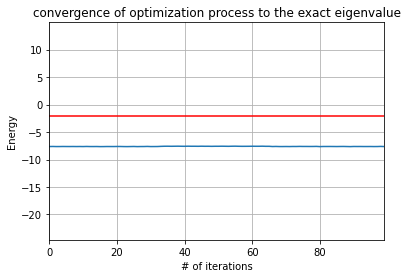

In [38]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

In [39]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits, "full")

[5.65601733 1.12851789 0.81556745 6.12095363 4.70092772 2.67416736
 0.94049257 0.45254225 4.78857185 1.50572476 3.51036727 3.23096528
 2.80905182 1.76156571 2.40071312 0.62068882 0.38896607 3.13845805
 2.42293233 1.22613075 4.62211979 5.90770427 5.6865671  0.97106221
 5.83348931 2.84973775 2.932708   3.08790158 4.24884279 1.18111128
 5.16779936 0.76264751]
thetas:
[5.65601733 1.12851789 0.81556745 6.12095363 4.70092772 2.67416736
 0.94049257 0.45254225 4.78857185 1.50572476 3.51036727 3.23096528
 2.80905182 1.76156571 2.40071312 0.62068882 0.38896607 3.13845805
 2.42293233 1.22613075 4.62211979 5.90770427 5.6865671  0.97106221
 5.83348931 2.84973775 2.932708   3.08790158 4.24884279 1.18111128
 5.16779936 0.76264751]
1.919904844932315
thetas:
[5.65601735 1.12851789 0.81556745 6.12095363 4.70092772 2.67416736
 0.94049257 0.45254225 4.78857185 1.50572476 3.51036727 3.23096528
 2.80905182 1.76156571 2.40071312 0.62068882 0.38896607 3.13845805
 2.42293233 1.22613075 4.62211979 5.90770427 5.

1.8697411170842289
thetas:
[5.65601733 1.12851789 0.81556745 6.12095363 4.70092772 2.67416736
 0.94049257 0.45254225 4.78857185 1.50572476 3.51036727 3.23096528
 2.80905182 1.76156571 2.40071312 0.62068882 0.38896607 3.13845805
 2.42293233 1.22613075 4.6221198  5.90770427 5.6865671  0.97106221
 5.83348931 2.84973775 2.932708   3.08790158 4.24884279 1.18111128
 5.16779936 0.76264751]
1.8756486493312106
thetas:
[5.65601733 1.12851789 0.81556745 6.12095363 4.70092772 2.67416736
 0.94049257 0.45254225 4.78857185 1.50572476 3.51036727 3.23096528
 2.80905182 1.76156571 2.40071312 0.62068882 0.38896607 3.13845805
 2.42293233 1.22613075 4.62211979 5.90770429 5.6865671  0.97106221
 5.83348931 2.84973775 2.932708   3.08790158 4.24884279 1.18111128
 5.16779936 0.76264751]
1.8839243921511304
thetas:
[5.65601733 1.12851789 0.81556745 6.12095363 4.70092772 2.67416736
 0.94049257 0.45254225 4.78857185 1.50572476 3.51036727 3.23096528
 2.80905182 1.76156571 2.40071312 0.62068882 0.38896607 3.13845805


1.7710553982890411
thetas:
[5.83501459 1.13069688 0.84482684 6.32844261 4.77083734 2.69101896
 1.16052521 0.74994162 4.82540653 1.73995316 3.55031142 3.22181949
 2.90239369 2.18780705 2.59611353 0.77531819 0.44983871 3.05173534
 2.63764576 1.44827406 4.81810238 6.06703886 5.82260279 1.14093477
 5.87667954 2.91121911 3.1087029  3.38396721 4.42701158 1.4409618
 5.37115906 0.85751378]
1.7722366087329997
thetas:
[5.83501459 1.13069688 0.84482684 6.32844261 4.77083734 2.69101896
 1.16052521 0.74994162 4.82540653 1.73995315 3.55031144 3.22181949
 2.90239369 2.18780705 2.59611353 0.77531819 0.44983871 3.05173534
 2.63764576 1.44827406 4.81810238 6.06703886 5.82260279 1.14093477
 5.87667954 2.91121911 3.1087029  3.38396721 4.42701158 1.4409618
 5.37115906 0.85751378]
1.799083727872394
thetas:
[5.83501459 1.13069688 0.84482684 6.32844261 4.77083734 2.69101896
 1.16052521 0.74994162 4.82540653 1.73995315 3.55031142 3.2218195
 2.90239369 2.18780705 2.59611353 0.77531819 0.44983871 3.05173534
 2.6

1.7690164278891727
thetas:
[5.83501459 1.13069688 0.84482684 6.32844261 4.77083734 2.69101896
 1.16052521 0.74994162 4.82540653 1.73995315 3.55031142 3.22181949
 2.90239369 2.18780705 2.59611353 0.77531819 0.44983871 3.05173534
 2.63764576 1.44827406 4.81810238 6.06703886 5.82260279 1.14093477
 5.87667954 2.91121911 3.1087029  3.38396721 4.42701158 1.4409618
 5.37115906 0.8575138 ]
1.7484103967469542
thetas:
[5.70542973 1.1291194  0.82364454 6.1782312  4.72022635 2.67881926
 1.00123284 0.53463969 4.7987401  1.57038378 3.5213939  3.22844058
 2.83481895 1.87923013 2.45465363 0.66337444 0.40577004 3.11451814
 2.48220422 1.28745367 4.67622101 5.95168877 5.72411991 1.01795573
 5.84541202 2.86670975 2.9812916  3.16963085 4.29802649 1.25284332
 5.22393704 0.78883546]
1.8999573733089485
thetas:
[5.70542975 1.1291194  0.82364454 6.1782312  4.72022635 2.67881926
 1.00123284 0.53463969 4.7987401  1.57038378 3.5213939  3.22844058
 2.83481895 1.87923013 2.45465363 0.66337444 0.40577004 3.11451814
 

1.8818854635366629
thetas:
[5.70542973 1.1291194  0.82364454 6.1782312  4.72022635 2.67881926
 1.00123284 0.53463969 4.7987401  1.57038378 3.5213939  3.22844058
 2.83481895 1.87923013 2.45465363 0.66337444 0.40577004 3.11451814
 2.48220422 1.28745367 4.67622102 5.95168877 5.72411991 1.01795573
 5.84541202 2.86670975 2.9812916  3.16963085 4.29802649 1.25284332
 5.22393704 0.78883546]
1.8052361552568916
thetas:
[5.70542973 1.1291194  0.82364454 6.1782312  4.72022635 2.67881926
 1.00123284 0.53463969 4.7987401  1.57038378 3.5213939  3.22844058
 2.83481895 1.87923013 2.45465363 0.66337444 0.40577004 3.11451814
 2.48220422 1.28745367 4.67622101 5.95168879 5.72411991 1.01795573
 5.84541202 2.86670975 2.9812916  3.16963085 4.29802649 1.25284332
 5.22393704 0.78883546]
1.8541083641530607
thetas:
[5.70542973 1.1291194  0.82364454 6.1782312  4.72022635 2.67881926
 1.00123284 0.53463969 4.7987401  1.57038378 3.5213939  3.22844058
 2.83481895 1.87923013 2.45465363 0.66337444 0.40577004 3.11451814


1.8674531895664657
thetas:
[5.66845189 1.12866926 0.81760003 6.13536745 4.70578419 2.675338
 0.95577777 0.47320195 4.79113067 1.52199613 3.5131421  3.23032994
 2.81553608 1.79117579 2.41428717 0.6314306  0.39319477 3.1324336
 2.43784801 1.24156257 4.63573428 5.91877291 5.69601721 0.9828629
 5.83648964 2.85400873 2.94493399 3.10846864 4.2612198  1.19916255
 5.18192632 0.76923767]
1.8814562388510292
thetas:
[5.66845189 1.12866926 0.81760003 6.13536745 4.70578419 2.675338
 0.95577777 0.47320195 4.79113067 1.52199611 3.51314212 3.23032994
 2.81553608 1.79117579 2.41428717 0.6314306  0.39319477 3.1324336
 2.43784801 1.24156257 4.63573428 5.91877291 5.69601721 0.9828629
 5.83648964 2.85400873 2.94493399 3.10846864 4.2612198  1.19916255
 5.18192632 0.76923767]
1.8788942243461826
thetas:
[5.66845189 1.12866926 0.81760003 6.13536745 4.70578419 2.675338
 0.95577777 0.47320195 4.79113067 1.52199611 3.5131421  3.23032996
 2.81553608 1.79117579 2.41428717 0.6314306  0.39319477 3.1324336
 2.43784801

1.9028028764910092
thetas:
[5.66845189 1.12866926 0.81760003 6.13536745 4.70578419 2.675338
 0.95577777 0.47320195 4.79113067 1.52199611 3.5131421  3.23032994
 2.81553608 1.79117579 2.41428717 0.6314306  0.39319477 3.1324336
 2.43784801 1.24156257 4.63573428 5.91877291 5.69601721 0.9828629
 5.83648964 2.85400873 2.94493399 3.10846864 4.2612198  1.19916255
 5.18192632 0.76923769]
1.8809130912300511
thetas:
[5.65912315 1.1285557  0.81607513 6.12455381 4.70214074 2.67445975
 0.9443104  0.45770249 4.78921097 1.50978891 3.51106035 3.23080659
 2.81067141 1.76896151 2.40410355 0.62337183 0.39002229 3.1369533
 2.42665786 1.22998521 4.62552032 5.91046892 5.68892749 0.97400971
 5.83423871 2.85080453 2.93576172 3.09303868 4.25193424 1.18562
 5.17132789 0.76429356]
1.9204580173874513
thetas:
[5.65912317 1.1285557  0.81607513 6.12455381 4.70214074 2.67445975
 0.9443104  0.45770249 4.78921097 1.50978891 3.51106035 3.23080659
 2.81067141 1.76896151 2.40410355 0.62337183 0.39002229 3.1369533
 2.426657

1.9409519033675795
thetas:
[5.65912315 1.1285557  0.81607513 6.12455381 4.70214074 2.67445975
 0.9443104  0.45770249 4.78921097 1.50978891 3.51106035 3.23080659
 2.81067141 1.76896151 2.40410355 0.62337183 0.39002229 3.1369533
 2.42665786 1.22998521 4.62552034 5.91046892 5.68892749 0.97400971
 5.83423871 2.85080453 2.93576172 3.09303868 4.25193424 1.18562
 5.17132789 0.76429356]
1.888922264628364
thetas:
[5.65912315 1.1285557  0.81607513 6.12455381 4.70214074 2.67445975
 0.9443104  0.45770249 4.78921097 1.50978891 3.51106035 3.23080659
 2.81067141 1.76896151 2.40410355 0.62337183 0.39002229 3.1369533
 2.42665786 1.22998521 4.62552032 5.91046894 5.68892749 0.97400971
 5.83423871 2.85080453 2.93576172 3.09303868 4.25193424 1.18562
 5.17132789 0.76429356]
1.8946539711452912
thetas:
[5.65912315 1.1285557  0.81607513 6.12455381 4.70214074 2.67445975
 0.9443104  0.45770249 4.78921097 1.50978891 3.51106035 3.23080659
 2.81067141 1.76896151 2.40410355 0.62337183 0.39002229 3.1369533
 2.4266578

1.882950982404088
thetas:
[5.656793   1.12852733 0.81569424 6.12185276 4.70123067 2.67424038
 0.94144606 0.453831   4.78873146 1.50673978 3.51054036 3.23092565
 2.80945631 1.76341278 2.40155986 0.62135889 0.38922986 3.13808224
 2.42386276 1.22709338 4.62296906 5.90839473 5.6871566  0.97179834
 5.83367647 2.85000417 2.93347065 3.08918455 4.24961487 1.18223732
 5.16868059 0.76305861]
1.8976116433417158
thetas:
[5.656793   1.12852733 0.81569424 6.12185276 4.70123067 2.67424038
 0.94144606 0.453831   4.78873146 1.50673977 3.51054038 3.23092565
 2.80945631 1.76341278 2.40155986 0.62135889 0.38922986 3.13808224
 2.42386276 1.22709338 4.62296906 5.90839473 5.6871566  0.97179834
 5.83367647 2.85000417 2.93347065 3.08918455 4.24961487 1.18223732
 5.16868059 0.76305861]
1.8986473861383677
thetas:
[5.656793   1.12852733 0.81569424 6.12185276 4.70123067 2.67424038
 0.94144606 0.453831   4.78873146 1.50673977 3.51054036 3.23092566
 2.80945631 1.76341278 2.40155986 0.62135889 0.38922986 3.13808224
 

1.8520005144124645
thetas:
[5.656793   1.12852733 0.81569424 6.12185276 4.70123067 2.67424038
 0.94144606 0.453831   4.78873146 1.50673977 3.51054036 3.23092565
 2.80945631 1.76341278 2.40155986 0.62135889 0.38922986 3.13808224
 2.42386276 1.22709338 4.62296906 5.90839473 5.6871566  0.97179834
 5.83367647 2.85000417 2.93347065 3.08918455 4.24961487 1.18223732
 5.16868059 0.76305862]
1.8872093714118858
thetas:
[5.65627134 1.12852098 0.81560897 6.12124807 4.70102693 2.67419127
 0.94080481 0.45296428 4.78862412 1.50605715 3.51042395 3.2309523
 2.80918428 1.76217058 2.4009904  0.62090825 0.38905246 3.13833498
 2.42323702 1.22644599 4.6223979  5.90793038 5.68676015 0.97130328
 5.8335506  2.849825   2.93295775 3.08832172 4.24909563 1.18148003
 5.16808794 0.76278214]
1.8627794175794796
thetas:
[5.65627136 1.12852098 0.81560897 6.12124807 4.70102693 2.67419127
 0.94080481 0.45296428 4.78862412 1.50605715 3.51042395 3.2309523
 2.80918428 1.76217058 2.4009904  0.62090825 0.38905246 3.13833498
 2

1.910217193232105
thetas:
[5.65627134 1.12852098 0.81560897 6.12124807 4.70102693 2.67419127
 0.94080481 0.45296428 4.78862412 1.50605715 3.51042395 3.2309523
 2.80918428 1.76217058 2.4009904  0.62090825 0.38905246 3.13833498
 2.42323702 1.22644599 4.62239792 5.90793038 5.68676015 0.97130328
 5.8335506  2.849825   2.93295775 3.08832172 4.24909563 1.18148003
 5.16808794 0.76278214]
1.8985750788571492
thetas:
[5.65627134 1.12852098 0.81560897 6.12124807 4.70102693 2.67419127
 0.94080481 0.45296428 4.78862412 1.50605715 3.51042395 3.2309523
 2.80918428 1.76217058 2.4009904  0.62090825 0.38905246 3.13833498
 2.42323702 1.22644599 4.6223979  5.9079304  5.68676015 0.97130328
 5.8335506  2.849825   2.93295775 3.08832172 4.24909563 1.18148003
 5.16808794 0.76278214]
1.8806574650715082
thetas:
[5.65627134 1.12852098 0.81560897 6.12124807 4.70102693 2.67419127
 0.94080481 0.45296428 4.78862412 1.50605715 3.51042395 3.2309523
 2.80918428 1.76217058 2.4009904  0.62090825 0.38905246 3.13833498
 2.4

1.8817061840542515
thetas:
[5.65613528 1.12851933 0.81558673 6.12109035 4.70097379 2.67417846
 0.94063756 0.45273821 4.78859612 1.50587912 3.51039359 3.23095926
 2.80911332 1.76184657 2.40084187 0.62079071 0.38900618 3.1384009
 2.42307381 1.22627713 4.62224892 5.90780926 5.68665674 0.97117415
 5.83351776 2.84977826 2.93282397 3.08809667 4.24896019 1.1812825
 5.16793335 0.76271002]
1.9086534647056472
thetas:
[5.65613528 1.12851933 0.81558673 6.12109035 4.70097379 2.67417846
 0.94063756 0.45273821 4.78859612 1.5058791  3.5103936  3.23095926
 2.80911332 1.76184657 2.40084187 0.62079071 0.38900618 3.1384009
 2.42307381 1.22627713 4.62224892 5.90780926 5.68665674 0.97117415
 5.83351776 2.84977826 2.93282397 3.08809667 4.24896019 1.1812825
 5.16793335 0.76271002]
1.9369173818997136
thetas:
[5.65613528 1.12851933 0.81558673 6.12109035 4.70097379 2.67417846
 0.94063756 0.45273821 4.78859612 1.5058791  3.51039359 3.23095927
 2.80911332 1.76184657 2.40084187 0.62079071 0.38900618 3.1384009
 2.42

1.8913564474252782
thetas:
[5.65613528 1.12851933 0.81558673 6.12109035 4.70097379 2.67417846
 0.94063756 0.45273821 4.78859612 1.5058791  3.51039359 3.23095926
 2.80911332 1.76184657 2.40084187 0.62079071 0.38900618 3.1384009
 2.42307381 1.22627713 4.62224892 5.90780926 5.68665674 0.97117415
 5.83351776 2.84977826 2.93282397 3.08809667 4.24896019 1.1812825
 5.16793335 0.76271004]
1.89611268626914
thetas:
[5.65604897 1.12851828 0.81557262 6.1209903  4.70094008 2.67417034
 0.94053146 0.45259481 4.78857836 1.50576616 3.51037433 3.23096367
 2.80906832 1.76164104 2.40074765 0.62071615 0.38897683 3.13844272
 2.42297027 1.22617001 4.62215443 5.90773244 5.68659115 0.97109224
 5.83349694 2.84974862 2.9327391  3.08795391 4.24887428 1.18115721
 5.1678353  0.76266428]
1.8619968762138004
thetas:
[5.65604898 1.12851828 0.81557262 6.1209903  4.70094008 2.67417034
 0.94053146 0.45259481 4.78857836 1.50576616 3.51037433 3.23096367
 2.80906832 1.76164104 2.40074765 0.62071615 0.38897683 3.13844272
 2.4

1.8903516416120834
thetas:
[5.65604897 1.12851828 0.81557262 6.1209903  4.70094008 2.67417034
 0.94053146 0.45259481 4.78857836 1.50576616 3.51037433 3.23096367
 2.80906832 1.76164104 2.40074765 0.62071615 0.38897683 3.13844272
 2.42297027 1.22617001 4.62215444 5.90773244 5.68659115 0.97109224
 5.83349694 2.84974862 2.9327391  3.08795391 4.24887428 1.18115721
 5.1678353  0.76266428]
1.8718019093593432
thetas:
[5.65604897 1.12851828 0.81557262 6.1209903  4.70094008 2.67417034
 0.94053146 0.45259481 4.78857836 1.50576616 3.51037433 3.23096367
 2.80906832 1.76164104 2.40074765 0.62071615 0.38897683 3.13844272
 2.42297027 1.22617001 4.62215443 5.90773245 5.68659115 0.97109224
 5.83349694 2.84974862 2.9327391  3.08795391 4.24887428 1.18115721
 5.1678353  0.76266428]
1.9213913131487481
thetas:
[5.65604897 1.12851828 0.81557262 6.1209903  4.70094008 2.67417034
 0.94053146 0.45259481 4.78857836 1.50576616 3.51037433 3.23096367
 2.80906832 1.76164104 2.40074765 0.62071615 0.38897683 3.13844272


1.9027950464896857
thetas:
[5.65603091 1.12851806 0.81556967 6.12096937 4.70093302 2.67416864
 0.94050926 0.4525648  4.78857464 1.50574254 3.5103703  3.23096459
 2.8090589  1.76159803 2.40072794 0.62070055 0.38897069 3.13845147
 2.42294861 1.2261476  4.62213465 5.90771636 5.68657742 0.9710751
 5.83349258 2.84974241 2.93272135 3.08792404 4.2488563  1.18113099
 5.16781478 0.76265471]
1.9033192051886587
thetas:
[5.65603091 1.12851806 0.81556967 6.12096937 4.70093302 2.67416864
 0.94050926 0.4525648  4.78857464 1.50574253 3.51037031 3.23096459
 2.8090589  1.76159803 2.40072794 0.62070055 0.38897069 3.13845147
 2.42294861 1.2261476  4.62213465 5.90771636 5.68657742 0.9710751
 5.83349258 2.84974241 2.93272135 3.08792404 4.2488563  1.18113099
 5.16781478 0.76265471]
1.8344557913597945
thetas:
[5.65603091 1.12851806 0.81556967 6.12096937 4.70093302 2.67416864
 0.94050926 0.4525648  4.78857464 1.50574253 3.5103703  3.2309646
 2.8090589  1.76159803 2.40072794 0.62070055 0.38897069 3.13845147
 2.

1.9313632425021932
thetas:
[5.65603091 1.12851806 0.81556967 6.12096937 4.70093302 2.67416864
 0.94050926 0.4525648  4.78857464 1.50574253 3.5103703  3.23096459
 2.8090589  1.76159803 2.40072794 0.62070055 0.38897069 3.13845147
 2.42294861 1.2261476  4.62213465 5.90771636 5.68657742 0.9710751
 5.83349258 2.84974241 2.93272135 3.08792404 4.2488563  1.18113099
 5.16781478 0.76265472]
1.910776796244699
thetas:
[5.65602073 1.12851793 0.815568   6.12095757 4.70092905 2.67416768
 0.94049674 0.45254789 4.78857254 1.50572921 3.51036803 3.23096511
 2.80905359 1.7615738  2.40071682 0.62069176 0.38896723 3.1384564
 2.4229364  1.22613497 4.62212351 5.9077073  5.68656968 0.97106544
 5.83349013 2.84973892 2.93271134 3.0879072  4.24884617 1.18111621
 5.16780321 0.76264931]
1.9065455591631655
thetas:
[5.65602074 1.12851793 0.815568   6.12095757 4.70092905 2.67416768
 0.94049674 0.45254789 4.78857254 1.50572921 3.51036803 3.23096511
 2.80905359 1.7615738  2.40071682 0.62069176 0.38896723 3.1384564
 2.4

1.8571477564559467
thetas:
[5.65602073 1.12851793 0.815568   6.12095757 4.70092905 2.67416768
 0.94049674 0.45254789 4.78857254 1.50572921 3.51036803 3.23096511
 2.80905359 1.7615738  2.40071682 0.62069176 0.38896723 3.1384564
 2.4229364  1.22613497 4.62212352 5.9077073  5.68656968 0.97106544
 5.83349013 2.84973892 2.93271134 3.0879072  4.24884617 1.18111621
 5.16780321 0.76264931]
1.9242558761976252
thetas:
[5.65602073 1.12851793 0.815568   6.12095757 4.70092905 2.67416768
 0.94049674 0.45254789 4.78857254 1.50572921 3.51036803 3.23096511
 2.80905359 1.7615738  2.40071682 0.62069176 0.38896723 3.1384564
 2.4229364  1.22613497 4.62212351 5.90770731 5.68656968 0.97106544
 5.83349013 2.84973892 2.93271134 3.0879072  4.24884617 1.18111621
 5.16780321 0.76264931]
1.9015344172871662
thetas:
[5.65602073 1.12851793 0.815568   6.12095757 4.70092905 2.67416768
 0.94049674 0.45254789 4.78857254 1.50572921 3.51036803 3.23096511
 2.80905359 1.7615738  2.40071682 0.62069176 0.38896723 3.1384564
 2.

1.9242912077837058
thetas:
[5.6560183  1.1285179  0.81556761 6.12095476 4.7009281  2.67416745
 0.94049377 0.45254386 4.78857205 1.50572605 3.51036748 3.23096523
 2.80905233 1.76156802 2.40071418 0.62068966 0.38896641 3.13845757
 2.42293349 1.22613196 4.62212085 5.90770514 5.68656784 0.97106314
 5.83348954 2.84973808 2.93270895 3.08790319 4.24884376 1.18111269
 5.16780046 0.76264803]
1.885648945048538
thetas:
[5.6560183  1.1285179  0.81556761 6.12095476 4.7009281  2.67416745
 0.94049377 0.45254386 4.78857205 1.50572603 3.5103675  3.23096523
 2.80905233 1.76156802 2.40071418 0.62068966 0.38896641 3.13845757
 2.42293349 1.22613196 4.62212085 5.90770514 5.68656784 0.97106314
 5.83348954 2.84973808 2.93270895 3.08790319 4.24884376 1.18111269
 5.16780046 0.76264803]
1.9286760277392234
thetas:
[5.6560183  1.1285179  0.81556761 6.12095476 4.7009281  2.67416745
 0.94049377 0.45254386 4.78857205 1.50572603 3.51036748 3.23096525
 2.80905233 1.76156802 2.40071418 0.62068966 0.38896641 3.13845757
 

1.865819253557583
thetas:
[5.6560183  1.1285179  0.81556761 6.12095476 4.7009281  2.67416745
 0.94049377 0.45254386 4.78857205 1.50572603 3.51036748 3.23096523
 2.80905233 1.76156802 2.40071418 0.62068966 0.38896641 3.13845757
 2.42293349 1.22613196 4.62212085 5.90770514 5.68656784 0.97106314
 5.83348954 2.84973808 2.93270895 3.08790319 4.24884376 1.18111269
 5.16780046 0.76264804]
1.922119093533776
thetas:
[5.65601759 1.1285179  0.81556749 6.12095392 4.70092782 2.67416738
 0.94049288 0.45254267 4.7885719  1.5057251  3.51036732 3.23096527
 2.80905195 1.76156632 2.40071339 0.62068904 0.38896616 3.13845792
 2.42293263 1.22613107 4.62212007 5.9077045  5.6865673  0.97106246
 5.83348937 2.84973784 2.93270825 3.08790201 4.24884305 1.18111165
 5.16779965 0.76264765]
1.864736305102845
thetas:
[5.6560176  1.1285179  0.81556749 6.12095392 4.70092782 2.67416738
 0.94049288 0.45254267 4.7885719  1.5057251  3.51036732 3.23096527
 2.80905195 1.76156632 2.40071339 0.62068904 0.38896616 3.13845792
 2.

1.931187632336835
thetas:
[5.65601759 1.1285179  0.81556749 6.12095392 4.70092782 2.67416738
 0.94049288 0.45254267 4.7885719  1.5057251  3.51036732 3.23096527
 2.80905195 1.76156632 2.40071339 0.62068904 0.38896616 3.13845792
 2.42293263 1.22613107 4.62212008 5.9077045  5.6865673  0.97106246
 5.83348937 2.84973784 2.93270825 3.08790201 4.24884305 1.18111165
 5.16779965 0.76264765]
1.891753651835412
thetas:
[5.65601759 1.1285179  0.81556749 6.12095392 4.70092782 2.67416738
 0.94049288 0.45254267 4.7885719  1.5057251  3.51036732 3.23096527
 2.80905195 1.76156632 2.40071339 0.62068904 0.38896616 3.13845792
 2.42293263 1.22613107 4.62212007 5.90770452 5.6865673  0.97106246
 5.83348937 2.84973784 2.93270825 3.08790201 4.24884305 1.18111165
 5.16779965 0.76264765]
1.8900280177718978
thetas:
[5.65601759 1.1285179  0.81556749 6.12095392 4.70092782 2.67416738
 0.94049288 0.45254267 4.7885719  1.5057251  3.51036732 3.23096527
 2.80905195 1.76156632 2.40071339 0.62068904 0.38896616 3.13845792
 2

1.8650852141555303
thetas:
[5.65601758 1.12851789 0.81556748 6.12095393 4.70092782 2.67416738
 0.94049289 0.45254267 4.7885719  1.50572511 3.51036732 3.23096526
 2.80905195 1.76156632 2.40071339 0.62068905 0.38896616 3.13845792
 2.42293263 1.22613106 4.62212007 5.9077045  5.68656729 0.97106246
 5.83348937 2.84973783 2.93270825 3.08790201 4.24884305 1.18111166
 5.16779964 0.76264765]
1.88478292311439
thetas:
[5.65601758 1.12851789 0.81556748 6.12095393 4.70092782 2.67416738
 0.94049289 0.45254267 4.7885719  1.5057251  3.51036734 3.23096526
 2.80905195 1.76156632 2.40071339 0.62068905 0.38896616 3.13845792
 2.42293263 1.22613106 4.62212007 5.9077045  5.68656729 0.97106246
 5.83348937 2.84973783 2.93270825 3.08790201 4.24884305 1.18111166
 5.16779964 0.76264765]
1.9359386028030372
thetas:
[5.65601758 1.12851789 0.81556748 6.12095393 4.70092782 2.67416738
 0.94049289 0.45254267 4.7885719  1.5057251  3.51036732 3.23096528
 2.80905195 1.76156632 2.40071339 0.62068905 0.38896616 3.13845792
 2

1.9010806534248967
thetas:
[5.65601758 1.12851789 0.81556748 6.12095393 4.70092782 2.67416738
 0.94049289 0.45254267 4.7885719  1.5057251  3.51036732 3.23096526
 2.80905195 1.76156632 2.40071339 0.62068905 0.38896616 3.13845792
 2.42293263 1.22613106 4.62212007 5.9077045  5.68656729 0.97106246
 5.83348937 2.84973783 2.93270825 3.08790201 4.24884305 1.18111166
 5.16779964 0.76264766]
1.9072391681044443
thetas:
[5.65601759 1.12851789 0.81556749 6.12095393 4.70092782 2.67416738
 0.94049288 0.45254267 4.7885719  1.5057251  3.51036732 3.23096527
 2.80905195 1.76156632 2.40071339 0.62068904 0.38896616 3.13845792
 2.42293263 1.22613107 4.62212007 5.9077045  5.6865673  0.97106246
 5.83348937 2.84973784 2.93270825 3.08790201 4.24884305 1.18111165
 5.16779965 0.76264765]
1.8865417916811413
thetas:
[5.6560176  1.12851789 0.81556749 6.12095393 4.70092782 2.67416738
 0.94049288 0.45254267 4.7885719  1.5057251  3.51036732 3.23096527
 2.80905195 1.76156632 2.40071339 0.62068904 0.38896616 3.13845792


1.8475671703401841
thetas:
[5.65601759 1.12851789 0.81556749 6.12095393 4.70092782 2.67416738
 0.94049288 0.45254267 4.7885719  1.5057251  3.51036732 3.23096527
 2.80905195 1.76156632 2.40071339 0.62068904 0.38896616 3.13845792
 2.42293263 1.22613107 4.62212008 5.9077045  5.6865673  0.97106246
 5.83348937 2.84973784 2.93270825 3.08790201 4.24884305 1.18111165
 5.16779965 0.76264765]
1.8798341027014107
thetas:
[5.65601759 1.12851789 0.81556749 6.12095393 4.70092782 2.67416738
 0.94049288 0.45254267 4.7885719  1.5057251  3.51036732 3.23096527
 2.80905195 1.76156632 2.40071339 0.62068904 0.38896616 3.13845792
 2.42293263 1.22613107 4.62212007 5.90770452 5.6865673  0.97106246
 5.83348937 2.84973784 2.93270825 3.08790201 4.24884305 1.18111165
 5.16779965 0.76264765]
1.868107602149624
thetas:
[5.65601759 1.12851789 0.81556749 6.12095393 4.70092782 2.67416738
 0.94049288 0.45254267 4.7885719  1.5057251  3.51036732 3.23096527
 2.80905195 1.76156632 2.40071339 0.62068904 0.38896616 3.13845792
 

1.9393937308799727
thetas:
[5.65601759 1.1285179  0.81556749 6.12095392 4.70092782 2.67416738
 0.94049288 0.45254267 4.7885719  1.50572511 3.51036732 3.23096527
 2.80905195 1.76156632 2.40071339 0.62068904 0.38896616 3.13845792
 2.42293263 1.22613107 4.62212007 5.9077045  5.6865673  0.97106246
 5.83348937 2.84973784 2.93270825 3.08790201 4.24884305 1.18111165
 5.16779965 0.76264765]
1.8700578164809347
thetas:
[5.65601759 1.1285179  0.81556749 6.12095392 4.70092782 2.67416738
 0.94049288 0.45254267 4.7885719  1.5057251  3.51036734 3.23096527
 2.80905195 1.76156632 2.40071339 0.62068904 0.38896616 3.13845792
 2.42293263 1.22613107 4.62212007 5.9077045  5.6865673  0.97106246
 5.83348937 2.84973784 2.93270825 3.08790201 4.24884305 1.18111165
 5.16779965 0.76264765]
1.9102377514698103
thetas:
[5.65601759 1.1285179  0.81556749 6.12095392 4.70092782 2.67416738
 0.94049288 0.45254267 4.7885719  1.5057251  3.51036732 3.23096528
 2.80905195 1.76156632 2.40071339 0.62068904 0.38896616 3.13845792


1.8974105164747497
thetas:
[5.65601759 1.1285179  0.81556749 6.12095392 4.70092782 2.67416738
 0.94049288 0.45254267 4.7885719  1.5057251  3.51036732 3.23096527
 2.80905195 1.76156632 2.40071339 0.62068904 0.38896616 3.13845792
 2.42293263 1.22613107 4.62212007 5.9077045  5.6865673  0.97106246
 5.83348937 2.84973784 2.93270825 3.08790201 4.24884305 1.18111165
 5.16779965 0.76264766]
1.9304983152075657
thetas:
[5.65601759 1.12851789 0.81556749 6.12095393 4.70092782 2.67416738
 0.94049288 0.45254267 4.7885719  1.5057251  3.51036732 3.23096527
 2.80905195 1.76156632 2.40071339 0.62068904 0.38896616 3.13845792
 2.42293263 1.22613107 4.62212007 5.9077045  5.6865673  0.97106246
 5.83348937 2.84973783 2.93270825 3.08790201 4.24884305 1.18111165
 5.16779965 0.76264765]
1.9185493137768577
thetas:
[5.6560176  1.12851789 0.81556749 6.12095393 4.70092782 2.67416738
 0.94049288 0.45254267 4.7885719  1.5057251  3.51036732 3.23096527
 2.80905195 1.76156632 2.40071339 0.62068904 0.38896616 3.13845792


1.8893812442044973
thetas:
[5.65601759 1.12851789 0.81556749 6.12095393 4.70092782 2.67416738
 0.94049288 0.45254267 4.7885719  1.5057251  3.51036732 3.23096527
 2.80905195 1.76156632 2.40071339 0.62068904 0.38896616 3.13845792
 2.42293263 1.22613107 4.62212008 5.9077045  5.6865673  0.97106246
 5.83348937 2.84973783 2.93270825 3.08790201 4.24884305 1.18111165
 5.16779965 0.76264765]
1.8563946620228768
thetas:
[5.65601759 1.12851789 0.81556749 6.12095393 4.70092782 2.67416738
 0.94049288 0.45254267 4.7885719  1.5057251  3.51036732 3.23096527
 2.80905195 1.76156632 2.40071339 0.62068904 0.38896616 3.13845792
 2.42293263 1.22613107 4.62212007 5.90770452 5.6865673  0.97106246
 5.83348937 2.84973783 2.93270825 3.08790201 4.24884305 1.18111165
 5.16779965 0.76264765]
1.880386553296812
thetas:
[5.65601759 1.12851789 0.81556749 6.12095393 4.70092782 2.67416738
 0.94049288 0.45254267 4.7885719  1.5057251  3.51036732 3.23096527
 2.80905195 1.76156632 2.40071339 0.62068904 0.38896616 3.13845792
 

1.8918491295134312
thetas:
[5.65601759 1.1285179  0.81556749 6.12095392 4.70092782 2.67416738
 0.94049288 0.45254267 4.7885719  1.50572511 3.51036732 3.23096527
 2.80905195 1.76156632 2.40071339 0.62068904 0.38896616 3.13845792
 2.42293263 1.22613107 4.62212007 5.9077045  5.6865673  0.97106246
 5.83348937 2.84973784 2.93270825 3.08790201 4.24884305 1.18111165
 5.16779965 0.76264765]
1.8497279570740308
thetas:
[5.65601759 1.1285179  0.81556749 6.12095392 4.70092782 2.67416738
 0.94049288 0.45254267 4.7885719  1.5057251  3.51036734 3.23096527
 2.80905195 1.76156632 2.40071339 0.62068904 0.38896616 3.13845792
 2.42293263 1.22613107 4.62212007 5.9077045  5.6865673  0.97106246
 5.83348937 2.84973784 2.93270825 3.08790201 4.24884305 1.18111165
 5.16779965 0.76264765]
1.9125743312792252
thetas:
[5.65601759 1.1285179  0.81556749 6.12095392 4.70092782 2.67416738
 0.94049288 0.45254267 4.7885719  1.5057251  3.51036732 3.23096528
 2.80905195 1.76156632 2.40071339 0.62068904 0.38896616 3.13845792


1.9023364699888827
thetas:
[5.65601759 1.1285179  0.81556749 6.12095392 4.70092782 2.67416738
 0.94049288 0.45254267 4.7885719  1.5057251  3.51036732 3.23096527
 2.80905195 1.76156632 2.40071339 0.62068904 0.38896616 3.13845792
 2.42293263 1.22613107 4.62212007 5.9077045  5.6865673  0.97106246
 5.83348937 2.84973784 2.93270825 3.08790201 4.24884305 1.18111165
 5.16779965 0.76264766]
1.9218023109528413
thetas:
[5.65601759 1.1285179  0.81556749 6.12095392 4.70092782 2.67416738
 0.94049288 0.45254267 4.7885719  1.5057251  3.51036732 3.23096527
 2.80905195 1.76156632 2.40071339 0.62068904 0.38896616 3.13845792
 2.42293263 1.22613107 4.62212007 5.9077045  5.6865673  0.97106246
 5.83348937 2.84973784 2.93270825 3.08790201 4.24884305 1.18111165
 5.16779965 0.76264765]
1.8986869247131581
thetas:
[5.6560176  1.1285179  0.81556749 6.12095392 4.70092782 2.67416738
 0.94049288 0.45254267 4.7885719  1.5057251  3.51036732 3.23096527
 2.80905195 1.76156632 2.40071339 0.62068904 0.38896616 3.13845792


1.8998105521577293
thetas:
[5.65601759 1.1285179  0.81556749 6.12095392 4.70092782 2.67416738
 0.94049288 0.45254267 4.7885719  1.5057251  3.51036732 3.23096527
 2.80905195 1.76156632 2.40071339 0.62068904 0.38896616 3.13845792
 2.42293263 1.22613107 4.62212008 5.9077045  5.6865673  0.97106246
 5.83348937 2.84973784 2.93270825 3.08790201 4.24884305 1.18111165
 5.16779965 0.76264765]
1.9048488434903197
thetas:
[5.65601759 1.1285179  0.81556749 6.12095392 4.70092782 2.67416738
 0.94049288 0.45254267 4.7885719  1.5057251  3.51036732 3.23096527
 2.80905195 1.76156632 2.40071339 0.62068904 0.38896616 3.13845792
 2.42293263 1.22613107 4.62212007 5.90770452 5.6865673  0.97106246
 5.83348937 2.84973784 2.93270825 3.08790201 4.24884305 1.18111165
 5.16779965 0.76264765]
1.893444156020275
thetas:
[5.65601759 1.1285179  0.81556749 6.12095392 4.70092782 2.67416738
 0.94049288 0.45254267 4.7885719  1.5057251  3.51036732 3.23096527
 2.80905195 1.76156632 2.40071339 0.62068904 0.38896616 3.13845792
 

1.8940223752668435
thetas:
[5.65601759 1.1285179  0.81556749 6.12095392 4.70092782 2.67416738
 0.94049288 0.45254267 4.7885719  1.50572511 3.51036732 3.23096527
 2.80905195 1.76156632 2.40071339 0.62068904 0.38896616 3.13845792
 2.42293263 1.22613107 4.62212007 5.9077045  5.6865673  0.97106246
 5.83348937 2.84973784 2.93270825 3.08790201 4.24884305 1.18111165
 5.16779965 0.76264765]
1.9029770582463257
thetas:
[5.65601759 1.1285179  0.81556749 6.12095392 4.70092782 2.67416738
 0.94049288 0.45254267 4.7885719  1.5057251  3.51036734 3.23096527
 2.80905195 1.76156632 2.40071339 0.62068904 0.38896616 3.13845792
 2.42293263 1.22613107 4.62212007 5.9077045  5.6865673  0.97106246
 5.83348937 2.84973784 2.93270825 3.08790201 4.24884305 1.18111165
 5.16779965 0.76264765]
1.8895036956485058
thetas:
[5.65601759 1.1285179  0.81556749 6.12095392 4.70092782 2.67416738
 0.94049288 0.45254267 4.7885719  1.5057251  3.51036732 3.23096528
 2.80905195 1.76156632 2.40071339 0.62068904 0.38896616 3.13845792


1.891867405838381
thetas:
[5.65601759 1.1285179  0.81556749 6.12095392 4.70092782 2.67416738
 0.94049288 0.45254267 4.7885719  1.5057251  3.51036732 3.23096527
 2.80905195 1.76156632 2.40071339 0.62068904 0.38896616 3.13845792
 2.42293263 1.22613107 4.62212007 5.9077045  5.6865673  0.97106246
 5.83348937 2.84973784 2.93270825 3.08790201 4.24884305 1.18111165
 5.16779965 0.76264766]
1.8933197461049174
thetas:
[5.65601759 1.12851789 0.81556749 6.12095393 4.70092782 2.67416738
 0.94049288 0.45254267 4.7885719  1.5057251  3.51036732 3.23096527
 2.80905195 1.76156632 2.40071339 0.62068904 0.38896616 3.13845792
 2.42293263 1.22613107 4.62212007 5.9077045  5.6865673  0.97106246
 5.83348937 2.84973783 2.93270825 3.08790201 4.24884305 1.18111165
 5.16779965 0.76264765]
1.8952033503798102
thetas:
[5.65601759 1.1285179  0.81556749 6.12095393 4.70092782 2.67416738
 0.94049288 0.45254267 4.7885719  1.5057251  3.51036732 3.23096527
 2.80905195 1.76156632 2.40071339 0.62068904 0.38896616 3.13845792
 

[(2.3867070442313216+0j), (2.3718326043433704+0j), (1.6958488386667439+0j), (1.6816520928402046+0j), (0.3444947223438019+0j), (0.2757654176709828+0j), (0.20992649961322052+0j), (0.14239915569453057+0j), (-0.2505930484227001+0j), (-0.31907768442618767+0j), (-0.47710503946487287+0j), (-0.5462047134056278+0j), (-1.7583827504312988+0j), (-1.8497137109270194+0j), (-1.9080638482930956+0j), (-1.9994855800333675+0j)]
Exact Eigenvalue:
(-1.9994855800333675+0j)

Approximated Eigenvalue:
1.8881214808664917

Approximation Error
0.05569637524718602


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


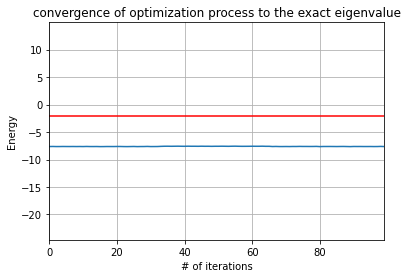

In [40]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

##  Transverse Ising Model 3 qubits

In [41]:
QUBITS_NUM = 3 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
MAX_NUM_ITERATIONS = 50

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [42]:
from qiskit.opflow import X, Z, I

transverse_ising_3_qubits = 0.0 * (I^I^I) \
                    + 0.012764169333459807 * (X^I^I) \
                    + 0.7691573729160869 * (I^X^I) \
                    + 0.398094746026449 * (Z^Z^I) \
                    + 0.15250261906586637 * (I^I^X) \
                    + 0.2094051920882264 * (Z^I^Z) \
                    + 0.5131291860752999 * (I^Z^Z)

In [43]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_3_qubits, "linear")

[6.2218652  5.17095943 4.5131657  4.39612371 4.15676763 3.6511157
 4.72533184 4.25084791 2.59733448 5.74637366 1.31836518 0.4212345
 5.94814796 0.01898122 3.941659   1.08247983 5.17816955 0.2640115
 5.82997757 0.98081299 2.30443733 5.46957092 5.16478056 0.45729349]
thetas:
[6.2218652  5.17095943 4.5131657  4.39612371 4.15676763 3.6511157
 4.72533184 4.25084791 2.59733448 5.74637366 1.31836518 0.4212345
 5.94814796 0.01898122 3.941659   1.08247983 5.17816955 0.2640115
 5.82997757 0.98081299 2.30443733 5.46957092 5.16478056 0.45729349]
0.956633545095086
thetas:
[6.22186522 5.17095943 4.5131657  4.39612371 4.15676763 3.6511157
 4.72533184 4.25084791 2.59733448 5.74637366 1.31836518 0.4212345
 5.94814796 0.01898122 3.941659   1.08247983 5.17816955 0.2640115
 5.82997757 0.98081299 2.30443733 5.46957092 5.16478056 0.45729349]
0.9366477783083949
thetas:
[6.2218652  5.17095944 4.5131657  4.39612371 4.15676763 3.6511157
 4.72533184 4.25084791 2.59733448 5.74637366 1.31836518 0.4212345
 5.948147

1.0079729692812618
thetas:
[6.30316497 5.32906479 4.70640874 4.60218497 4.43837267 3.78750387
 4.99910863 4.31585813 2.81689984 5.95126618 1.51813353 0.33029932
 6.01804174 0.2472555  4.10340027 1.19789606 5.51149112 0.50076825
 6.05596181 1.30850409 2.55015121 5.7629822  5.29891361 0.53914271]
1.0039689455837015
thetas:
[6.30316497 5.32906479 4.70640873 4.60218499 4.43837267 3.78750387
 4.99910863 4.31585813 2.81689984 5.95126618 1.51813353 0.33029932
 6.01804174 0.2472555  4.10340027 1.19789606 5.51149112 0.50076825
 6.05596181 1.30850409 2.55015121 5.7629822  5.29891361 0.53914271]
1.0260625206670528
thetas:
[6.30316497 5.32906479 4.70640873 4.60218497 4.43837268 3.78750387
 4.99910863 4.31585813 2.81689984 5.95126618 1.51813353 0.33029932
 6.01804174 0.2472555  4.10340027 1.19789606 5.51149112 0.50076825
 6.05596181 1.30850409 2.55015121 5.7629822  5.29891361 0.53914271]
1.019388240375414
thetas:
[6.30316497 5.32906479 4.70640873 4.60218497 4.43837267 3.78750389
 4.99910863 4.31585

0.9888558566849422
thetas:
[6.25146393 5.22852069 4.58351951 4.47114424 4.25929131 3.70077042
 4.82500549 4.27451612 2.67727143 5.82096868 1.39109465 0.38812781
 5.97359412 0.10208882 4.00054399 1.12449931 5.29952162 0.3502073
 5.91225143 1.10011518 2.39389414 5.57639288 5.21361425 0.48709226]
0.956842609948429
thetas:
[6.25146393 5.22852069 4.58351951 4.47114424 4.25929131 3.70077041
 4.82500551 4.27451612 2.67727143 5.82096868 1.39109465 0.38812781
 5.97359412 0.10208882 4.00054399 1.12449931 5.29952162 0.3502073
 5.91225143 1.10011518 2.39389414 5.57639288 5.21361425 0.48709226]
0.985255927969408
thetas:
[6.25146393 5.22852069 4.58351951 4.47114424 4.25929131 3.70077041
 4.82500549 4.27451613 2.67727143 5.82096868 1.39109465 0.38812781
 5.97359412 0.10208882 4.00054399 1.12449931 5.29952162 0.3502073
 5.91225143 1.10011518 2.39389414 5.57639288 5.21361425 0.48709226]
0.9675387957512416
thetas:
[6.25146393 5.22852069 4.58351951 4.47114424 4.25929131 3.70077041
 4.82500549 4.27451612 

0.9439536075746073
thetas:
[6.23029284 5.18734884 4.53319753 4.41748429 4.18595918 3.66525387
 4.7537119  4.25758696 2.62009493 5.76761309 1.33907343 0.41180804
 5.95539324 0.04264444 3.95842532 1.09444403 5.21272211 0.28855401
 5.85340339 1.01478188 2.32990835 5.49998632 5.17868497 0.46577808]
0.929546012896636
thetas:
[6.23029284 5.18734884 4.53319753 4.41748429 4.18595918 3.66525387
 4.7537119  4.25758696 2.62009492 5.7676131  1.33907343 0.41180804
 5.95539324 0.04264444 3.95842532 1.09444403 5.21272211 0.28855401
 5.85340339 1.01478188 2.32990835 5.49998632 5.17868497 0.46577808]
0.9141842484283529
thetas:
[6.23029284 5.18734884 4.53319753 4.41748429 4.18595918 3.66525387
 4.7537119  4.25758696 2.62009492 5.76761309 1.33907345 0.41180804
 5.95539324 0.04264444 3.95842532 1.09444403 5.21272211 0.28855401
 5.85340339 1.01478188 2.32990835 5.49998632 5.17868497 0.46577808]
0.8978166980312823
thetas:
[6.23029284 5.18734884 4.53319753 4.41748429 4.18595918 3.66525387
 4.7537119  4.25758

0.8723468562219351
thetas:
[6.22418508 5.17547094 4.51867986 4.40200364 4.16480319 3.65500751
 4.73314402 4.25270297 2.60359975 5.75222023 1.32406554 0.41863969
 5.95014237 0.025495   3.94627427 1.08577321 5.18768083 0.27076732
 5.836426   0.99016361 2.31144874 5.47794337 5.16860803 0.45962904]
0.9312902879071498
thetas:
[6.22418508 5.17547094 4.51867986 4.40200364 4.16480319 3.65500751
 4.73314402 4.25270297 2.60359975 5.75222023 1.32406554 0.41863967
 5.95014238 0.025495   3.94627427 1.08577321 5.18768083 0.27076732
 5.836426   0.99016361 2.31144874 5.47794337 5.16860803 0.45962904]
0.8856682432496481
thetas:
[6.22418508 5.17547094 4.51867986 4.40200364 4.16480319 3.65500751
 4.73314402 4.25270297 2.60359975 5.75222023 1.32406554 0.41863967
 5.95014237 0.02549501 3.94627427 1.08577321 5.18768083 0.27076732
 5.836426   0.99016361 2.31144874 5.47794337 5.16860803 0.45962904]
0.9251102133358936
thetas:
[6.22418508 5.17547094 4.51867986 4.40200364 4.16480319 3.65500751
 4.73314402 4.2527

0.9225482536891398
thetas:
[6.22247886 5.17215283 4.51462433 4.39767909 4.15889322 3.65214517
 4.72739834 4.25133862 2.59899179 5.74792021 1.31987306 0.4205481
 5.94867552 0.02070427 3.94287986 1.08335101 5.18068551 0.26579857
 5.83168333 0.98328645 2.30629201 5.47178562 5.16579301 0.45791129]
0.900032295949676
thetas:
[6.22247886 5.17215283 4.51462433 4.39767909 4.15889322 3.65214517
 4.72739834 4.25133862 2.59899179 5.74792021 1.31987306 0.4205481
 5.94867552 0.02070427 3.94287985 1.08335102 5.18068551 0.26579857
 5.83168333 0.98328645 2.30629201 5.47178562 5.16579301 0.45791129]
0.9017267175223587
thetas:
[6.22247886 5.17215283 4.51462433 4.39767909 4.15889322 3.65214517
 4.72739834 4.25133862 2.59899179 5.74792021 1.31987306 0.4205481
 5.94867552 0.02070427 3.94287985 1.08335101 5.18068552 0.26579857
 5.83168333 0.98328645 2.30629201 5.47178562 5.16579301 0.45791129]
0.8953270687743897
thetas:
[6.22247886 5.17215283 4.51462433 4.39767909 4.15889322 3.65214517
 4.72739834 4.25133862

0.9114614625097345
thetas:
[6.22207673 5.17137078 4.51366848 4.39665983 4.1575003  3.65147055
 4.72604414 4.25101706 2.59790574 5.74690674 1.31888493 0.4209979
 5.9483298  0.01957514 3.94207982 1.08278012 5.17903678 0.2646275
 5.83056553 0.98166557 2.30507662 5.47033431 5.16512954 0.45750644]
0.8967204883832449
thetas:
[6.22207673 5.17137078 4.51366848 4.39665983 4.1575003  3.65147055
 4.72604414 4.25101706 2.59790574 5.74690674 1.31888493 0.4209979
 5.9483298  0.01957514 3.94207982 1.08278012 5.17903678 0.26462748
 5.83056554 0.98166557 2.30507662 5.47033431 5.16512954 0.45750644]
0.9386565813996816
thetas:
[6.22207673 5.17137078 4.51366848 4.39665983 4.1575003  3.65147055
 4.72604414 4.25101706 2.59790574 5.74690674 1.31888493 0.4209979
 5.9483298  0.01957514 3.94207982 1.08278012 5.17903678 0.26462748
 5.83056553 0.98166559 2.30507662 5.47033431 5.16512954 0.45750644]
0.9352948189303012
thetas:
[6.22207673 5.17137078 4.51366848 4.39665983 4.1575003  3.65147055
 4.72604414 4.25101706

0.9133085261430924
thetas:
[6.22193135 5.17108807 4.51332294 4.39629138 4.15699676 3.65122667
 4.7255546  4.25090081 2.59751314 5.74654037 1.31852773 0.4211605
 5.94820483 0.01916697 3.94179061 1.08257374 5.17844077 0.26420414
 5.83016145 0.98107963 2.30463727 5.46980966 5.1648897  0.45736009]
0.9320452382908345
thetas:
[6.22193135 5.17108807 4.51332294 4.39629138 4.15699676 3.65122667
 4.7255546  4.25090081 2.59751314 5.74654037 1.31852773 0.4211605
 5.94820483 0.01916697 3.94179061 1.08257374 5.17844077 0.26420414
 5.83016145 0.98107963 2.30463726 5.46980967 5.1648897  0.45736009]
0.8596555512779671
thetas:
[6.22193135 5.17108807 4.51332294 4.39629138 4.15699676 3.65122667
 4.7255546  4.25090081 2.59751314 5.74654037 1.31852773 0.4211605
 5.94820483 0.01916697 3.94179061 1.08257374 5.17844077 0.26420414
 5.83016145 0.98107963 2.30463726 5.46980966 5.16488972 0.45736009]
0.95163999384046
thetas:
[6.22193135 5.17108807 4.51332294 4.39629138 4.15699676 3.65122667
 4.7255546  4.25090081 

0.9134483974397004
thetas:
[6.2218894  5.17100647 4.51322321 4.39618503 4.15685143 3.65115628
 4.72541331 4.25086726 2.59739982 5.74643463 1.31842463 0.42120743
 5.94816876 0.01904916 3.94170713 1.08251417 5.17826874 0.26408195
 5.83004482 0.98091051 2.30451045 5.46965823 5.16482048 0.45731786]
0.9111152022464923
thetas:
[6.2218707  5.17097013 4.51317878 4.39613765 4.15678669 3.65112493
 4.72535037 4.25085231 2.59734934 5.74638752 1.3183787  0.42122834
 5.94815269 0.01899667 3.94166995 1.08248764 5.17819211 0.26402752
 5.82999286 0.98083517 2.30445396 5.46959078 5.16478964 0.45729903]
0.9277032400063397
thetas:
[6.22187072 5.17097013 4.51317878 4.39613765 4.15678669 3.65112493
 4.72535037 4.25085231 2.59734934 5.74638752 1.3183787  0.42122834
 5.94815269 0.01899667 3.94166995 1.08248764 5.17819211 0.26402752
 5.82999286 0.98083517 2.30445396 5.46959078 5.16478964 0.45729903]
0.904647006526133
thetas:
[6.2218707  5.17097014 4.51317878 4.39613765 4.15678669 3.65112493
 4.72535037 4.25085

0.9268362006723211
thetas:
[6.22186687 5.17096268 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084925 2.59733898 5.74637785 1.31836927 0.42123263
 5.94814939 0.0189859  3.94166231 1.08248219 5.17817638 0.26401634
 5.82998219 0.9808197  2.30444236 5.46957693 5.16478331 0.45729516]
0.8742126133898525
thetas:
[6.22186687 5.17096266 4.51316967 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084925 2.59733898 5.74637785 1.31836927 0.42123263
 5.94814939 0.0189859  3.94166231 1.08248219 5.17817638 0.26401634
 5.82998219 0.9808197  2.30444236 5.46957693 5.16478331 0.45729516]
0.8866079173688826
thetas:
[6.22186687 5.17096266 4.51316966 4.39612794 4.15677339 3.65111849
 4.72533744 4.25084925 2.59733898 5.74637785 1.31836927 0.42123263
 5.94814939 0.0189859  3.94166231 1.08248219 5.17817638 0.26401634
 5.82998219 0.9808197  2.30444236 5.46957693 5.16478331 0.45729516]
0.9084818168104027
thetas:
[6.22186687 5.17096266 4.51316966 4.39612793 4.15677341 3.65111849
 4.72533744 4.2508

0.9378968329473439
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677341 3.65111849
 4.72533744 4.25084924 2.59733898 5.74637785 1.31836927 0.42123263
 5.94814939 0.0189859  3.94166232 1.08248219 5.17817638 0.26401634
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478331 0.45729516]
0.9204452434611325
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111851
 4.72533744 4.25084924 2.59733898 5.74637785 1.31836927 0.42123263
 5.94814939 0.0189859  3.94166232 1.08248219 5.17817638 0.26401634
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478331 0.45729516]
0.8971019034830048
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533746 4.25084924 2.59733898 5.74637785 1.31836927 0.42123263
 5.94814939 0.0189859  3.94166232 1.08248219 5.17817638 0.26401634
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478331 0.45729516]
0.8776551948556379
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.2508

0.9422872727435533
thetas:
[6.22186686 5.17096267 4.51316966 4.39612793 4.15677339 3.6511185
 4.72533744 4.25084926 2.59733898 5.74637786 1.31836928 0.42123263
 5.94814939 0.01898591 3.94166232 1.08248219 5.17817638 0.26401635
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478331 0.45729515]
0.9306919745173862
thetas:
[6.22186686 5.17096267 4.51316966 4.39612793 4.15677339 3.6511185
 4.72533744 4.25084924 2.59733899 5.74637786 1.31836928 0.42123263
 5.94814939 0.01898591 3.94166232 1.08248219 5.17817638 0.26401635
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478331 0.45729515]
0.9306064589174463
thetas:
[6.22186686 5.17096267 4.51316966 4.39612793 4.15677339 3.6511185
 4.72533744 4.25084924 2.59733898 5.74637787 1.31836928 0.42123263
 5.94814939 0.01898591 3.94166232 1.08248219 5.17817638 0.26401635
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478331 0.45729515]
0.9158433122342815
thetas:
[6.22186686 5.17096267 4.51316966 4.39612793 4.15677339 3.6511185
 4.72533744 4.25084924

0.880419252725964
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084924 2.59733898 5.74637785 1.31836929 0.42123263
 5.94814939 0.0189859  3.94166232 1.08248219 5.17817638 0.26401634
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478331 0.45729516]
0.9135238095767434
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084924 2.59733898 5.74637785 1.31836928 0.42123265
 5.94814939 0.0189859  3.94166232 1.08248219 5.17817638 0.26401634
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478331 0.45729516]
0.9418429204610019
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084924 2.59733898 5.74637785 1.31836928 0.42123263
 5.9481494  0.0189859  3.94166232 1.08248219 5.17817638 0.26401634
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478331 0.45729516]
0.9191155727560147
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084

0.9289933636667599
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084924 2.59733898 5.74637785 1.31836927 0.42123263
 5.94814939 0.01898592 3.94166232 1.08248219 5.17817638 0.26401634
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478331 0.45729516]
0.9298334237899116
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084924 2.59733898 5.74637785 1.31836927 0.42123263
 5.94814939 0.0189859  3.94166233 1.08248219 5.17817638 0.26401634
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478331 0.45729516]
0.9164410168333359
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084924 2.59733898 5.74637785 1.31836927 0.42123263
 5.94814939 0.0189859  3.94166232 1.08248221 5.17817638 0.26401634
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478331 0.45729516]
0.924143670056449
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084

0.9344538456210855
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084924 2.59733898 5.74637785 1.31836927 0.42123263
 5.94814939 0.0189859  3.94166232 1.08248219 5.17817639 0.26401634
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478331 0.45729516]
0.9114023087444134
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084924 2.59733898 5.74637785 1.31836927 0.42123263
 5.94814939 0.0189859  3.94166232 1.08248219 5.17817638 0.26401636
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478331 0.45729516]
0.902463887557548
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084924 2.59733898 5.74637785 1.31836927 0.42123263
 5.94814939 0.0189859  3.94166232 1.08248219 5.17817638 0.26401634
 5.82998221 0.9808197  2.30444235 5.46957693 5.16478331 0.45729516]
0.9523144296230941
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084

0.9370967257293628
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084924 2.59733898 5.74637785 1.31836927 0.42123263
 5.94814939 0.0189859  3.94166232 1.08248219 5.17817638 0.26401634
 5.8299822  0.98081972 2.30444235 5.46957693 5.16478331 0.45729516]
0.9104451586720383
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084924 2.59733898 5.74637785 1.31836927 0.42123263
 5.94814939 0.0189859  3.94166232 1.08248219 5.17817638 0.26401634
 5.8299822  0.9808197  2.30444237 5.46957693 5.16478331 0.45729516]
0.882823467848035
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084924 2.59733898 5.74637785 1.31836927 0.42123263
 5.94814939 0.0189859  3.94166232 1.08248219 5.17817638 0.26401634
 5.8299822  0.9808197  2.30444235 5.46957694 5.16478331 0.45729516]
0.9481033067030723
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084

0.961626183163648
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084924 2.59733898 5.74637785 1.31836927 0.42123263
 5.94814939 0.0189859  3.94166232 1.08248219 5.17817638 0.26401634
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478332 0.45729516]
0.9048953777003019
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084924 2.59733898 5.74637785 1.31836927 0.42123263
 5.94814939 0.0189859  3.94166232 1.08248219 5.17817638 0.26401634
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478331 0.45729517]
0.9069670165092623
thetas:
[6.22186686 5.17096267 4.51316966 4.39612793 4.15677339 3.6511185
 4.72533744 4.25084924 2.59733898 5.74637786 1.31836928 0.42123263
 5.94814939 0.01898591 3.94166232 1.08248219 5.17817638 0.26401635
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478331 0.45729515]
0.9254784432255745
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.250849

0.9413751780403565
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084924 2.59733898 5.74637785 1.31836927 0.42123263
 5.94814939 0.0189859  3.94166232 1.08248219 5.17817638 0.26401634
 5.8299822  0.9808197  2.30444237 5.46957693 5.16478331 0.45729516]
0.8834216797726804
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084924 2.59733898 5.74637785 1.31836927 0.42123263
 5.94814939 0.0189859  3.94166232 1.08248219 5.17817638 0.26401634
 5.8299822  0.9808197  2.30444235 5.46957694 5.16478331 0.45729516]
0.9331508411459413
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084924 2.59733898 5.74637785 1.31836927 0.42123263
 5.94814939 0.0189859  3.94166232 1.08248219 5.17817638 0.26401634
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478332 0.45729516]
0.9417440167207468
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.2508

0.9372360897003797
thetas:
[6.22186686 5.17096267 4.51316966 4.39612793 4.15677339 3.6511185
 4.72533744 4.25084924 2.59733898 5.74637786 1.31836928 0.42123263
 5.94814939 0.01898591 3.94166232 1.08248219 5.17817638 0.26401634
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478331 0.45729517]
0.9382074310484773
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084924 2.59733898 5.74637785 1.31836928 0.42123263
 5.94814939 0.0189859  3.94166232 1.08248219 5.17817638 0.26401634
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478331 0.45729516]
0.905182484198223
thetas:
[6.22186688 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084924 2.59733898 5.74637785 1.31836928 0.42123263
 5.94814939 0.0189859  3.94166232 1.08248219 5.17817638 0.26401634
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478331 0.45729516]
0.9186611170105663
thetas:
[6.22186687 5.17096268 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.250849

0.9059375360470259
thetas:
[6.22186687 5.17096268 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084924 2.59733898 5.74637785 1.31836927 0.42123263
 5.94814939 0.0189859  3.94166232 1.08248219 5.17817638 0.26401634
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478331 0.45729516]
0.9054169599064857
thetas:
[6.22186687 5.17096267 4.51316968 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084924 2.59733898 5.74637785 1.31836927 0.42123263
 5.94814939 0.0189859  3.94166232 1.08248219 5.17817638 0.26401634
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478331 0.45729516]
0.9319010762511647
thetas:
[6.22186687 5.17096267 4.51316966 4.39612794 4.15677339 3.65111849
 4.72533744 4.25084924 2.59733898 5.74637785 1.31836927 0.42123263
 5.94814939 0.0189859  3.94166232 1.08248219 5.17817638 0.26401634
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478331 0.45729516]
0.8932826035209942
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677341 3.65111849
 4.72533744 4.2508

0.945891289271913
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677341 3.65111849
 4.72533744 4.25084924 2.59733898 5.74637785 1.31836927 0.42123263
 5.94814939 0.0189859  3.94166232 1.08248219 5.17817638 0.26401634
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478331 0.45729516]
0.9214477532980405
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111851
 4.72533744 4.25084924 2.59733898 5.74637785 1.31836927 0.42123263
 5.94814939 0.0189859  3.94166232 1.08248219 5.17817638 0.26401634
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478331 0.45729516]
0.9176229450115496
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533746 4.25084924 2.59733898 5.74637785 1.31836927 0.42123263
 5.94814939 0.0189859  3.94166232 1.08248219 5.17817638 0.26401634
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478331 0.45729516]
0.9039295360911465
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084

0.9429206395047164
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084926 2.59733898 5.74637785 1.31836927 0.42123263
 5.94814939 0.0189859  3.94166232 1.08248219 5.17817638 0.26401634
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478331 0.45729516]
0.934637047379862
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084924 2.59733899 5.74637785 1.31836927 0.42123263
 5.94814939 0.0189859  3.94166232 1.08248219 5.17817638 0.26401634
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478331 0.45729516]
0.9096458631750031
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084924 2.59733898 5.74637787 1.31836927 0.42123263
 5.94814939 0.0189859  3.94166232 1.08248219 5.17817638 0.26401634
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478331 0.45729516]
0.9422877800691445
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084

0.916850417209606
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084926 2.59733898 5.74637785 1.31836927 0.42123263
 5.94814939 0.0189859  3.94166232 1.08248219 5.17817638 0.26401634
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478331 0.45729516]
0.8837321764086954
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084924 2.59733899 5.74637785 1.31836927 0.42123263
 5.94814939 0.0189859  3.94166232 1.08248219 5.17817638 0.26401634
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478331 0.45729516]
0.9523774682710041
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084924 2.59733898 5.74637787 1.31836927 0.42123263
 5.94814939 0.0189859  3.94166232 1.08248219 5.17817638 0.26401634
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478331 0.45729516]
0.9191563373821311
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084

0.8892326112681916
thetas:
[6.22186686 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084924 2.59733898 5.74637785 1.31836929 0.42123263
 5.94814939 0.0189859  3.94166232 1.08248219 5.17817638 0.26401634
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478331 0.45729515]
0.9168815856984165
thetas:
[6.22186686 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084924 2.59733898 5.74637785 1.31836928 0.42123264
 5.94814939 0.0189859  3.94166232 1.08248219 5.17817638 0.26401634
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478331 0.45729515]
0.9156819786368257
thetas:
[6.22186686 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084924 2.59733898 5.74637785 1.31836928 0.42123263
 5.9481494  0.0189859  3.94166232 1.08248219 5.17817638 0.26401634
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478331 0.45729515]
0.8817091734561477
thetas:
[6.22186686 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.2508

0.8953854108187649
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084924 2.59733898 5.74637785 1.31836927 0.42123263
 5.94814939 0.01898592 3.94166232 1.08248219 5.17817638 0.26401634
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478331 0.45729516]
0.9372230059554192
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084924 2.59733898 5.74637785 1.31836927 0.42123263
 5.94814939 0.0189859  3.94166233 1.08248219 5.17817638 0.26401634
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478331 0.45729516]
0.8958799209345022
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084924 2.59733898 5.74637785 1.31836927 0.42123263
 5.94814939 0.0189859  3.94166232 1.08248221 5.17817638 0.26401634
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478331 0.45729516]
0.899192134361406
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084

0.8927068685483788
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084924 2.59733898 5.74637785 1.31836927 0.42123263
 5.94814939 0.0189859  3.94166232 1.08248219 5.17817639 0.26401634
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478331 0.45729516]
0.9444405422698645
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084924 2.59733898 5.74637785 1.31836927 0.42123263
 5.94814939 0.0189859  3.94166232 1.08248219 5.17817638 0.26401636
 5.8299822  0.9808197  2.30444235 5.46957693 5.16478331 0.45729516]
0.8955921041807535
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084924 2.59733898 5.74637785 1.31836927 0.42123263
 5.94814939 0.0189859  3.94166232 1.08248219 5.17817638 0.26401634
 5.82998221 0.9808197  2.30444235 5.46957693 5.16478331 0.45729516]
0.931214469909634
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084

0.8869637737694304
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084924 2.59733898 5.74637785 1.31836927 0.42123263
 5.94814939 0.0189859  3.94166232 1.08248219 5.17817638 0.26401634
 5.8299822  0.98081972 2.30444235 5.46957693 5.16478331 0.45729516]
0.9170841826620411
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084924 2.59733898 5.74637785 1.31836927 0.42123263
 5.94814939 0.0189859  3.94166232 1.08248219 5.17817638 0.26401634
 5.8299822  0.9808197  2.30444237 5.46957693 5.16478331 0.45729516]
0.8866892436908789
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084924 2.59733898 5.74637785 1.31836927 0.42123263
 5.94814939 0.0189859  3.94166232 1.08248219 5.17817638 0.26401634
 5.8299822  0.9808197  2.30444235 5.46957694 5.16478331 0.45729516]
0.930099169452103
thetas:
[6.22186687 5.17096267 4.51316966 4.39612793 4.15677339 3.65111849
 4.72533744 4.25084

CPU times: total: 3min 34s
Wall time: 3min 35s


[(1.4283924798262082+0j), (1.4216636087077101+0j), (0.5543478038595204+0j), (0.5479228225821259+0j), (-0.8433012058342556+0j), (-0.8673630797839832+0j), (-1.1089522226243493+0j), (-1.1327102067329746+0j)]
Exact Eigenvalue:
(-1.1327102067329746+0j)

Approximated Eigenvalue:
0.8932094614101872

Approximation Error
0.21144044072275883


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


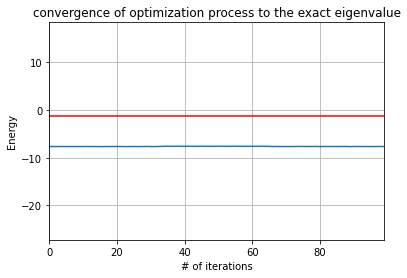

In [44]:
compare_exact_and_approximated_eigenvalue(transverse_ising_3_qubits, TI_approximated_eigenvalue)

In [45]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_3_qubits, "full")

[1.59986085 5.08752188 3.59088501 4.84172948 1.83598206 2.85537394
 2.39632273 2.27245202 5.6113827  1.65115126 4.70568387 0.8012777
 2.35975307 3.28294868 4.4691559  1.62949372 2.79370533 1.24803047
 3.17445476 1.0866699  2.17442182 1.90193144 0.4186309  4.81356438]
thetas:
[1.59986085 5.08752188 3.59088501 4.84172948 1.83598206 2.85537394
 2.39632273 2.27245202 5.6113827  1.65115126 4.70568387 0.8012777
 2.35975307 3.28294868 4.4691559  1.62949372 2.79370533 1.24803047
 3.17445476 1.0866699  2.17442182 1.90193144 0.4186309  4.81356438]
0.7088316626119641
thetas:
[1.59986087 5.08752188 3.59088501 4.84172948 1.83598206 2.85537394
 2.39632273 2.27245202 5.6113827  1.65115126 4.70568387 0.8012777
 2.35975307 3.28294868 4.4691559  1.62949372 2.79370533 1.24803047
 3.17445476 1.0866699  2.17442182 1.90193144 0.4186309  4.81356438]
0.6976188956018571
thetas:
[1.59986085 5.08752189 3.59088501 4.84172948 1.83598206 2.85537394
 2.39632273 2.27245202 5.6113827  1.65115126 4.70568387 0.8012777
 

0.9377150602857611
thetas:
[1.68266951 5.21312094 3.61481967 5.11502577 2.30690862 3.0856564
 2.78267347 2.4086059  5.64776608 1.86586487 4.60545307 0.80997474
 2.62989679 3.37919986 4.54400313 1.75960208 2.73702103 1.28660587
 3.6039529  1.25425954 2.447288   2.05878903 0.43124861 4.84188302]
0.945935309367351
thetas:
[1.68266951 5.21312093 3.61481968 5.11502577 2.30690862 3.0856564
 2.78267347 2.4086059  5.64776608 1.86586487 4.60545307 0.80997474
 2.62989679 3.37919986 4.54400313 1.75960208 2.73702103 1.28660587
 3.6039529  1.25425954 2.447288   2.05878903 0.43124861 4.84188302]
0.9154900010472278
thetas:
[1.68266951 5.21312093 3.61481967 5.11502579 2.30690862 3.0856564
 2.78267347 2.4086059  5.64776608 1.86586487 4.60545307 0.80997474
 2.62989679 3.37919986 4.54400313 1.75960208 2.73702103 1.28660587
 3.6039529  1.25425954 2.447288   2.05878903 0.43124861 4.84188302]
0.9345874691292889
thetas:
[1.68266951 5.21312093 3.61481967 5.11502577 2.30690863 3.0856564
 2.78267347 2.4086059  

0.7374280809266014
thetas:
[1.62525973 5.12604532 3.59822619 4.92555428 1.98042356 2.92600563
 2.51482332 2.31421282 5.62254212 1.71700771 4.67494131 0.80394523
 2.44261092 3.31247061 4.49211286 1.66940025 2.77631925 1.25986223
 3.30618942 1.1380726  2.25811469 1.95004243 0.42250097 4.82225021]
0.7484889161318606
thetas:
[1.62525973 5.12604532 3.59822619 4.92555428 1.98042355 2.92600565
 2.51482332 2.31421282 5.62254212 1.71700771 4.67494131 0.80394523
 2.44261092 3.31247061 4.49211286 1.66940025 2.77631925 1.25986223
 3.30618942 1.1380726  2.25811469 1.95004243 0.42250097 4.82225021]
0.772802388462206
thetas:
[1.62525973 5.12604532 3.59822619 4.92555428 1.98042355 2.92600563
 2.51482334 2.31421282 5.62254212 1.71700771 4.67494131 0.80394523
 2.44261092 3.31247061 4.49211286 1.66940025 2.77631925 1.25986223
 3.30618942 1.1380726  2.25811469 1.95004243 0.42250097 4.82225021]
0.767260580185884
thetas:
[1.62525973 5.12604532 3.59822619 4.92555428 1.98042355 2.92600563
 2.51482332 2.314212

0.7260177093662205
thetas:
[1.60747884 5.09907637 3.59308688 4.86687138 1.87930497 2.87655878
 2.43186508 2.28497752 5.61472979 1.67090385 4.69646313 0.80207778
 2.38460495 3.29180331 4.47604147 1.64146305 2.78849065 1.25157922
 3.21396646 1.10208731 2.19952416 1.91636156 0.41979166 4.81616956]
0.6952404421092344
thetas:
[1.60747884 5.09907637 3.59308688 4.86687138 1.87930497 2.87655878
 2.43186508 2.2849775  5.61472981 1.67090385 4.69646313 0.80207778
 2.38460495 3.29180331 4.47604147 1.64146305 2.78849065 1.25157922
 3.21396646 1.10208731 2.19952416 1.91636156 0.41979166 4.81616956]
0.6992721466879505
thetas:
[1.60747884 5.09907637 3.59308688 4.86687138 1.87930497 2.87655878
 2.43186508 2.2849775  5.61472979 1.67090386 4.69646313 0.80207778
 2.38460495 3.29180331 4.47604147 1.64146305 2.78849065 1.25157922
 3.21396646 1.10208731 2.19952416 1.91636156 0.41979166 4.81616956]
0.7061032669037469
thetas:
[1.60747884 5.09907637 3.59308688 4.86687138 1.87930497 2.87655878
 2.43186508 2.2849

0.7007058235973311
thetas:
[1.6025668  5.09162609 3.59166713 4.85066002 1.85137059 2.86289891
 2.40894756 2.27690114 5.61257161 1.65816749 4.70240863 0.80156189
 2.36858059 3.28609389 4.47160169 1.63374529 2.79185305 1.24929101
 3.18848952 1.09214624 2.1833383  1.90705709 0.41904321 4.81448975]
0.6550661000564523
thetas:
[1.6025668  5.09162609 3.59166713 4.85066002 1.85137059 2.86289891
 2.40894756 2.27690114 5.61257161 1.65816749 4.70240862 0.80156191
 2.36858059 3.28609389 4.47160169 1.63374529 2.79185305 1.24929101
 3.18848952 1.09214624 2.1833383  1.90705709 0.41904321 4.81448975]
0.6431657120536323
thetas:
[1.6025668  5.09162609 3.59166713 4.85066002 1.85137059 2.86289891
 2.40894756 2.27690114 5.61257161 1.65816749 4.70240862 0.80156189
 2.3685806  3.28609389 4.47160169 1.63374529 2.79185305 1.24929101
 3.18848952 1.09214624 2.1833383  1.90705709 0.41904321 4.81448975]
0.7434105595331222
thetas:
[1.6025668  5.09162609 3.59166713 4.85066002 1.85137059 2.86289891
 2.40894756 2.2769

0.7081526316909135
thetas:
[1.60050726 5.08850231 3.59107185 4.84386284 1.83965813 2.85717153
 2.39933859 2.27351485 5.61166671 1.65282732 4.70490147 0.80134559
 2.36186182 3.28370003 4.46974016 1.63050935 2.79326285 1.24833159
 3.17780744 1.08797811 2.17655182 1.90315587 0.41872939 4.81378544]
0.7069255466784032
thetas:
[1.60050726 5.08850231 3.59107185 4.84386284 1.83965813 2.85717153
 2.39933859 2.27351485 5.61166671 1.65282732 4.70490147 0.80134559
 2.36186182 3.28370002 4.46974017 1.63050935 2.79326285 1.24833159
 3.17780744 1.08797811 2.17655182 1.90315587 0.41872939 4.81378544]
0.6539299375032442
thetas:
[1.60050726 5.08850231 3.59107185 4.84386284 1.83965813 2.85717153
 2.39933859 2.27351485 5.61166671 1.65282732 4.70490147 0.80134559
 2.36186182 3.28370002 4.46974016 1.63050937 2.79326285 1.24833159
 3.17780744 1.08797811 2.17655182 1.90315587 0.41872939 4.81378544]
0.6990920180908171
thetas:
[1.60050726 5.08850231 3.59107185 4.84386284 1.83965813 2.85717153
 2.39933859 2.2735

0.6955506343498947
thetas:
[1.60015901 5.0879741  3.59097119 4.8427135  1.83767766 2.85620308
 2.39771381 2.27294225 5.6115137  1.65192435 4.70532298 0.80130901
 2.36072574 3.28329523 4.46942539 1.62996219 2.79350125 1.24816937
 3.17600119 1.08727331 2.17540429 1.90249622 0.41867633 4.81366635]
0.6687557169738461
thetas:
[1.60015901 5.0879741  3.59097119 4.8427135  1.83767766 2.85620308
 2.39771381 2.27294225 5.6115137  1.65192435 4.70532298 0.80130901
 2.36072574 3.28329523 4.46942539 1.62996219 2.79350123 1.24816938
 3.17600119 1.08727331 2.17540429 1.90249622 0.41867633 4.81366635]
0.669678422465531
thetas:
[1.60015901 5.0879741  3.59097119 4.8427135  1.83767766 2.85620308
 2.39771381 2.27294225 5.6115137  1.65192435 4.70532298 0.80130901
 2.36072574 3.28329523 4.46942539 1.62996219 2.79350123 1.24816937
 3.17600121 1.08727331 2.17540429 1.90249622 0.41867633 4.81366635]
0.6811691056967261
thetas:
[1.60015901 5.0879741  3.59097119 4.8427135  1.83767766 2.85620308
 2.39771381 2.27294

0.6682260520215911
thetas:
[1.59996475 5.08767947 3.59091505 4.84207239 1.83657295 2.85566288
 2.3968075  2.27262286 5.61142835 1.65142067 4.70555811 0.80128861
 2.36009203 3.28306945 4.46924981 1.62965697 2.7936342  1.24807887
 3.17499366 1.08688019 2.1747642  1.90212825 0.41864673 4.81359991]
0.6856325861386242
thetas:
[1.59996475 5.08767947 3.59091505 4.84207239 1.83657295 2.85566288
 2.3968075  2.27262286 5.61142835 1.65142067 4.70555811 0.80128861
 2.36009203 3.28306945 4.46924981 1.62965697 2.7936342  1.24807887
 3.17499366 1.08688018 2.17476421 1.90212825 0.41864673 4.81359991]
0.6492019289805734
thetas:
[1.59996475 5.08767947 3.59091505 4.84207239 1.83657295 2.85566288
 2.3968075  2.27262286 5.61142835 1.65142067 4.70555811 0.80128861
 2.36009203 3.28306945 4.46924981 1.62965697 2.7936342  1.24807887
 3.17499366 1.08688018 2.1747642  1.90212827 0.41864673 4.81359991]
0.7079454310033337
thetas:
[1.59996475 5.08767947 3.59091505 4.84207239 1.83657295 2.85566288
 2.3968075  2.2726

0.704127044227387
thetas:
[1.59989918 5.08758001 3.59089609 4.84185598 1.83620004 2.85548053
 2.39650156 2.27251504 5.61139954 1.65125065 4.70563748 0.80128172
 2.35987811 3.28299323 4.46919054 1.62955394 2.79367909 1.24804833
 3.17465356 1.08674747 2.17454812 1.90200404 0.41863675 4.81357749]
0.6556189522165647
thetas:
[1.59989918 5.08758001 3.59089609 4.84185598 1.83620004 2.85548053
 2.39650156 2.27251504 5.61139954 1.65125065 4.70563748 0.80128172
 2.35987811 3.28299323 4.46919054 1.62955394 2.79367909 1.24804833
 3.17465356 1.08674747 2.17454812 1.90200404 0.41863674 4.81357751]
0.7007051133415035
thetas:
[1.59987613 5.08754504 3.59088943 4.84177989 1.83606893 2.85541642
 2.39639399 2.27247714 5.61138941 1.65119087 4.70566538 0.8012793
 2.3598029  3.28296643 4.46916971 1.62951772 2.79369487 1.24803759
 3.17453398 1.08670081 2.17447216 1.90196037 0.41863322 4.81356961]
0.6995773379297214
thetas:
[1.59987614 5.08754504 3.59088943 4.84177989 1.83606893 2.85541642
 2.39639399 2.272477

0.7011686664842054
thetas:
[1.59986522 5.08752847 3.59088627 4.84174383 1.83600679 2.85538603
 2.39634302 2.27245917 5.61138461 1.65116254 4.70567861 0.80127815
 2.35976726 3.28295373 4.46915983 1.62950055 2.79370235 1.2480325
 3.17447731 1.0866787  2.17443615 1.90193968 0.41863156 4.81356587]
0.6807014647411989
thetas:
[1.5998652  5.08752849 3.59088627 4.84174383 1.83600679 2.85538603
 2.39634302 2.27245917 5.61138461 1.65116254 4.70567861 0.80127815
 2.35976726 3.28295373 4.46915983 1.62950055 2.79370235 1.2480325
 3.17447731 1.0866787  2.17443615 1.90193968 0.41863156 4.81356587]
0.7174155464448184
thetas:
[1.5998652  5.08752847 3.59088629 4.84174383 1.83600679 2.85538603
 2.39634302 2.27245917 5.61138461 1.65116254 4.70567861 0.80127815
 2.35976726 3.28295373 4.46915983 1.62950055 2.79370235 1.2480325
 3.17447731 1.0866787  2.17443615 1.90193968 0.41863156 4.81356587]
0.720547225414116
thetas:
[1.5998652  5.08752847 3.59088627 4.84174385 1.83600679 2.85538603
 2.39634302 2.27245917

0.7038560946360699
thetas:
[1.59986209 5.08752375 3.59088537 4.84173357 1.83598908 2.85537737
 2.39632849 2.27245405 5.61138324 1.65115446 4.70568238 0.80127783
 2.3597571  3.28295011 4.46915701 1.62949566 2.79370448 1.24803105
 3.17446116 1.08667239 2.17442589 1.90193378 0.41863108 4.8135648 ]
0.6773034313190005
thetas:
[1.59986209 5.08752375 3.59088537 4.84173355 1.8359891  2.85537737
 2.39632849 2.27245405 5.61138324 1.65115446 4.70568238 0.80127783
 2.3597571  3.28295011 4.46915701 1.62949566 2.79370448 1.24803105
 3.17446116 1.08667239 2.17442589 1.90193378 0.41863108 4.8135648 ]
0.6873890317080347
thetas:
[1.59986209 5.08752375 3.59088537 4.84173355 1.83598908 2.85537738
 2.39632849 2.27245405 5.61138324 1.65115446 4.70568238 0.80127783
 2.3597571  3.28295011 4.46915701 1.62949566 2.79370448 1.24803105
 3.17446116 1.08667239 2.17442589 1.90193378 0.41863108 4.8135648 ]
0.6758347010382204
thetas:
[1.59986209 5.08752375 3.59088537 4.84173355 1.83598908 2.85537737
 2.3963285  2.2724

0.6724100013860483
thetas:
[1.59986116 5.08752235 3.5908851  4.84173051 1.83598384 2.85537481
 2.3963242  2.27245254 5.61138284 1.65115207 4.70568349 0.80127773
 2.35975409 3.28294904 4.46915618 1.62949421 2.79370511 1.24803062
 3.17445638 1.08667053 2.17442285 1.90193203 0.41863094 4.81356449]
0.7016270071122428
thetas:
[1.59986116 5.08752235 3.5908851  4.84173051 1.83598384 2.85537481
 2.39632419 2.27245255 5.61138284 1.65115207 4.70568349 0.80127773
 2.35975409 3.28294904 4.46915618 1.62949421 2.79370511 1.24803062
 3.17445638 1.08667053 2.17442285 1.90193203 0.41863094 4.81356449]
0.6497273031897665
thetas:
[1.59986116 5.08752235 3.5908851  4.84173051 1.83598384 2.85537481
 2.39632419 2.27245254 5.61138285 1.65115207 4.70568349 0.80127773
 2.35975409 3.28294904 4.46915618 1.62949421 2.79370511 1.24803062
 3.17445638 1.08667053 2.17442285 1.90193203 0.41863094 4.81356449]
0.6543344383457433
thetas:
[1.59986116 5.08752235 3.5908851  4.84173051 1.83598384 2.85537481
 2.39632419 2.2724

0.6763604811078864
thetas:
[1.59986092 5.08752198 3.59088503 4.84172971 1.83598246 2.85537413
 2.39632305 2.27245214 5.61138273 1.65115146 4.70568379 0.8012777
 2.3597533  3.28294876 4.46915596 1.62949383 2.79370528 1.2480305
 3.17445512 1.08667004 2.17442205 1.90193157 0.41863091 4.81356441]
0.6704146793146564
thetas:
[1.59986092 5.08752198 3.59088503 4.84172971 1.83598246 2.85537413
 2.39632305 2.27245214 5.61138273 1.65115144 4.7056838  0.8012777
 2.3597533  3.28294876 4.46915596 1.62949383 2.79370528 1.2480305
 3.17445512 1.08667004 2.17442205 1.90193157 0.41863091 4.81356441]
0.682378410360741
thetas:
[1.59986092 5.08752198 3.59088503 4.84172971 1.83598246 2.85537413
 2.39632305 2.27245214 5.61138273 1.65115144 4.70568379 0.80127772
 2.3597533  3.28294876 4.46915596 1.62949383 2.79370528 1.2480305
 3.17445512 1.08667004 2.17442205 1.90193157 0.41863091 4.81356441]
0.6481987088878377
thetas:
[1.59986092 5.08752198 3.59088503 4.84172971 1.83598246 2.85537413
 2.39632305 2.27245214 5

0.6919684859828559
thetas:
[1.59986092 5.08752198 3.59088504 4.84172971 1.83598246 2.85537413
 2.39632305 2.27245214 5.61138273 1.65115144 4.70568379 0.80127771
 2.35975331 3.28294875 4.46915596 1.62949383 2.79370528 1.2480305
 3.17445512 1.08667004 2.17442205 1.90193157 0.41863091 4.81356441]
0.7211359426665738
thetas:
[1.59986092 5.08752198 3.59088504 4.84172971 1.83598246 2.85537413
 2.39632305 2.27245214 5.61138273 1.65115144 4.70568379 0.80127771
 2.3597533  3.28294877 4.46915596 1.62949383 2.79370528 1.2480305
 3.17445512 1.08667004 2.17442205 1.90193157 0.41863091 4.81356441]
0.6613488617854344
thetas:
[1.59986092 5.08752198 3.59088504 4.84172971 1.83598246 2.85537413
 2.39632305 2.27245214 5.61138273 1.65115144 4.70568379 0.80127771
 2.3597533  3.28294875 4.46915598 1.62949383 2.79370528 1.2480305
 3.17445512 1.08667004 2.17442205 1.90193157 0.41863091 4.81356441]
0.6905300110048223
thetas:
[1.59986092 5.08752198 3.59088504 4.84172971 1.83598246 2.85537413
 2.39632305 2.2724521

0.6850213919341365
thetas:
[1.59986092 5.08752198 3.59088504 4.84172971 1.83598246 2.85537413
 2.39632305 2.27245214 5.61138273 1.65115145 4.70568378 0.80127771
 2.35975329 3.28294876 4.46915596 1.62949385 2.79370528 1.2480305
 3.17445512 1.08667004 2.17442205 1.90193158 0.4186309  4.81356441]
0.7056760861789814
thetas:
[1.59986092 5.08752198 3.59088504 4.84172971 1.83598246 2.85537413
 2.39632305 2.27245214 5.61138273 1.65115145 4.70568378 0.80127771
 2.35975329 3.28294876 4.46915596 1.62949383 2.79370529 1.2480305
 3.17445512 1.08667004 2.17442205 1.90193158 0.4186309  4.81356441]
0.6740898172369972
thetas:
[1.59986092 5.08752198 3.59088504 4.84172971 1.83598246 2.85537413
 2.39632305 2.27245214 5.61138273 1.65115145 4.70568378 0.80127771
 2.35975329 3.28294876 4.46915596 1.62949383 2.79370528 1.24803052
 3.17445512 1.08667004 2.17442205 1.90193158 0.4186309  4.81356441]
0.7019336188656689
thetas:
[1.59986092 5.08752198 3.59088504 4.84172971 1.83598246 2.85537413
 2.39632305 2.272452

0.7058605055191766
thetas:
[1.59986092 5.08752198 3.59088504 4.84172971 1.83598246 2.85537413
 2.39632305 2.27245214 5.61138273 1.65115144 4.70568379 0.80127771
 2.3597533  3.28294875 4.46915596 1.62949383 2.79370528 1.2480305
 3.17445512 1.08667005 2.17442205 1.90193157 0.41863091 4.81356441]
0.6461735459597109
thetas:
[1.59986092 5.08752198 3.59088504 4.84172971 1.83598246 2.85537413
 2.39632305 2.27245214 5.61138273 1.65115144 4.70568379 0.80127771
 2.3597533  3.28294875 4.46915596 1.62949383 2.79370528 1.2480305
 3.17445512 1.08667004 2.17442207 1.90193157 0.41863091 4.81356441]
0.6924994699816476
thetas:
[1.59986092 5.08752198 3.59088504 4.84172971 1.83598246 2.85537413
 2.39632305 2.27245214 5.61138273 1.65115144 4.70568379 0.80127771
 2.3597533  3.28294875 4.46915596 1.62949383 2.79370528 1.2480305
 3.17445512 1.08667004 2.17442205 1.90193159 0.41863091 4.81356441]
0.6756814501868358
thetas:
[1.59986092 5.08752198 3.59088504 4.84172971 1.83598246 2.85537413
 2.39632305 2.2724521

0.6623923391786952
thetas:
[1.59986092 5.08752198 3.59088504 4.84172971 1.83598246 2.85537413
 2.39632305 2.27245214 5.61138273 1.65115144 4.70568379 0.80127771
 2.3597533  3.28294875 4.46915596 1.62949383 2.79370528 1.2480305
 3.17445512 1.08667004 2.17442205 1.90193157 0.41863092 4.81356441]
0.6592320661421777
thetas:
[1.59986092 5.08752198 3.59088504 4.84172971 1.83598246 2.85537413
 2.39632305 2.27245214 5.61138273 1.65115144 4.70568379 0.80127771
 2.3597533  3.28294875 4.46915596 1.62949383 2.79370528 1.2480305
 3.17445512 1.08667004 2.17442205 1.90193157 0.41863091 4.81356442]
0.6894926507267511
thetas:
[1.59986092 5.08752198 3.59088504 4.84172971 1.83598246 2.85537413
 2.39632305 2.27245214 5.61138273 1.65115144 4.70568379 0.80127771
 2.3597533  3.28294875 4.46915596 1.62949383 2.79370528 1.2480305
 3.17445512 1.08667004 2.17442205 1.90193157 0.41863091 4.81356441]
0.6603931322247143
thetas:
[1.59986094 5.08752198 3.59088504 4.84172971 1.83598246 2.85537413
 2.39632305 2.2724521

0.6496865385636501
thetas:
[1.59986093 5.08752199 3.59088504 4.84172971 1.83598246 2.85537412
 2.39632305 2.27245214 5.61138273 1.65115145 4.70568378 0.80127771
 2.35975329 3.28294875 4.46915596 1.62949383 2.79370528 1.2480305
 3.17445512 1.08667004 2.17442205 1.90193158 0.4186309  4.81356441]
0.7047323242469214
thetas:
[1.59986092 5.087522   3.59088504 4.84172971 1.83598246 2.85537412
 2.39632305 2.27245214 5.61138273 1.65115145 4.70568378 0.80127771
 2.35975329 3.28294875 4.46915596 1.62949383 2.79370528 1.2480305
 3.17445512 1.08667004 2.17442205 1.90193158 0.4186309  4.81356441]
0.6586439576804294
thetas:
[1.59986092 5.08752199 3.59088505 4.84172971 1.83598246 2.85537412
 2.39632305 2.27245214 5.61138273 1.65115145 4.70568378 0.80127771
 2.35975329 3.28294875 4.46915596 1.62949383 2.79370528 1.2480305
 3.17445512 1.08667004 2.17442205 1.90193158 0.4186309  4.81356441]
0.6982119035973766
thetas:
[1.59986092 5.08752199 3.59088504 4.84172973 1.83598246 2.85537412
 2.39632305 2.2724521

0.6840317629119528
thetas:
[1.59986092 5.08752199 3.59088504 4.84172973 1.83598247 2.85537412
 2.39632306 2.27245214 5.61138273 1.65115145 4.70568378 0.80127771
 2.35975329 3.28294875 4.46915596 1.62949383 2.79370527 1.2480305
 3.17445512 1.08667004 2.17442205 1.90193158 0.4186309  4.8135644 ]
0.6776996464851919
thetas:
[1.59986092 5.08752199 3.59088504 4.84172971 1.83598248 2.85537412
 2.39632306 2.27245214 5.61138273 1.65115145 4.70568378 0.80127771
 2.35975329 3.28294875 4.46915596 1.62949383 2.79370527 1.2480305
 3.17445512 1.08667004 2.17442205 1.90193158 0.4186309  4.8135644 ]
0.6657449113712425
thetas:
[1.59986092 5.08752199 3.59088504 4.84172971 1.83598247 2.85537414
 2.39632306 2.27245214 5.61138273 1.65115145 4.70568378 0.80127771
 2.35975329 3.28294875 4.46915596 1.62949383 2.79370527 1.2480305
 3.17445512 1.08667004 2.17442205 1.90193158 0.4186309  4.8135644 ]
0.7042880734294882
thetas:
[1.59986092 5.08752199 3.59088504 4.84172971 1.83598247 2.85537412
 2.39632307 2.2724521

0.6762392018807194
thetas:
[1.59986092 5.08752199 3.59088504 4.84172971 1.83598246 2.85537412
 2.39632307 2.27245214 5.61138273 1.65115145 4.70568378 0.80127771
 2.35975329 3.28294875 4.46915596 1.62949383 2.79370528 1.2480305
 3.17445512 1.08667004 2.17442205 1.90193158 0.4186309  4.81356441]
0.7019782683743742
thetas:
[1.59986092 5.08752199 3.59088504 4.84172971 1.83598246 2.85537412
 2.39632305 2.27245216 5.61138273 1.65115145 4.70568378 0.80127771
 2.35975329 3.28294875 4.46915596 1.62949383 2.79370528 1.2480305
 3.17445512 1.08667004 2.17442205 1.90193158 0.4186309  4.81356441]
0.6740457765190011
thetas:
[1.59986092 5.08752199 3.59088504 4.84172971 1.83598246 2.85537412
 2.39632305 2.27245214 5.61138275 1.65115145 4.70568378 0.80127771
 2.35975329 3.28294875 4.46915596 1.62949383 2.79370528 1.2480305
 3.17445512 1.08667004 2.17442205 1.90193158 0.4186309  4.81356441]
0.7008676645203781
thetas:
[1.59986092 5.08752199 3.59088504 4.84172971 1.83598246 2.85537412
 2.39632305 2.2724521

0.6899641765648674
thetas:
[1.59986092 5.08752199 3.59088504 4.84172971 1.83598246 2.85537412
 2.39632305 2.27245214 5.61138273 1.65115146 4.70568378 0.80127771
 2.35975329 3.28294875 4.46915596 1.62949383 2.79370528 1.2480305
 3.17445512 1.08667004 2.17442205 1.90193158 0.4186309  4.81356441]
0.680396273499428
thetas:
[1.59986092 5.08752199 3.59088504 4.84172971 1.83598246 2.85537412
 2.39632305 2.27245214 5.61138273 1.65115145 4.7056838  0.80127771
 2.35975329 3.28294875 4.46915596 1.62949383 2.79370528 1.2480305
 3.17445512 1.08667004 2.17442205 1.90193158 0.4186309  4.81356441]
0.7024399951449481
thetas:
[1.59986092 5.08752199 3.59088504 4.84172971 1.83598246 2.85537412
 2.39632305 2.27245214 5.61138273 1.65115145 4.70568378 0.80127772
 2.35975329 3.28294875 4.46915596 1.62949383 2.79370528 1.2480305
 3.17445512 1.08667004 2.17442205 1.90193158 0.4186309  4.81356441]
0.66384328911098
thetas:
[1.59986092 5.08752199 3.59088504 4.84172971 1.83598246 2.85537412
 2.39632305 2.27245214 5

0.6868945215922975
thetas:
[1.59986092 5.08752199 3.59088504 4.84172971 1.83598246 2.85537412
 2.39632305 2.27245214 5.61138273 1.65115145 4.70568378 0.80127771
 2.35975331 3.28294875 4.46915596 1.62949383 2.79370528 1.2480305
 3.17445512 1.08667004 2.17442205 1.90193158 0.4186309  4.81356441]
0.6669943718706646
thetas:
[1.59986092 5.08752199 3.59088504 4.84172971 1.83598246 2.85537412
 2.39632305 2.27245214 5.61138273 1.65115145 4.70568378 0.80127771
 2.35975329 3.28294877 4.46915596 1.62949383 2.79370528 1.2480305
 3.17445512 1.08667004 2.17442205 1.90193158 0.4186309  4.81356441]
0.6854476594728381
thetas:
[1.59986092 5.08752199 3.59088504 4.84172971 1.83598246 2.85537412
 2.39632305 2.27245214 5.61138273 1.65115145 4.70568378 0.80127771
 2.35975329 3.28294875 4.46915597 1.62949383 2.79370528 1.2480305
 3.17445512 1.08667004 2.17442205 1.90193158 0.4186309  4.81356441]
0.6492061182585169
thetas:
[1.59986092 5.08752199 3.59088504 4.84172971 1.83598246 2.85537412
 2.39632305 2.2724521

0.7050248376042048
thetas:
[1.59986092 5.08752199 3.59088504 4.84172971 1.83598246 2.85537412
 2.39632305 2.27245214 5.61138273 1.65115145 4.70568378 0.80127771
 2.35975329 3.28294875 4.46915596 1.62949385 2.79370528 1.2480305
 3.17445512 1.08667004 2.17442205 1.90193158 0.4186309  4.81356441]
0.6633715603426275
thetas:
[1.59986092 5.08752199 3.59088504 4.84172971 1.83598246 2.85537412
 2.39632305 2.27245214 5.61138273 1.65115145 4.70568378 0.80127771
 2.35975329 3.28294875 4.46915596 1.62949383 2.79370529 1.2480305
 3.17445512 1.08667004 2.17442205 1.90193158 0.4186309  4.81356441]
0.6889034261487024
thetas:
[1.59986092 5.08752199 3.59088504 4.84172971 1.83598246 2.85537412
 2.39632305 2.27245214 5.61138273 1.65115145 4.70568378 0.80127771
 2.35975329 3.28294875 4.46915596 1.62949383 2.79370528 1.24803052
 3.17445512 1.08667004 2.17442205 1.90193158 0.4186309  4.81356441]
0.7229977134867838
thetas:
[1.59986092 5.08752199 3.59088504 4.84172971 1.83598246 2.85537412
 2.39632305 2.272452

CPU times: total: 3min 5s
Wall time: 3min 6s


[(1.4283924798262082+0j), (1.4216636087077101+0j), (0.5543478038595204+0j), (0.5479228225821259+0j), (-0.8433012058342556+0j), (-0.8673630797839832+0j), (-1.1089522226243493+0j), (-1.1327102067329746+0j)]
Exact Eigenvalue:
(-1.1327102067329746+0j)

Approximated Eigenvalue:
0.6755417818204642

Approximation Error
0.40360581390989747


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


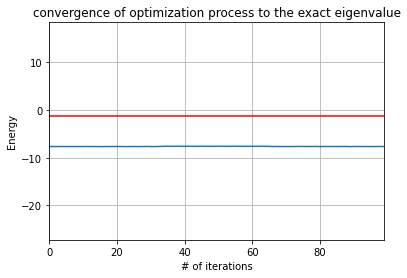

In [46]:
compare_exact_and_approximated_eigenvalue(transverse_ising_3_qubits, TI_approximated_eigenvalue)

##  Transverse Ising Model 2 qubits

In [47]:
QUBITS_NUM = 2 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
MAX_NUM_ITERATIONS = 50

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [48]:
transverse_ising_2_qubits = 0.13755727363376802 * (I^X) \
                            + 0.43305656297810435 * (X^I) \
                            + 0.8538597608997253 * (Z^Z)

In [49]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, "linear")

[0.23930008 5.69980119 0.67899471 3.06917573 5.06171483 4.65976514
 3.18632016 0.57628634 5.51996649 5.00500757 3.9015139  3.44683253
 1.5178231  0.8528778  5.21768837 1.25499076]
thetas:
[0.23930008 5.69980119 0.67899471 3.06917573 5.06171483 4.65976514
 3.18632016 0.57628634 5.51996649 5.00500757 3.9015139  3.44683253
 1.5178231  0.8528778  5.21768837 1.25499076]
0.9691929046881114
thetas:
[0.2393001  5.69980119 0.67899471 3.06917573 5.06171483 4.65976514
 3.18632016 0.57628634 5.51996649 5.00500757 3.9015139  3.44683253
 1.5178231  0.8528778  5.21768837 1.25499076]
0.9024851108678202
thetas:
[0.23930008 5.6998012  0.67899471 3.06917573 5.06171483 4.65976514
 3.18632016 0.57628634 5.51996649 5.00500757 3.9015139  3.44683253
 1.5178231  0.8528778  5.21768837 1.25499076]
0.9325036180869513
thetas:
[0.23930008 5.69980119 0.67899473 3.06917573 5.06171483 4.65976514
 3.18632016 0.57628634 5.51996649 5.00500757 3.9015139  3.44683253
 1.5178231  0.8528778  5.21768837 1.25499076]
0.929168228

0.9224974490139075
thetas:
[0.41183627 5.79469609 0.78251642 3.18995106 5.14366952 4.68995897
 3.29415529 0.58491315 5.65368203 5.16891694 4.04385625 3.55466764
 1.59546439 1.02972739 5.31258327 1.45772078]
0.8774696881852111
thetas:
[0.41183627 5.79469609 0.78251642 3.18995106 5.14366952 4.68995897
 3.29415527 0.58491317 5.65368203 5.16891694 4.04385625 3.55466764
 1.59546439 1.02972739 5.31258327 1.45772078]
0.930835923241444
thetas:
[0.41183627 5.79469609 0.78251642 3.18995106 5.14366952 4.68995897
 3.29415527 0.58491315 5.65368205 5.16891694 4.04385625 3.55466764
 1.59546439 1.02972739 5.31258327 1.45772078]
0.9208297541684003
thetas:
[0.41183627 5.79469609 0.78251642 3.18995106 5.14366952 4.68995897
 3.29415527 0.58491315 5.65368203 5.16891696 4.04385625 3.55466764
 1.59546439 1.02972739 5.31258327 1.45772078]
0.8874758572582548
thetas:
[0.41183627 5.79469609 0.78251642 3.18995106 5.14366952 4.68995897
 3.29415527 0.58491315 5.65368203 5.16891694 4.04385626 3.55466764
 1.59546439 

0.9258328387049222
thetas:
[0.2623574  5.71248271 0.6928291  3.08531585 5.07266706 4.66380017
 3.20073098 0.57743921 5.53783591 5.02691202 3.92053618 3.46124335
 1.52819891 0.87651155 5.23036989 1.28208311]
0.9291682283959367
thetas:
[0.2623574  5.71248271 0.6928291  3.08531585 5.07266706 4.66380017
 3.20073098 0.57743921 5.53783591 5.02691202 3.92053618 3.46124335
 1.5281989  0.87651156 5.23036989 1.28208311]
0.9725282943791258
thetas:
[0.2623574  5.71248271 0.6928291  3.08531585 5.07266706 4.66380017
 3.20073098 0.57743921 5.53783591 5.02691202 3.92053618 3.46124335
 1.5281989  0.87651155 5.23036991 1.28208311]
0.9041528057133276
thetas:
[0.2623574  5.71248271 0.6928291  3.08531585 5.07266706 4.66380017
 3.20073098 0.57743921 5.53783591 5.02691202 3.92053618 3.46124335
 1.5281989  0.87651155 5.23036989 1.28208313]
0.9258328387049222
thetas:
[0.2481961  5.704694   0.68433232 3.07540294 5.06594044 4.66132194
 3.19188017 0.57673114 5.5268609  5.01345878 3.90885311 3.45239254
 1.52182631

0.8908112469492693
thetas:
[0.24060604 5.70051948 0.67977828 3.0700899  5.06233516 4.65999368
 3.18713638 0.57635164 5.52097861 5.00624823 3.90259131 3.44764875
 1.51841078 0.8542164  5.21840664 1.25652526]
0.9224974490139075
thetas:
[0.24060604 5.70051946 0.6797783  3.0700899  5.06233516 4.65999368
 3.18713638 0.57635164 5.52097861 5.00624823 3.90259131 3.44764875
 1.51841078 0.8542164  5.21840664 1.25652526]
0.8974820263312984
thetas:
[0.24060604 5.70051946 0.67977828 3.07008992 5.06233516 4.65999368
 3.18713638 0.57635164 5.52097861 5.00624823 3.90259131 3.44764875
 1.51841078 0.8542164  5.21840664 1.25652526]
0.949180566542024
thetas:
[0.24060604 5.70051946 0.67977828 3.0700899  5.06233518 4.65999368
 3.18713638 0.57635164 5.52097861 5.00624823 3.90259131 3.44764875
 1.51841078 0.8542164  5.21840664 1.25652526]
0.9024851108678202
thetas:
[0.24060604 5.70051946 0.67977828 3.0700899  5.06233516 4.6599937
 3.18713638 0.57635164 5.52097861 5.00624823 3.90259131 3.44764875
 1.51841078 0

0.8858081624127475
thetas:
[0.23940634 5.69985963 0.67905847 3.06925011 5.06176531 4.65978373
 3.18638657 0.57629165 5.52004886 5.00510852 3.90160156 3.44689894
 1.51787092 0.85298672 5.21774681 1.25511562]
0.9275005335504294
thetas:
[0.23940634 5.69985963 0.67905847 3.06925011 5.06176531 4.65978373
 3.18638657 0.57629165 5.52004884 5.00510853 3.90160156 3.44689894
 1.51787092 0.85298672 5.21774681 1.25511562]
0.9241651438594148
thetas:
[0.23940634 5.69985963 0.67905847 3.06925011 5.06176531 4.65978373
 3.18638657 0.57629165 5.52004884 5.00510852 3.90160158 3.44689894
 1.51787092 0.85298672 5.21774681 1.25511562]
0.9358390077779658
thetas:
[0.23940634 5.69985963 0.67905847 3.06925011 5.06176531 4.65978373
 3.18638657 0.57629165 5.52004884 5.00510852 3.90160156 3.44689896
 1.51787092 0.85298672 5.21774681 1.25511562]
0.859125044884631
thetas:
[0.23940634 5.69985963 0.67905847 3.06925011 5.06176531 4.65978373
 3.18638657 0.57629165 5.52004884 5.00510852 3.90160156 3.44689894
 1.51787094 

0.9224974490139075
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171966 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769397 1.25500269]
0.9141589747863712
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171966 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.25500271]
0.9108235850953567
thetas:
[0.23931026 5.69980677 0.67900081 3.06918283 5.06171966 4.65976691
 3.18632651 0.57628684 5.51997435 5.00501721 3.90152226 3.44683888
 1.51782767 0.85288821 5.21769396 1.2550027 ]
0.9358390077779658
thetas:
[0.23931027 5.69980677 0.67900081 3.06918283 5.06171966 4.65976691
 3.18632651 0.57628684 5.51997435 5.00501721 3.90152226 3.44683888
 1.51782767 0.85288821 5.21769396 1.2550027 ]
0.900817416022313
thetas:
[0.23931026 5.69980678 0.67900081 3.06918283 5.06171966 4.65976691
 3.18632651 0.57628684 5.51997435 5.00501721 3.90152226 3.44683888
 1.51782767 

0.9158266696318784
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171967 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.25500269]
0.9024851108678202
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171966 4.65976693
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.25500269]
0.9358390077779658
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171966 4.65976692
 3.18632652 0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.25500269]
0.9158266696318784
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171966 4.65976692
 3.1863265  0.57628686 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.25500269]
0.9174943644773857
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171966 4.65976692
 3.1863265  0.57628685 5.51997438 5.00501721 3.90152227 3.44683888
 1.51782767

0.8908112469492693
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171966 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152229 3.44683888
 1.51782767 0.85288821 5.21769395 1.25500269]
0.8607927397301384
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171966 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683889
 1.51782767 0.85288821 5.21769395 1.25500269]
0.8991497211768058
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171966 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782769 0.85288821 5.21769395 1.25500269]
0.9425097871599949
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171966 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767 0.85288822 5.21769395 1.25500269]
0.930835923241444
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171966 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767 

0.9458451768510094
thetas:
[0.23931025 5.69980677 0.6790008  3.06918284 5.06171965 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.2550027 ]
0.9275005335504294
thetas:
[0.23931024 5.69980679 0.6790008  3.06918284 5.06171965 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.2550027 ]
0.9174943644773857
thetas:
[0.23931024 5.69980677 0.67900082 3.06918284 5.06171965 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.2550027 ]
0.900817416022313
thetas:
[0.23931024 5.69980677 0.6790008  3.06918285 5.06171965 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.2550027 ]
0.9208297541684003
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171967 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767 

0.9358390077779658
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171966 4.65976692
 3.1863265  0.57628685 5.51997438 5.00501721 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.25500269]
0.9441774820055022
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171966 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501723 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.25500269]
0.870798908803182
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171966 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152229 3.44683888
 1.51782767 0.85288821 5.21769395 1.25500269]
0.9708605995336186
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171966 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683889
 1.51782767 0.85288821 5.21769395 1.25500269]
0.9224974490139075
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171966 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782769 

0.9475128716965167
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171966 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769397 1.25500269]
0.9108235850953567
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171966 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.25500271]
0.9191620593228931
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171966 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.25500269]
0.9458451768510094
thetas:
[0.23931025 5.69980677 0.6790008  3.06918284 5.06171966 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.25500269]
0.8991497211768058
thetas:
[0.23931024 5.69980679 0.6790008  3.06918284 5.06171966 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767

0.9375067026234731
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171966 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.25500269]
0.9541836510785457
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171966 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.25500269]
0.8808050778762258
thetas:
[0.23931025 5.69980677 0.6790008  3.06918284 5.06171966 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.25500269]
0.8841404675672402
thetas:
[0.23931024 5.69980679 0.6790008  3.06918284 5.06171966 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.25500269]
0.9425097871599949
thetas:
[0.23931024 5.69980677 0.67900082 3.06918284 5.06171966 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767

0.9575190407695604
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171966 4.65976693
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.25500269]
0.8774696881852111
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171966 4.65976692
 3.18632652 0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.25500269]
0.9158266696318784
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171966 4.65976692
 3.1863265  0.57628686 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.25500269]
0.9108235850953567
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171966 4.65976692
 3.1863265  0.57628685 5.51997438 5.00501721 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.25500269]
0.9375067026234731
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171966 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501723 3.90152227 3.44683888
 1.51782767

0.9358390077779658
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171966 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782769 0.85288821 5.21769395 1.25500269]
0.9058205005588349
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171966 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767 0.85288822 5.21769395 1.25500269]
0.9458451768510094
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171966 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769397 1.25500269]
0.9108235850953567
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171966 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.25500271]
0.9108235850953567
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171966 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767

0.9024851108678202
thetas:
[0.23931026 5.69980677 0.6790008  3.06918284 5.06171965 4.65976692
 3.1863265  0.57628684 5.51997436 5.00501722 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.2550027 ]
0.9641898201515895
thetas:
[0.23931024 5.69980679 0.6790008  3.06918284 5.06171965 4.65976692
 3.1863265  0.57628684 5.51997436 5.00501722 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.2550027 ]
0.8908112469492693
thetas:
[0.23931024 5.69980677 0.67900082 3.06918284 5.06171965 4.65976692
 3.1863265  0.57628684 5.51997436 5.00501722 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.2550027 ]
0.8808050778762258
thetas:
[0.23931024 5.69980677 0.6790008  3.06918285 5.06171965 4.65976692
 3.1863265  0.57628684 5.51997436 5.00501722 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.2550027 ]
0.9141589747863712
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171967 4.65976692
 3.1863265  0.57628684 5.51997436 5.00501722 3.90152227 3.44683888
 1.51782767

0.8891435521037621
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171965 4.65976692
 3.1863265  0.57628685 5.51997438 5.00501721 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.25500269]
0.9541836510785457
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171965 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501723 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.25500269]
0.9258328387049222
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171965 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152229 3.44683888
 1.51782767 0.85288821 5.21769395 1.25500269]
0.9508482613875313
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171965 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683889
 1.51782767 0.85288821 5.21769395 1.25500269]
0.9341713129324585
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171965 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782769

0.870798908803182
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171965 4.65976692
 3.1863265  0.57628684 5.51997436 5.00501722 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.2550027 ]
0.9258328387049222
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171965 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.2550027 ]
0.8741342984941967
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171965 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.25500269]
0.9558513459240532
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171965 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.25500269]
0.9158266696318784
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171965 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767 

0.9041528057133276
thetas:
[0.23931025 5.69980677 0.6790008  3.06918283 5.06171964 4.65976692
 3.1863265  0.57628684 5.51997435 5.00501722 3.90152227 3.44683887
 1.51782767 0.85288821 5.21769396 1.25500272]
0.8841404675672402
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171965 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.2550027 ]
0.9541836510785457
thetas:
[0.23931025 5.69980677 0.6790008  3.06918284 5.06171965 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.2550027 ]
0.8908112469492693
thetas:
[0.23931024 5.69980679 0.6790008  3.06918284 5.06171965 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.2550027 ]
0.8941466366402839
thetas:
[0.23931024 5.69980677 0.67900082 3.06918284 5.06171965 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767

0.9191620593228931
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171965 4.65976692
 3.18632652 0.57628685 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.25500269]
0.9041528057133276
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171965 4.65976692
 3.1863265  0.57628686 5.51997436 5.00501721 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.25500269]
0.9625221253060823
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171965 4.65976692
 3.1863265  0.57628685 5.51997438 5.00501721 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.25500269]
0.900817416022313
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171965 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501723 3.90152227 3.44683888
 1.51782767 0.85288821 5.21769395 1.25500269]
0.9508482613875313
thetas:
[0.23931024 5.69980677 0.6790008  3.06918284 5.06171965 4.65976692
 3.1863265  0.57628685 5.51997436 5.00501721 3.90152229 3.44683888
 1.51782767 

[(1.0269745088446243+0j), (0.9035465241407012+0j), (-0.9035465241407018+0j), (-1.0269745088446245+0j)]
Exact Eigenvalue:
(-1.0269745088446245+0j)

Approximated Eigenvalue:
0.9241651438594148

Approximation Error
0.1001089745653698


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


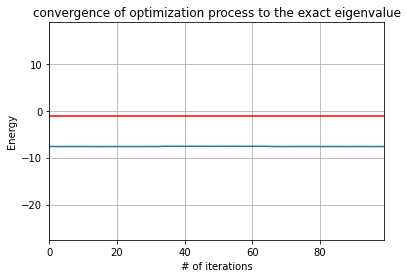

In [50]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

In [51]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, "full")

[0.08264956 3.72345263 4.70347029 5.58004279 0.24122329 4.06863164
 5.79812026 6.119727   5.9008322  2.35099983 0.77132605 5.80024503
 5.2168585  2.34022679 4.52289358 1.70136572]
thetas:
[0.08264956 3.72345263 4.70347029 5.58004279 0.24122329 4.06863164
 5.79812026 6.119727   5.9008322  2.35099983 0.77132605 5.80024503
 5.2168585  2.34022679 4.52289358 1.70136572]
0.8491188758115875
thetas:
[0.08264957 3.72345263 4.70347029 5.58004279 0.24122329 4.06863164
 5.79812026 6.119727   5.9008322  2.35099983 0.77132605 5.80024503
 5.2168585  2.34022679 4.52289358 1.70136572]
0.8974820263312984
thetas:
[0.08264956 3.72345264 4.70347029 5.58004279 0.24122329 4.06863164
 5.79812026 6.119727   5.9008322  2.35099983 0.77132605 5.80024503
 5.2168585  2.34022679 4.52289358 1.70136572]
0.9191620593228931
thetas:
[0.08264956 3.72345263 4.70347031 5.58004279 0.24122329 4.06863164
 5.79812026 6.119727   5.9008322  2.35099983 0.77132605 5.80024503
 5.2168585  2.34022679 4.52289358 1.70136572]
0.949180566

0.7974203356008619
thetas:
[-0.0171741   3.57888043  4.49693858  5.58348499  0.31350941  3.94127042
  5.7017388   6.04399871  5.88017903  2.24773398  0.63363824  5.72451673
  5.15834118  2.31957362  4.49191382  1.54990914]
0.8491188758115875
thetas:
[-0.0171741   3.57888043  4.49693858  5.58348499  0.31350939  3.94127044
  5.7017388   6.04399871  5.88017903  2.24773398  0.63363824  5.72451673
  5.15834118  2.31957362  4.49191382  1.54990914]
0.8174326737469492
thetas:
[-0.0171741   3.57888043  4.49693858  5.58348499  0.31350939  3.94127042
  5.70173881  6.04399871  5.88017903  2.24773398  0.63363824  5.72451673
  5.15834118  2.31957362  4.49191382  1.54990914]
0.8307742325110075
thetas:
[-0.0171741   3.57888043  4.49693858  5.58348499  0.31350939  3.94127042
  5.7017388   6.04399872  5.88017903  2.24773398  0.63363824  5.72451673
  5.15834118  2.31957362  4.49191382  1.54990914]
0.8307742325110075
thetas:
[-0.0171741   3.57888043  4.49693858  5.58348499  0.31350939  3.94127042
  5.7017

0.882472772721733
thetas:
[0.07526015 3.71275073 4.68818186 5.5802976  0.24657424 4.05920378
 5.79098566 6.11412124 5.89930336 2.34335562 0.76113377 5.79463927
 5.21252678 2.33869794 4.52060031 1.69015421]
0.8791373830307184
thetas:
[0.07526015 3.71275073 4.68818186 5.5802976  0.24657424 4.05920378
 5.79098566 6.11412124 5.89930336 2.34335562 0.76113376 5.79463928
 5.21252678 2.33869794 4.52060031 1.69015421]
0.8924789417947766
thetas:
[0.07526015 3.71275073 4.68818186 5.5802976  0.24657424 4.05920378
 5.79098566 6.11412124 5.89930336 2.34335562 0.76113376 5.79463927
 5.2125268  2.33869794 4.52060031 1.69015421]
0.8441157912750656
thetas:
[0.07526015 3.71275073 4.68818186 5.5802976  0.24657424 4.05920378
 5.79098566 6.11412124 5.89930336 2.34335562 0.76113376 5.79463927
 5.21252678 2.33869796 4.52060031 1.69015421]
0.8657958242666601
thetas:
[0.07526015 3.71275073 4.68818186 5.5802976  0.24657424 4.05920378
 5.79098566 6.11412124 5.89930336 2.34335562 0.76113376 5.79463927
 5.21252678 

0.882472772721733
thetas:
[0.08221072 3.72281709 4.70256236 5.58005792 0.24154107 4.06807175
 5.79769656 6.11939409 5.90074141 2.35054586 0.77072075 5.79991212
 5.21660125 2.34013599 4.52275739 1.7006999 ]
0.8474511809660802
thetas:
[0.08221072 3.72281707 4.70256237 5.58005792 0.24154107 4.06807175
 5.79769656 6.11939409 5.90074141 2.35054586 0.77072075 5.79991212
 5.21660125 2.34013599 4.52275739 1.7006999 ]
0.8991497211768058
thetas:
[0.08221072 3.72281707 4.70256236 5.58005794 0.24154107 4.06807175
 5.79769656 6.11939409 5.90074141 2.35054586 0.77072075 5.79991212
 5.21660125 2.34013599 4.52275739 1.7006999 ]
0.8874758572582548
thetas:
[0.08221072 3.72281707 4.70256236 5.58005792 0.24154109 4.06807175
 5.79769656 6.11939409 5.90074141 2.35054586 0.77072075 5.79991212
 5.21660125 2.34013599 4.52275739 1.7006999 ]
0.8691312139576748
thetas:
[0.08221072 3.72281707 4.70256236 5.58005792 0.24154107 4.06807176
 5.79769656 6.11939409 5.90074141 2.35054586 0.77072075 5.79991212
 5.21660125 

0.8958143314857911
thetas:
[0.08261657 3.72340486 4.70340205 5.58004393 0.24124718 4.06858956
 5.79808841 6.11970198 5.9008254  2.35096571 0.77128055 5.80022
 5.21683917 2.34021996 4.52288334 1.70131568]
0.8924789417947766
thetas:
[0.08261657 3.72340486 4.70340205 5.58004393 0.24124718 4.06858956
 5.79808841 6.11970198 5.90082538 2.35096572 0.77128055 5.80022
 5.21683917 2.34021996 4.52288334 1.70131568]
0.8908112469492693
thetas:
[0.08261657 3.72340486 4.70340205 5.58004393 0.24124718 4.06858956
 5.79808841 6.11970198 5.90082538 2.35096571 0.77128056 5.80022
 5.21683917 2.34021996 4.52288334 1.70131568]
0.8674635191121675
thetas:
[0.08261657 3.72340486 4.70340205 5.58004393 0.24124718 4.06858956
 5.79808841 6.11970198 5.90082538 2.35096571 0.77128055 5.80022002
 5.21683917 2.34021996 4.52288334 1.70131568]
0.8858081624127475
thetas:
[0.08261657 3.72340486 4.70340205 5.58004393 0.24124718 4.06858956
 5.79808841 6.11970198 5.90082538 2.35096571 0.77128055 5.80022
 5.21683918 2.34021996 

0.8391127067385438
thetas:
[0.08264829 3.72345079 4.70346767 5.58004283 0.24122421 4.06863002
 5.79811904 6.11972604 5.90083194 2.35099852 0.7713243  5.80024406
 5.21685776 2.34022652 4.52289319 1.7013638 ]
0.900817416022313
thetas:
[0.0826483  3.72345079 4.70346767 5.58004283 0.24122421 4.06863002
 5.79811904 6.11972604 5.90083194 2.35099852 0.7713243  5.80024406
 5.21685776 2.34022652 4.52289319 1.7013638 ]
0.8774696881852111
thetas:
[0.08264829 3.72345081 4.70346767 5.58004283 0.24122421 4.06863002
 5.79811904 6.11972604 5.90083194 2.35099852 0.7713243  5.80024406
 5.21685776 2.34022652 4.52289319 1.7013638 ]
0.9208297541684003
thetas:
[0.08264829 3.72345079 4.70346768 5.58004283 0.24122421 4.06863002
 5.79811904 6.11972604 5.90083194 2.35099852 0.7713243  5.80024406
 5.21685776 2.34022652 4.52289319 1.7013638 ]
0.8741342984941967
thetas:
[0.08264829 3.72345079 4.70346767 5.58004285 0.24122421 4.06863002
 5.79811904 6.11972604 5.90083194 2.35099852 0.7713243  5.80024406
 5.21685776 

0.870798908803182
thetas:
[0.08264939 3.72345238 4.70346994 5.5800428  0.24122342 4.06863143
 5.79812011 6.11972687 5.90083217 2.35099966 0.77132581 5.8002449
 5.2168584  2.34022675 4.52289353 1.70136547]
0.8841404675672402
thetas:
[0.08264939 3.72345238 4.70346994 5.5800428  0.24122342 4.06863143
 5.7981201  6.11972689 5.90083217 2.35099966 0.77132581 5.8002449
 5.2168584  2.34022675 4.52289353 1.70136547]
0.8241034531289784
thetas:
[0.08264939 3.72345238 4.70346994 5.5800428  0.24122342 4.06863143
 5.7981201  6.11972687 5.90083218 2.35099966 0.77132581 5.8002449
 5.2168584  2.34022675 4.52289353 1.70136547]
0.8908112469492693
thetas:
[0.08264939 3.72345238 4.70346994 5.5800428  0.24122342 4.06863143
 5.7981201  6.11972687 5.90083217 2.35099967 0.77132581 5.8002449
 5.2168584  2.34022675 4.52289353 1.70136547]
0.8924789417947766
thetas:
[0.08264939 3.72345238 4.70346994 5.5800428  0.24122342 4.06863143
 5.7981201  6.11972687 5.90083217 2.35099966 0.77132583 5.8002449
 5.2168584  2.340

0.8991497211768058
thetas:
[0.08264954 3.7234526  4.70347025 5.58004279 0.24122331 4.06863162
 5.79812024 6.11972699 5.9008322  2.35099981 0.77132602 5.80024501
 5.21685851 2.34022678 4.52289357 1.70136569]
0.8741342984941967
thetas:
[0.08264954 3.7234526  4.70347025 5.58004279 0.24122331 4.06863162
 5.79812024 6.11972699 5.9008322  2.35099981 0.77132602 5.80024501
 5.21685849 2.3402268  4.52289357 1.70136569]
0.9174943644773857
thetas:
[0.08264954 3.7234526  4.70347025 5.58004279 0.24122331 4.06863162
 5.79812024 6.11972699 5.9008322  2.35099981 0.77132602 5.80024501
 5.21685849 2.34022678 4.52289359 1.70136569]
0.8624604345756457
thetas:
[0.08264954 3.7234526  4.70347025 5.58004279 0.24122331 4.06863162
 5.79812024 6.11972699 5.9008322  2.35099981 0.77132602 5.80024501
 5.21685849 2.34022678 4.52289357 1.70136571]
0.8874758572582548
thetas:
[0.08264955 3.72345262 4.70347028 5.58004279 0.2412233  4.06863164
 5.79812026 6.119727   5.9008322  2.35099983 0.77132604 5.80024502
 5.2168585 

0.900817416022313
thetas:
[0.08264956 3.72345264 4.70347029 5.58004279 0.24122329 4.06863164
 5.79812026 6.119727   5.9008322  2.35099983 0.77132604 5.80024503
 5.2168585  2.34022679 4.52289358 1.70136572]
0.930835923241444
thetas:
[0.08264956 3.72345263 4.70347031 5.58004279 0.24122329 4.06863164
 5.79812026 6.119727   5.9008322  2.35099983 0.77132604 5.80024503
 5.2168585  2.34022679 4.52289358 1.70136572]
0.8791373830307184
thetas:
[0.08264956 3.72345263 4.70347029 5.58004281 0.24122329 4.06863164
 5.79812026 6.119727   5.9008322  2.35099983 0.77132604 5.80024503
 5.2168585  2.34022679 4.52289358 1.70136572]
0.8474511809660802
thetas:
[0.08264956 3.72345263 4.70347029 5.58004279 0.24122331 4.06863164
 5.79812026 6.119727   5.9008322  2.35099983 0.77132604 5.80024503
 5.2168585  2.34022679 4.52289358 1.70136572]
0.900817416022313
thetas:
[0.08264956 3.72345263 4.70347029 5.58004279 0.24122329 4.06863166
 5.79812026 6.119727   5.9008322  2.35099983 0.77132604 5.80024503
 5.2168585  2.

0.8974820263312984
thetas:
[0.08264956 3.72345263 4.70347029 5.58004279 0.24122329 4.06863164
 5.79812026 6.119727   5.90083222 2.35099983 0.77132605 5.80024503
 5.2168585  2.34022679 4.52289358 1.70136572]
0.9141589747863712
thetas:
[0.08264956 3.72345263 4.70347029 5.58004279 0.24122329 4.06863164
 5.79812026 6.119727   5.9008322  2.35099985 0.77132605 5.80024503
 5.2168585  2.34022679 4.52289358 1.70136572]
0.8774696881852111
thetas:
[0.08264956 3.72345263 4.70347029 5.58004279 0.24122329 4.06863164
 5.79812026 6.119727   5.9008322  2.35099983 0.77132606 5.80024503
 5.2168585  2.34022679 4.52289358 1.70136572]
0.8758019933397039
thetas:
[0.08264956 3.72345263 4.70347029 5.58004279 0.24122329 4.06863164
 5.79812026 6.119727   5.9008322  2.35099983 0.77132605 5.80024504
 5.2168585  2.34022679 4.52289358 1.70136572]
0.8657958242666601
thetas:
[0.08264956 3.72345263 4.70347029 5.58004279 0.24122329 4.06863164
 5.79812026 6.119727   5.9008322  2.35099983 0.77132605 5.80024503
 5.21685852

0.8874758572582548
thetas:
[0.08264956 3.72345263 4.70347029 5.58004279 0.24122329 4.06863164
 5.79812026 6.119727   5.9008322  2.35099983 0.77132604 5.80024503
 5.2168585  2.34022679 4.52289359 1.70136572]
0.8874758572582548
thetas:
[0.08264956 3.72345263 4.70347029 5.58004279 0.24122329 4.06863164
 5.79812026 6.119727   5.9008322  2.35099983 0.77132604 5.80024503
 5.2168585  2.34022679 4.52289358 1.70136574]
0.8457834861205729
thetas:
[0.08264956 3.72345263 4.70347029 5.58004279 0.24122329 4.06863164
 5.79812026 6.119727   5.9008322  2.35099983 0.77132605 5.80024503
 5.2168585  2.34022679 4.52289358 1.70136572]
0.9258328387049222
thetas:
[0.08264957 3.72345263 4.70347029 5.58004279 0.24122329 4.06863164
 5.79812026 6.119727   5.9008322  2.35099983 0.77132605 5.80024503
 5.2168585  2.34022679 4.52289358 1.70136572]
0.8841404675672402
thetas:
[0.08264956 3.72345264 4.70347029 5.58004279 0.24122329 4.06863164
 5.79812026 6.119727   5.9008322  2.35099983 0.77132605 5.80024503
 5.2168585 

0.8174326737469492
thetas:
[0.08264956 3.72345263 4.70347029 5.58004281 0.24122329 4.06863164
 5.79812026 6.119727   5.9008322  2.35099983 0.77132605 5.80024503
 5.2168585  2.34022679 4.52289358 1.70136572]
0.9058205005588349
thetas:
[0.08264956 3.72345263 4.70347029 5.58004279 0.24122331 4.06863164
 5.79812026 6.119727   5.9008322  2.35099983 0.77132605 5.80024503
 5.2168585  2.34022679 4.52289358 1.70136572]
0.9191620593228931
thetas:
[0.08264956 3.72345263 4.70347029 5.58004279 0.24122329 4.06863166
 5.79812026 6.119727   5.9008322  2.35099983 0.77132605 5.80024503
 5.2168585  2.34022679 4.52289358 1.70136572]
0.8374450118930366
thetas:
[0.08264956 3.72345263 4.70347029 5.58004279 0.24122329 4.06863164
 5.79812028 6.119727   5.9008322  2.35099983 0.77132605 5.80024503
 5.2168585  2.34022679 4.52289358 1.70136572]
0.8758019933397039
thetas:
[0.08264956 3.72345263 4.70347029 5.58004279 0.24122329 4.06863164
 5.79812026 6.11972702 5.9008322  2.35099983 0.77132605 5.80024503
 5.2168585 

[(1.0269745088446243+0j), (0.9035465241407012+0j), (-0.9035465241407018+0j), (-1.0269745088446245+0j)]
Exact Eigenvalue:
(-1.0269745088446245+0j)

Approximated Eigenvalue:
0.8941466366402839

Approximation Error
0.1293390157792482


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


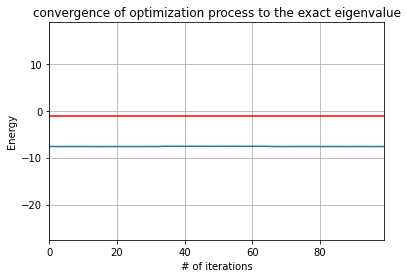

In [52]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

## H2 Molecule 2 qubits

In [53]:
from qiskit.opflow import X, Z, I

H2_molecule_Hamiltonian_2_qubits = -0.5053051899926562*(I^I) + \
                            -0.3277380754984016*(Z^I) + \
                            0.15567463610622564*(Z^Z) + \
                            -0.3277380754984016*(I^Z)

In [54]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, "linear")

[5.41963366 0.84423274 4.9410005  2.71455218 2.79127126 5.93707684
 4.79829062 3.93255605 3.70452304 3.17597131 0.90724919 4.84415919
 5.33417557 0.46947544 2.61019936 1.15156105]
thetas:
[5.41963366 0.84423274 4.9410005  2.71455218 2.79127126 5.93707684
 4.79829062 3.93255605 3.70452304 3.17597131 0.90724919 4.84415919
 5.33417557 0.46947544 2.61019936 1.15156105]
-0.6372004172885849
thetas:
[5.41963367 0.84423274 4.9410005  2.71455218 2.79127126 5.93707684
 4.79829062 3.93255605 3.70452304 3.17597131 0.90724919 4.84415919
 5.33417557 0.46947544 2.61019936 1.15156105]
-0.6500026858627411
thetas:
[5.41963366 0.84423276 4.9410005  2.71455218 2.79127126 5.93707684
 4.79829062 3.93255605 3.70452304 3.17597131 0.90724919 4.84415919
 5.33417557 0.46947544 2.61019936 1.15156105]
-0.6341278876707173
thetas:
[5.41963366 0.84423274 4.94100051 2.71455218 2.79127126 5.93707684
 4.79829062 3.93255605 3.70452304 3.17597131 0.90724919 4.84415919
 5.33417557 0.46947544 2.61019936 1.15156105]
-0.65646

-0.6534594764569224
thetas:
[5.46315544 0.83378756 5.0065008  2.74996798 2.8458366  5.97499517
 4.90149162 3.95681948 3.7607749  3.23069999 0.95251179 4.96433363
 5.37318208 0.58110889 2.65393878 1.15776286]
-0.6648374388574578
thetas:
[5.46315544 0.83378756 5.0065008  2.74996798 2.84583659 5.97499518
 4.90149162 3.95681948 3.7607749  3.23069999 0.95251179 4.96433363
 5.37318208 0.58110889 2.65393878 1.15776286]
-0.6468823276718708
thetas:
[5.46315544 0.83378756 5.0065008  2.74996798 2.84583659 5.97499517
 4.90149164 3.95681948 3.7607749  3.23069999 0.95251179 4.96433363
 5.37318208 0.58110889 2.65393878 1.15776286]
-0.6486746304323228
thetas:
[5.46315544 0.83378756 5.0065008  2.74996798 2.84583659 5.97499517
 4.90149162 3.95681949 3.7607749  3.23069999 0.95251179 4.96433363
 5.37318208 0.58110889 2.65393878 1.15776286]
-0.6572041288849158
thetas:
[5.46315544 0.83378756 5.0065008  2.74996798 2.84583659 5.97499517
 4.90149162 3.95681948 3.76077491 3.23069999 0.95251179 4.96433363
 5.373

-0.6407371200368364
thetas:
[5.42675428 0.8425238  4.95171703 2.72034658 2.80019872 5.94328067
 4.81517539 3.9365258  3.71372643 3.1849255  0.91465462 4.863821
 5.34055745 0.48773984 2.61735559 1.15257573]
-0.6378885818892442
thetas:
[5.42675428 0.8425238  4.95171703 2.72034658 2.80019872 5.94328067
 4.81517539 3.9365258  3.71372643 3.1849255  0.91465462 4.86382098
 5.34055746 0.48773984 2.61735559 1.15257573]
-0.6748551138472082
thetas:
[5.42675428 0.8425238  4.95171703 2.72034658 2.80019872 5.94328067
 4.81517539 3.9365258  3.71372643 3.1849255  0.91465462 4.86382098
 5.34055745 0.48773986 2.61735559 1.15257573]
-0.6650773979186175
thetas:
[5.42675428 0.8425238  4.95171703 2.72034658 2.80019872 5.94328067
 4.81517539 3.9365258  3.71372643 3.1849255  0.91465462 4.86382098
 5.34055745 0.48773984 2.6173556  1.15257573]
-0.6446737545536873
thetas:
[5.42675428 0.8425238  4.95171703 2.72034658 2.80019872 5.94328067
 4.81517539 3.9365258  3.71372643 3.1849255  0.91465462 4.86382098
 5.34055

-0.6404170262226575
thetas:
[5.41999421 0.84414621 4.94154311 2.71484557 2.79172329 5.93739096
 4.79914555 3.93275705 3.70498903 3.17642469 0.90762415 4.84515473
 5.33449871 0.47040023 2.6105617  1.15161243]
-0.6678778106946084
thetas:
[5.4199942  0.84414623 4.94154311 2.71484557 2.79172329 5.93739096
 4.79914555 3.93275705 3.70498903 3.17642469 0.90762415 4.84515473
 5.33449871 0.47040023 2.6105617  1.15161243]
-0.6501947421512484
thetas:
[5.4199942  0.84414621 4.94154312 2.71484557 2.79172329 5.93739096
 4.79914555 3.93275705 3.70498903 3.17642469 0.90762415 4.84515473
 5.33449871 0.47040023 2.6105617  1.15161243]
-0.6272306450714868
thetas:
[5.4199942  0.84414621 4.94154311 2.71484559 2.79172329 5.93739096
 4.79914555 3.93275705 3.70498903 3.17642469 0.90762415 4.84515473
 5.33449871 0.47040023 2.6105617  1.15161243]
-0.6553476589623288
thetas:
[5.4199942  0.84414621 4.94154311 2.71484557 2.7917233  5.93739096
 4.79914555 3.93275705 3.70498903 3.17642469 0.90762415 4.84515473
 5.334

-0.6499706764813233
thetas:
[5.41967585 0.84422262 4.94106399 2.71458652 2.79132416 5.9371136
 4.79839068 3.93257957 3.70457757 3.17602436 0.90729307 4.84427568
 5.33421339 0.46958366 2.61024176 1.15156706]
-0.6446737545536873
thetas:
[5.41967585 0.84422262 4.94106399 2.71458652 2.79132416 5.9371136
 4.79839067 3.93257958 3.70457757 3.17602436 0.90729307 4.84427568
 5.33421339 0.46958366 2.61024176 1.15156706]
-0.6663255411949656
thetas:
[5.41967585 0.84422262 4.94106399 2.71458652 2.79132416 5.9371136
 4.79839067 3.93257957 3.70457758 3.17602436 0.90729307 4.84427568
 5.33421339 0.46958366 2.61024176 1.15156706]
-0.6415851831452859
thetas:
[5.41967585 0.84422262 4.94106399 2.71458652 2.79132416 5.9371136
 4.79839067 3.93257957 3.70457757 3.17602438 0.90729307 4.84427568
 5.33421339 0.46958366 2.61024176 1.15156706]
-0.6799760212768706
thetas:
[5.41967585 0.84422262 4.94106399 2.71458652 2.79132416 5.9371136
 4.79839067 3.93257957 3.70457757 3.17602436 0.90729308 4.84427568
 5.33421339

-0.6651253748909194
thetas:
[5.41963593 0.8442322  4.94100391 2.71455403 2.7912741  5.93707881
 4.798296   3.93255731 3.70452597 3.17597416 0.90725155 4.84416545
 5.33417761 0.46948126 2.61020166 1.15156137]
-0.6421453102202738
thetas:
[5.41963593 0.8442322  4.94100391 2.71455403 2.7912741  5.93707881
 4.798296   3.93255731 3.70452597 3.17597416 0.90725155 4.84416545
 5.33417761 0.46948126 2.61020164 1.15156139]
-0.6412651635307569
thetas:
[5.41963593 0.8442322  4.94100391 2.71455403 2.79127411 5.93707881
 4.798296   3.93255731 3.70452597 3.17597416 0.90725155 4.84416545
 5.33417761 0.46948126 2.61020164 1.15156137]
-0.6437295891013345
thetas:
[5.41963594 0.8442322  4.94100391 2.71455403 2.79127411 5.93707881
 4.798296   3.93255731 3.70452597 3.17597416 0.90725155 4.84416545
 5.33417761 0.46948126 2.61020164 1.15156137]
-0.6617648350399407
thetas:
[5.41963593 0.84423221 4.94100391 2.71455403 2.79127411 5.93707881
 4.798296   3.93255731 3.70452597 3.17597416 0.90725155 4.84416545
 5.334

-0.644737773316523
thetas:
[5.41963593 0.8442322  4.94100391 2.71455403 2.79127412 5.93707881
 4.798296   3.93255731 3.70452597 3.17597416 0.90725155 4.84416545
 5.33417761 0.46948126 2.61020164 1.15156137]
-0.6488184871495791
thetas:
[5.41963593 0.8442322  4.94100391 2.71455403 2.7912741  5.93707883
 4.798296   3.93255731 3.70452597 3.17597416 0.90725155 4.84416545
 5.33417761 0.46948126 2.61020164 1.15156137]
-0.6666776443905623
thetas:
[5.41963593 0.8442322  4.94100391 2.71455403 2.7912741  5.93707881
 4.79829602 3.93255731 3.70452597 3.17597416 0.90725155 4.84416545
 5.33417761 0.46948126 2.61020164 1.15156137]
-0.6463540615790015
thetas:
[5.41963593 0.8442322  4.94100391 2.71455403 2.7912741  5.93707881
 4.798296   3.93255733 3.70452597 3.17597416 0.90725155 4.84416545
 5.33417761 0.46948126 2.61020164 1.15156137]
-0.6487704359776275
thetas:
[5.41963593 0.8442322  4.94100391 2.71455403 2.7912741  5.93707881
 4.798296   3.93255731 3.70452598 3.17597416 0.90725155 4.84416545
 5.3341

-0.6424653298348029
thetas:
[5.41963593 0.8442322  4.94100391 2.71455403 2.7912741  5.93707881
 4.798296   3.93255731 3.70452597 3.17597416 0.90725155 4.84416546
 5.33417761 0.46948126 2.61020164 1.15156137]
-0.6713344528894905
thetas:
[5.41963593 0.8442322  4.94100391 2.71455403 2.7912741  5.93707881
 4.798296   3.93255731 3.70452597 3.17597416 0.90725155 4.84416545
 5.33417762 0.46948126 2.61020164 1.15156137]
-0.6383366390294448
thetas:
[5.41963593 0.8442322  4.94100391 2.71455403 2.7912741  5.93707881
 4.798296   3.93255731 3.70452597 3.17597416 0.90725155 4.84416545
 5.33417761 0.46948128 2.61020164 1.15156137]
-0.6281748105238397
thetas:
[5.41963593 0.8442322  4.94100391 2.71455403 2.7912741  5.93707881
 4.798296   3.93255731 3.70452597 3.17597416 0.90725155 4.84416545
 5.33417761 0.46948126 2.61020165 1.15156137]
-0.6416492019081217
thetas:
[5.41963593 0.8442322  4.94100391 2.71455403 2.7912741  5.93707881
 4.798296   3.93255731 3.70452597 3.17597416 0.90725155 4.84416545
 5.334

-0.6451538210753057
thetas:
[5.41963594 0.8442322  4.94100391 2.71455403 2.7912741  5.93707881
 4.798296   3.93255731 3.70452597 3.17597416 0.90725155 4.84416545
 5.33417761 0.46948126 2.61020164 1.15156137]
-0.6438735942178901
thetas:
[5.41963593 0.84423221 4.94100391 2.71455403 2.7912741  5.93707881
 4.798296   3.93255731 3.70452597 3.17597416 0.90725155 4.84416545
 5.33417761 0.46948126 2.61020164 1.15156137]
-0.6349760249788164
thetas:
[5.41963593 0.8442322  4.94100393 2.71455403 2.7912741  5.93707881
 4.798296   3.93255731 3.70452597 3.17597416 0.90725155 4.84416545
 5.33417761 0.46948126 2.61020164 1.15156137]
-0.6484824257445162
thetas:
[5.41963593 0.8442322  4.94100391 2.71455404 2.7912741  5.93707881
 4.798296   3.93255731 3.70452597 3.17597416 0.90725155 4.84416545
 5.33417761 0.46948126 2.61020164 1.15156137]
-0.6600364768426749
thetas:
[5.41963593 0.8442322  4.94100391 2.71455403 2.79127412 5.93707881
 4.798296   3.93255731 3.70452597 3.17597416 0.90725155 4.84416545
 5.334

-0.6581321041474354
thetas:
[5.41963593 0.8442322  4.94100391 2.71455403 2.7912741  5.93707881
 4.798296   3.93255731 3.70452597 3.17597416 0.90725155 4.84416545
 5.33417761 0.46948126 2.61020164 1.15156137]
-0.6603725382477377
thetas:
[5.41963593 0.8442322  4.94100391 2.71455403 2.7912741  5.93707881
 4.798296   3.93255731 3.70452597 3.17597416 0.90725155 4.84416545
 5.33417761 0.46948126 2.61020164 1.15156137]
-0.6278707585001947
thetas:
[5.41963593 0.8442322  4.94100391 2.71455403 2.7912741  5.93707881
 4.798296   3.93255731 3.70452597 3.17597416 0.90725155 4.84416545
 5.33417761 0.46948126 2.61020164 1.15156137]
-0.6716385049131354
thetas:
[5.41963594 0.8442322  4.94100391 2.71455403 2.7912741  5.93707881
 4.798296   3.93255731 3.70452597 3.17597416 0.90725155 4.84416545
 5.33417761 0.46948126 2.61020164 1.15156137]
-0.61746897093343
thetas:
[5.41963593 0.84423221 4.94100391 2.71455403 2.7912741  5.93707881
 4.798296   3.93255731 3.70452597 3.17597416 0.90725155 4.84416545
 5.33417

-0.6521470918187897
thetas:
[5.41963593 0.8442322  4.94100391 2.71455403 2.79127412 5.93707881
 4.798296   3.93255731 3.70452597 3.17597416 0.90725155 4.84416545
 5.33417761 0.46948126 2.61020164 1.15156137]
-0.6601645143683462
thetas:
[5.41963593 0.8442322  4.94100391 2.71455403 2.7912741  5.93707883
 4.798296   3.93255731 3.70452597 3.17597416 0.90725155 4.84416545
 5.33417761 0.46948126 2.61020164 1.15156137]
-0.6278707585001947
thetas:
[5.41963593 0.8442322  4.94100391 2.71455403 2.7912741  5.93707881
 4.79829602 3.93255731 3.70452597 3.17597416 0.90725155 4.84416545
 5.33417761 0.46948126 2.61020164 1.15156137]
-0.6520350218840023
thetas:
[5.41963593 0.8442322  4.94100391 2.71455403 2.7912741  5.93707881
 4.798296   3.93255733 3.70452597 3.17597416 0.90725155 4.84416545
 5.33417761 0.46948126 2.61020164 1.15156137]
-0.6320795098589224
thetas:
[5.41963593 0.8442322  4.94100391 2.71455403 2.7912741  5.93707881
 4.798296   3.93255731 3.70452598 3.17597416 0.90725155 4.84416545
 5.334

-0.6434415046685736
thetas:
[5.41963593 0.8442322  4.94100391 2.71455403 2.7912741  5.93707881
 4.798296   3.93255731 3.70452597 3.17597416 0.90725155 4.84416546
 5.33417761 0.46948126 2.61020164 1.15156137]
-0.6519870449117003
thetas:
[5.41963593 0.8442322  4.94100391 2.71455403 2.7912741  5.93707881
 4.798296   3.93255731 3.70452597 3.17597416 0.90725155 4.84416545
 5.33417762 0.46948126 2.61020164 1.15156137]
-0.6517629792417752
thetas:
[5.41963593 0.8442322  4.94100391 2.71455403 2.7912741  5.93707881
 4.798296   3.93255731 3.70452597 3.17597416 0.90725155 4.84416545
 5.33417761 0.46948128 2.61020164 1.15156137]
-0.6799919888677548
thetas:
[5.41963593 0.8442322  4.94100391 2.71455403 2.7912741  5.93707881
 4.798296   3.93255731 3.70452597 3.17597416 0.90725155 4.84416545
 5.33417761 0.46948126 2.61020166 1.15156137]
-0.6400969324084789
thetas:
[5.41963593 0.8442322  4.94100391 2.71455403 2.7912741  5.93707881
 4.798296   3.93255731 3.70452597 3.17597416 0.90725155 4.84416545
 5.334

[(0.30584559711037274+0j), (-0.6609798260988818+0j), (-0.6609798260988818+0j), (-1.0051067048832336+0j)]
Exact Eigenvalue:
(-1.0051067048832336+0j)

Approximated Eigenvalue:
-0.6481783737208713

Approximation Error
0.3551148643504749


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


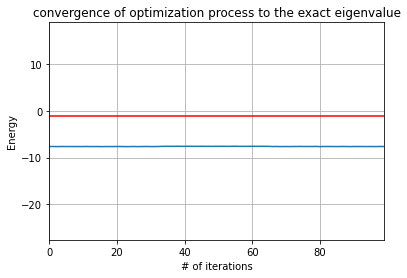

In [55]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)

In [56]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, "full")

[3.1005895  0.71602739 1.05674008 3.00335602 0.35135268 0.94292854
 3.46908312 5.32161484 4.71290599 1.16224939 6.23951814 3.58661182
 4.82444599 3.58004781 0.29949012 4.60694844]
thetas:
[3.1005895  0.71602739 1.05674008 3.00335602 0.35135268 0.94292854
 3.46908312 5.32161484 4.71290599 1.16224939 6.23951814 3.58661182
 4.82444599 3.58004781 0.29949012 4.60694844]
-0.5318221058108525
thetas:
[3.10058952 0.71602739 1.05674008 3.00335602 0.35135268 0.94292854
 3.46908312 5.32161484 4.71290599 1.16224939 6.23951814 3.58661182
 4.82444599 3.58004781 0.29949012 4.60694844]
-0.5340945492925726
thetas:
[3.1005895  0.7160274  1.05674008 3.00335602 0.35135268 0.94292854
 3.46908312 5.32161484 4.71290599 1.16224939 6.23951814 3.58661182
 4.82444599 3.58004781 0.29949012 4.60694844]
-0.5451045151062769
thetas:
[3.1005895  0.71602739 1.0567401  3.00335602 0.35135268 0.94292854
 3.46908312 5.32161484 4.71290599 1.16224939 6.23951814 3.58661182
 4.82444599 3.58004781 0.29949012 4.60694844]
-0.52543

-0.5939292985853436
thetas:
[3.10896843 0.76500216 1.03319703 2.96423536 0.31748371 0.98464549
 3.37886352 5.30745352 4.94485655 1.09516043 6.35215942 3.55085445
 4.80951765 3.65238845 0.37761343 4.74053678]
-0.6139327875827257
thetas:
[3.10896843 0.76500216 1.03319703 2.96423536 0.31748371 0.98464547
 3.37886353 5.30745352 4.94485655 1.09516043 6.35215942 3.55085445
 4.80951765 3.65238845 0.37761343 4.74053678]
-0.5975779228690834
thetas:
[3.10896843 0.76500216 1.03319703 2.96423536 0.31748371 0.98464547
 3.37886352 5.30745353 4.94485655 1.09516043 6.35215942 3.55085445
 4.80951765 3.65238845 0.37761343 4.74053678]
-0.620782053209654
thetas:
[3.10896843 0.76500216 1.03319703 2.96423536 0.31748371 0.98464547
 3.37886352 5.30745352 4.94485656 1.09516043 6.35215942 3.55085445
 4.80951765 3.65238845 0.37761343 4.74053678]
-0.6089719270601525
thetas:
[3.10896843 0.76500216 1.03319703 2.96423536 0.31748371 0.98464547
 3.37886352 5.30745352 4.94485655 1.09516045 6.35215942 3.55085445
 4.8095

-0.580902815941963
thetas:
[3.10170071 0.7225224  1.05361781 2.99816786 0.34686099 0.94846102
 3.45711824 5.31973677 4.74366718 1.15335208 6.25445658 3.58186969
 4.82246622 3.5896416  0.3098508  4.62466487]
-0.5258850704545087
thetas:
[3.10170071 0.7225224  1.05361781 2.99816786 0.34686099 0.94846102
 3.45711824 5.31973677 4.74366718 1.15335208 6.25445658 3.58186969
 4.8224662  3.58964161 0.3098508  4.62466487]
-0.5326222661466498
thetas:
[3.10170071 0.7225224  1.05361781 2.99816786 0.34686099 0.94846102
 3.45711824 5.31973677 4.74366718 1.15335208 6.25445658 3.58186969
 4.8224662  3.5896416  0.30985082 4.62466487]
-0.571589124744457
thetas:
[3.10170071 0.7225224  1.05361781 2.99816786 0.34686099 0.94846102
 3.45711824 5.31973677 4.74366718 1.15335208 6.25445658 3.58186969
 4.8224662  3.5896416  0.3098508  4.62466489]
-0.5448804494363518
thetas:
[3.10087658 0.71770535 1.05593345 3.00201568 0.35019227 0.94435784
 3.46599204 5.32112965 4.72085304 1.1599508  6.24337743 3.58538671
 4.82393

-0.5508175589923453
thetas:
[3.10062281 0.7162221  1.05664649 3.0032005  0.35121804 0.94309438
 3.46872446 5.32155854 4.7138281  1.16198268 6.23996594 3.58646967
 4.82438665 3.5803354  0.2998007  4.60747952]
-0.5336784273341403
thetas:
[3.10062281 0.71622208 1.0566465  3.0032005  0.35121804 0.94309438
 3.46872446 5.32155854 4.7138281  1.16198268 6.23996594 3.58646967
 4.82438665 3.5803354  0.2998007  4.60747952]
-0.5593949602175907
thetas:
[3.10062281 0.71622208 1.05664649 3.00320052 0.35121804 0.94309438
 3.46872446 5.32155854 4.7138281  1.16198268 6.23996594 3.58646967
 4.82438665 3.5803354  0.2998007  4.60747952]
-0.5212601971373488
thetas:
[3.10062281 0.71622208 1.05664649 3.0032005  0.35121805 0.94309438
 3.46872446 5.32155854 4.7138281  1.16198268 6.23996594 3.58646967
 4.82438665 3.5803354  0.2998007  4.60747952]
-0.5379191138746361
thetas:
[3.10062281 0.71622208 1.05664649 3.0032005  0.35121804 0.9430944
 3.46872446 5.32155854 4.7138281  1.16198268 6.23996594 3.58646967
 4.8243

-0.5379351556651699
thetas:
[3.10059369 0.71605187 1.05672831 3.00333647 0.35133575 0.94294939
 3.46903803 5.32160776 4.71302195 1.16221585 6.23957444 3.58659395
 4.82443853 3.58008397 0.29952917 4.60701522]
-0.533038388105082
thetas:
[3.10059369 0.71605187 1.05672831 3.00333647 0.35133575 0.94294939
 3.46903803 5.32160776 4.71302194 1.16221587 6.23957444 3.58659395
 4.82443853 3.58008397 0.29952917 4.60701522]
-0.5332143284034059
thetas:
[3.10059369 0.71605187 1.05672831 3.00333647 0.35133575 0.94294939
 3.46903803 5.32160776 4.71302194 1.16221585 6.23957446 3.58659395
 4.82443853 3.58008397 0.29952917 4.60701522]
-0.5391353961688656
thetas:
[3.10059369 0.71605187 1.05672831 3.00333647 0.35133575 0.94294939
 3.46903803 5.32160776 4.71302194 1.16221585 6.23957444 3.58659396
 4.82443853 3.58008397 0.29952917 4.60701522]
-0.556306463008839
thetas:
[3.10059369 0.71605187 1.05672831 3.00333647 0.35133575 0.94294939
 3.46903803 5.32160776 4.71302194 1.16221585 6.23957444 3.58659395
 4.82443

-0.546080615740398
thetas:
[3.10058995 0.71603001 1.05673882 3.00335393 0.35135087 0.94293077
 3.46907829 5.32161408 4.71291842 1.1622458  6.23952417 3.5866099
 4.82444519 3.58005169 0.29949432 4.6069556 ]
-0.5699888782725122
thetas:
[3.10058995 0.71603001 1.05673882 3.00335393 0.35135087 0.94293077
 3.46907829 5.32161408 4.71291842 1.1622458  6.23952417 3.5866099
 4.82444519 3.58005169 0.29949431 4.60695562]
-0.5454405023116902
thetas:
[3.10058964 0.7160282  1.05673969 3.00335538 0.35135212 0.94292923
 3.46908163 5.3216146  4.71290984 1.16224828 6.23952001 3.58661123
 4.82444575 3.58004901 0.29949142 4.60695066]
-0.5642918019773281
thetas:
[3.10058966 0.7160282  1.05673969 3.00335538 0.35135212 0.94292923
 3.46908163 5.3216146  4.71290984 1.16224828 6.23952001 3.58661123
 4.82444575 3.58004901 0.29949142 4.60695066]
-0.5370229995942349
thetas:
[3.10058964 0.71602822 1.05673969 3.00335538 0.35135212 0.94292923
 3.46908163 5.3216146  4.71290984 1.16224828 6.23952001 3.58661123
 4.824445

-0.5715090641910875
thetas:
[3.10058964 0.7160282  1.05673969 3.00335537 0.35135214 0.94292923
 3.46908162 5.3216146  4.71290985 1.16224827 6.23952001 3.58661122
 4.82444574 3.58004901 0.29949142 4.60695066]
-0.5627715418591032
thetas:
[3.10058964 0.7160282  1.05673969 3.00335537 0.35135212 0.94292925
 3.46908162 5.3216146  4.71290985 1.16224827 6.23952001 3.58661122
 4.82444574 3.58004901 0.29949142 4.60695066]
-0.5469927718113329
thetas:
[3.10058964 0.7160282  1.05673969 3.00335537 0.35135212 0.94292923
 3.46908164 5.3216146  4.71290985 1.16224827 6.23952001 3.58661122
 4.82444574 3.58004901 0.29949142 4.60695066]
-0.5535219436240826
thetas:
[3.10058964 0.7160282  1.05673969 3.00335537 0.35135212 0.94292923
 3.46908162 5.32161462 4.71290985 1.16224827 6.23952001 3.58661122
 4.82444574 3.58004901 0.29949142 4.60695066]
-0.5394554899830444
thetas:
[3.10058964 0.7160282  1.05673969 3.00335537 0.35135212 0.94292923
 3.46908162 5.3216146  4.71290986 1.16224827 6.23952001 3.58661122
 4.824

-0.552209707385249
thetas:
[3.10058964 0.7160282  1.05673969 3.00335538 0.35135212 0.94292923
 3.46908163 5.3216146  4.71290984 1.16224828 6.23952001 3.58661124
 4.82444575 3.58004901 0.29949142 4.60695066]
-0.5231325604511703
thetas:
[3.10058964 0.7160282  1.05673969 3.00335538 0.35135212 0.94292923
 3.46908163 5.3216146  4.71290984 1.16224828 6.23952001 3.58661123
 4.82444576 3.58004901 0.29949142 4.60695066]
-0.5312620529355142
thetas:
[3.10058964 0.7160282  1.05673969 3.00335538 0.35135212 0.94292923
 3.46908163 5.3216146  4.71290984 1.16224828 6.23952001 3.58661123
 4.82444575 3.58004903 0.29949142 4.60695066]
-0.5483529850224684
thetas:
[3.10058964 0.7160282  1.05673969 3.00335538 0.35135212 0.94292923
 3.46908163 5.3216146  4.71290984 1.16224828 6.23952001 3.58661123
 4.82444575 3.58004901 0.29949143 4.60695066]
-0.5497613236052051
thetas:
[3.10058964 0.7160282  1.05673969 3.00335538 0.35135212 0.94292923
 3.46908163 5.3216146  4.71290984 1.16224828 6.23952001 3.58661123
 4.8244

-0.527965383448072
thetas:
[3.10058964 0.7160282  1.05673969 3.00335537 0.35135212 0.94292923
 3.46908162 5.3216146  4.71290984 1.16224828 6.23952001 3.58661123
 4.82444574 3.58004901 0.29949142 4.60695066]
-0.5429921185316463
thetas:
[3.10058964 0.7160282  1.05673969 3.00335537 0.35135212 0.94292923
 3.46908163 5.3216146  4.71290984 1.16224828 6.23952001 3.58661123
 4.82444575 3.58004901 0.29949142 4.60695066]
-0.5180436624029257
thetas:
[3.10058964 0.7160282  1.05673969 3.00335538 0.35135212 0.94292923
 3.46908163 5.3216146  4.71290984 1.16224828 6.23952001 3.58661123
 4.82444575 3.58004901 0.29949142 4.60695066]
-0.5677164347907923
thetas:
[3.10058966 0.7160282  1.05673969 3.00335538 0.35135212 0.94292923
 3.46908163 5.3216146  4.71290984 1.16224828 6.23952001 3.58661123
 4.82444575 3.58004901 0.29949142 4.60695066]
-0.5248448768579024
thetas:
[3.10058964 0.71602822 1.05673969 3.00335538 0.35135212 0.94292923
 3.46908163 5.3216146  4.71290984 1.16224828 6.23952001 3.58661123
 4.8244

-0.5403036272911436
thetas:
[3.10058964 0.7160282  1.05673969 3.00335539 0.35135212 0.94292923
 3.46908163 5.3216146  4.71290984 1.16224828 6.23952001 3.58661123
 4.82444575 3.58004901 0.29949142 4.60695066]
-0.5239327207869674
thetas:
[3.10058964 0.7160282  1.05673969 3.00335537 0.35135214 0.94292923
 3.46908163 5.3216146  4.71290984 1.16224828 6.23952001 3.58661123
 4.82444575 3.58004901 0.29949142 4.60695066]
-0.5449604357900717
thetas:
[3.10058964 0.7160282  1.05673969 3.00335537 0.35135212 0.94292925
 3.46908163 5.3216146  4.71290984 1.16224828 6.23952001 3.58661123
 4.82444575 3.58004901 0.29949142 4.60695066]
-0.5373430934084136
thetas:
[3.10058964 0.7160282  1.05673969 3.00335537 0.35135212 0.94292923
 3.46908164 5.3216146  4.71290984 1.16224828 6.23952001 3.58661123
 4.82444575 3.58004901 0.29949142 4.60695066]
-0.5433921244998953
thetas:
[3.10058964 0.7160282  1.05673969 3.00335537 0.35135212 0.94292923
 3.46908163 5.32161462 4.71290984 1.16224828 6.23952001 3.58661123
 4.824

-0.5699248595096765
thetas:
[3.10058964 0.7160282  1.05673969 3.00335538 0.35135212 0.94292923
 3.46908163 5.3216146  4.71290984 1.16224829 6.23952001 3.58661123
 4.82444575 3.58004901 0.29949142 4.60695066]
-0.5621954471932311
thetas:
[3.10058964 0.7160282  1.05673969 3.00335538 0.35135212 0.94292923
 3.46908163 5.3216146  4.71290984 1.16224828 6.23952002 3.58661123
 4.82444575 3.58004901 0.29949142 4.60695066]
-0.5483849944038862
thetas:
[3.10058964 0.7160282  1.05673969 3.00335538 0.35135212 0.94292923
 3.46908163 5.3216146  4.71290984 1.16224828 6.23952001 3.58661124
 4.82444575 3.58004901 0.29949142 4.60695066]
-0.5218523335937546
thetas:
[3.10058964 0.7160282  1.05673969 3.00335538 0.35135212 0.94292923
 3.46908163 5.3216146  4.71290984 1.16224828 6.23952001 3.58661123
 4.82444576 3.58004901 0.29949142 4.60695066]
-0.5443043547704798
thetas:
[3.10058964 0.7160282  1.05673969 3.00335538 0.35135212 0.94292923
 3.46908163 5.3216146  4.71290984 1.16224828 6.23952001 3.58661123
 4.824

[(0.30584559711037274+0j), (-0.6609798260988818+0j), (-0.6609798260988818+0j), (-1.0051067048832336+0j)]
Exact Eigenvalue:
(-1.0051067048832336+0j)

Approximated Eigenvalue:
-0.5481610029336108

Approximation Error
0.4546240709862816


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


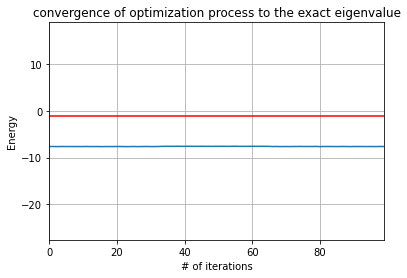

In [57]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)